In [5]:
import pandas as pd
import numpy as np

import os,cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression,Ridge, Lasso
from sklearn.preprocessing import MinMaxScaler 
from sklearn.tree import DecisionTreeClassifier
from pygam import LogisticGAM
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier,GradientBoostingClassifier,RandomForestClassifier

%matplotlib inline

# 讀取檔案裡的圖片

In [157]:
array_of_img = [] 
array_of_name = []

def read_directory(directory_name):

    for filename in os.listdir(directory_name):

        img = cv2.imread(directory_name + "/" + filename)
    
        array_of_img.append(img)
        array_of_name.append(filename)  
        
read_directory("C:/Users/tsaiy/MyPython/AIMango/C2_TrainDev/Dev")

In [158]:
df = pd.DataFrame([])

m1 = pd.DataFrame(array_of_name, columns=['imageID'])
m2 = pd.DataFrame(array_of_img, columns=['ORIGINAL'])

df = pd.concat([m1,m2],axis=1)
df

imageID                                           ORIGINAL
0     00002.jpg  [[[67, 62, 59], [66, 61, 58], [66, 61, 58], [6...
1     00003.jpg  [[[63, 53, 46], [63, 53, 46], [63, 53, 46], [6...
2     00004.jpg  [[[249, 251, 251], [249, 251, 251], [249, 251,...
3     00022.jpg  [[[33, 54, 15], [43, 64, 25], [57, 81, 41], [6...
4     00030.jpg  [[[66, 57, 54], [66, 57, 54], [66, 57, 54], [6...
...         ...                                                ...
3676  49987.jpg  [[[115, 117, 117], [115, 117, 117], [115, 117,...
3677  49988.jpg  [[[96, 92, 91], [95, 91, 90], [95, 91, 90], [9...
3678  49989.jpg  [[[145, 136, 139], [127, 118, 121], [117, 108,...
3679  49993.jpg  [[[139, 163, 99], [140, 164, 100], [142, 166, ...
3680  49997.jpg  [[[42, 37, 34], [43, 38, 35], [44, 39, 36], [4...

[3681 rows x 2 columns]

# 匯入label
1. 處理一圖多缺陷問題，一張圖可能有15個缺陷處，Dev裡的圖總共有6280個缺陷處
2. 將不良類別改為數值資料(0,1,2,3,4)
3. 將圖片與label合併

In [159]:
label = pd.read_csv('C:/Users/tsaiy/MyPython/AIMango/C2_TrainDev/dev.csv', header = None)

#1
temp = pd.DataFrame([])
name = label.iloc[:,[0]]

for i in range(1,76,5):
    pos = label.iloc[:, i:i+5] #缺陷位置
    merge = pd.concat([name, pos], axis = 1) #將缺陷的位置與圖片名稱合併
    
    temp = temp.append(merge.T.reset_index(drop=True).T) #將column name重設才好合併

label = temp.dropna()
label = label.reset_index(drop = True)

label = label.rename(columns={0: "imageID", 
                              1: "x",
                              2: "y",
                              3: "w",
                              4: "h",
                              5: "cat"})

#2
for i in range(len(label)):
    #將cat改成0,1,2
    if label.loc[i,'cat'] =="不良-著色不佳":
        label.loc[i,'cat'] = 0
    elif label.loc[i,'cat'] =="不良-炭疽病":
        label.loc[i,'cat'] = 1
    elif label.loc[i,'cat'] =="不良-乳汁吸附":
        label.loc[i,'cat'] = 2
    elif label.loc[i,'cat'] =="不良-黑斑病":
        label.loc[i,'cat'] = 3
    else:
        label.loc[i,'cat'] = 4  #"不良-機械傷害"

#3
df = pd.merge(label, df, on='imageID')
df

imageID    x    y    w    h cat  \
0     26519.jpg  559  772  233  413   4   
1     26519.jpg  848  539  102  231   1   
2     26519.jpg  615  491   85  141   1   
3     39995.jpg  376  481  103   88   4   
4     39995.jpg  615  612   46   32   1   
...         ...  ...  ...  ...  ...  ..   
6275  37653.jpg  140  553  873  876   0   
6276  37653.jpg  873  716   89  131   1   
6277  37653.jpg  890  598   28   80   1   
6278  27894.jpg  960  693   67   57   1   
6279  27894.jpg  854  332  383  539   0   

                                               ORIGINAL  
0     [[[124, 124, 84], [124, 124, 84], [125, 125, 8...  
1     [[[124, 124, 84], [124, 124, 84], [125, 125, 8...  
2     [[[124, 124, 84], [124, 124, 84], [125, 125, 8...  
3     [[[6, 9, 7], [6, 9, 7], [6, 9, 7], [6, 9, 7], ...  
4     [[[6, 9, 7], [6, 9, 7], [6, 9, 7], [6, 9, 7], ...  
...                                                 ...  
6275  [[[84, 105, 96], [85, 106, 97], [88, 109, 100]...  
6276  [[[84, 105, 96], [85, 106, 97], [88, 109, 100]...  
6277  [[[84, 105, 96], [85, 106, 97], [88, 109, 100]...  
6278  [[[6, 8, 8], [6, 8, 8], [6, 8, 8], [6, 8, 8], ...  
6279  [[[6, 8, 8], [6, 8, 8], [6, 8, 8], [6, 8, 8], ...  

[6280 rows x 7 columns]

# 確認各個不良特徵的個數

著色不佳共1997筆
炭疽病共3504筆
乳汁吸附共391筆
黑斑病共298筆
機械傷害共90筆


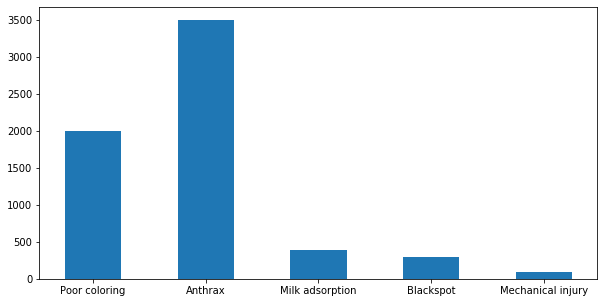

In [183]:
print("著色不佳共{}筆".format(len(df[df['cat'] == 0])))
print("炭疽病共{}筆".format(len(df[df['cat'] == 1])))
print("乳汁吸附共{}筆".format(len(df[df['cat'] == 2])))
print("黑斑病共{}筆".format(len(df[df['cat'] == 3])))
print("機械傷害共{}筆".format(len(df[df['cat'] == 4])))

fig, axs = plt.subplots(1, figsize = (10,5))
plt.bar(x = ['Poor coloring','Anthrax','Milk adsorption','Blackspot','Mechanical injury'],
        height = [len(df[df['cat'] == 0]),len(df[df['cat'] == 1]),len(df[df['cat'] == 2]),len(df[df['cat'] == 3]),len(df[df['cat'] == 4])],
        width = 0.5)
plt.show()

# 裁切不良缺陷處的image，命名為crop
1. 注意要進行裁切前，x,y,w,h必須是int

In [167]:
#將資料轉為int
df[["x", "y", "w", "h"]] = df[["x", "y", "w", "h"]].apply(pd.to_numeric)

array_of_crop = []

for i in range(len(df)):
    
    # 裁切區域的長度、寬度與位置
    x = df.loc[i,'x']
    y = df.loc[i,'y']
    w = df.loc[i,'w']
    h = df.loc[i,'h']

    # 裁切圖片
    crop = df.loc[i,'ORIGINAL'][y:y+h, x:x+w]
    array_of_crop.append(crop)
    
df['crop'] = array_of_crop
df

imageID    x    y    w    h cat  \
0     26519.jpg  559  772  233  413   4   
1     26519.jpg  848  539  102  231   1   
2     26519.jpg  615  491   85  141   1   
3     39995.jpg  376  481  103   88   4   
4     39995.jpg  615  612   46   32   1   
...         ...  ...  ...  ...  ...  ..   
6275  37653.jpg  140  553  873  876   0   
6276  37653.jpg  873  716   89  131   1   
6277  37653.jpg  890  598   28   80   1   
6278  27894.jpg  960  693   67   57   1   
6279  27894.jpg  854  332  383  539   0   

                                               ORIGINAL  \
0     [[[124, 124, 84], [124, 124, 84], [125, 125, 8...   
1     [[[124, 124, 84], [124, 124, 84], [125, 125, 8...   
2     [[[124, 124, 84], [124, 124, 84], [125, 125, 8...   
3     [[[6, 9, 7], [6, 9, 7], [6, 9, 7], [6, 9, 7], ...   
4     [[[6, 9, 7], [6, 9, 7], [6, 9, 7], [6, 9, 7], ...   
...                                                 ...   
6275  [[[84, 105, 96], [85, 106, 97], [88, 109, 100]...   
6276  [[[84, 105, 96], [85, 106, 97], [88, 109, 100]...   
6277  [[[84, 105, 96], [85, 106, 97], [88, 109, 100]...   
6278  [[[6, 8, 8], [6, 8, 8], [6, 8, 8], [6, 8, 8], ...   
6279  [[[6, 8, 8], [6, 8, 8], [6, 8, 8], [6, 8, 8], ...   

                                                   crop  
0     [[[25, 38, 130], [22, 37, 129], [23, 38, 130],...  
1     [[[84, 120, 220], [83, 119, 219], [83, 118, 22...  
2     [[[89, 108, 213], [90, 109, 214], [89, 108, 21...  
3     [[[65, 108, 189], [60, 103, 184], [58, 98, 180...  
4     [[[91, 116, 190], [97, 122, 194], [91, 117, 18...  
...                                                 ...  
6275  [[[157, 147, 193], [157, 147, 193], [156, 146,...  
6276  [[[114, 134, 243], [113, 133, 244], [113, 133,...  
6277  [[[125, 133, 255], [125, 133, 255], [124, 132,...  
6278  [[[123, 198, 254], [121, 199, 252], [121, 199,...  
6279  [[[91, 78, 170], [92, 79, 171], [90, 77, 169],...  

[6280 rows x 8 columns]

# original和crop圖片前處理
1. 取出RGB值
2. 轉成灰階
3. 轉成二元圖

### 取出RGB

In [194]:
original_r = []
original_g = []
original_b = []

crop_r = []
crop_g = []
crop_b = []

for i in range(len(df['ORIGINAL'])):

    #讀取RGB平均值
    channels_o = cv2.mean(df['ORIGINAL'][i])  #original
    channels_c = cv2.mean(df['crop'][i])  #crop
        
    #original   
    original_r.append(np.array(channels_o[2])) #red
    original_g.append(np.array(channels_o[1])) #green
    original_b.append(np.array(channels_o[0])) #blue
    #crop
    crop_r.append(np.array(channels_c[2])) #red
    crop_g.append(np.array(channels_c[1])) #green
    crop_b.append(np.array(channels_c[2])) #blue

In [195]:
len(original_r)

6280

### 轉成灰階圖

In [196]:
original_gray = []
crop_gray = []

for i in range(len(df['ORIGINAL'])):
    original_gray.append(cv2.cvtColor(df['ORIGINAL'][i], cv2.COLOR_BGR2GRAY)) #original
    crop_gray.append(cv2.cvtColor(df['crop'][i], cv2.COLOR_BGR2GRAY)) #crop

In [197]:
len(crop_gray)

6280

### 轉成二元圖

In [198]:
original_binary = []
crop_binary = []

for i in range(len(original_gray)):
    original_binary.append(cv2.threshold(original_gray[i],127,255,cv2.THRESH_BINARY)[1]) #original
    crop_binary.append(cv2.threshold(crop_gray[i],127,255,cv2.THRESH_BINARY)[1]) #crop

# 將RGB,二元圖,灰階合併入df

In [199]:
df['ori_R'] = original_r
df['ori_G'] = original_g
df['ori_B'] = original_b

df['crop_R'] = crop_r
df['crop_G'] = crop_g
df['crop_B'] = crop_b

df['ori_gray'] = original_gray
df['ori_binary'] = original_binary

df['crop_gray'] = original_gray
df['crop_binary'] = original_binary
df

imageID    x    y    w    h cat  \
0     26519.jpg  559  772  233  413   4   
1     26519.jpg  848  539  102  231   1   
2     26519.jpg  615  491   85  141   1   
3     39995.jpg  376  481  103   88   4   
4     39995.jpg  615  612   46   32   1   
...         ...  ...  ...  ...  ...  ..   
6275  37653.jpg  140  553  873  876   0   
6276  37653.jpg  873  716   89  131   1   
6277  37653.jpg  890  598   28   80   1   
6278  27894.jpg  960  693   67   57   1   
6279  27894.jpg  854  332  383  539   0   

                                               ORIGINAL  \
0     [[[124, 124, 84], [124, 124, 84], [125, 125, 8...   
1     [[[124, 124, 84], [124, 124, 84], [125, 125, 8...   
2     [[[124, 124, 84], [124, 124, 84], [125, 125, 8...   
3     [[[6, 9, 7], [6, 9, 7], [6, 9, 7], [6, 9, 7], ...   
4     [[[6, 9, 7], [6, 9, 7], [6, 9, 7], [6, 9, 7], ...   
...                                                 ...   
6275  [[[84, 105, 96], [85, 106, 97], [88, 109, 100]...   
6276  [[[84, 105, 96], [85, 106, 97], [88, 109, 100]...   
6277  [[[84, 105, 96], [85, 106, 97], [88, 109, 100]...   
6278  [[[6, 8, 8], [6, 8, 8], [6, 8, 8], [6, 8, 8], ...   
6279  [[[6, 8, 8], [6, 8, 8], [6, 8, 8], [6, 8, 8], ...   

                                                   crop               ori_R  \
0     [[[25, 38, 130], [22, 37, 129], [23, 38, 130],...  123.14716480396412   
1     [[[84, 120, 220], [83, 119, 219], [83, 118, 22...  123.14716480396412   
2     [[[89, 108, 213], [90, 109, 214], [89, 108, 21...  123.14716480396412   
3     [[[65, 108, 189], [60, 103, 184], [58, 98, 180...  148.64121329955594   
4     [[[91, 116, 190], [97, 122, 194], [91, 117, 18...  148.64121329955594   
...                                                 ...                 ...   
6275  [[[157, 147, 193], [157, 147, 193], [156, 146,...  133.17574451587816   
6276  [[[114, 134, 243], [113, 133, 244], [113, 133,...  133.17574451587816   
6277  [[[125, 133, 255], [125, 133, 255], [124, 132,...  133.17574451587816   
6278  [[[123, 198, 254], [121, 199, 252], [121, 199,...  124.11729526880197   
6279  [[[91, 78, 170], [92, 79, 171], [90, 77, 169],...  124.11729526880197   

                  ori_G              ori_B              crop_R  \
0     80.65150508174189    65.369711416739  141.02312192790114   
1     80.65150508174189    65.369711416739  183.27616501145914   
2     80.65150508174189    65.369711416739  188.39766374634962   
3     90.75637533659297  68.56668748228458  140.37157987643425   
4     90.75637533659297  68.56668748228458  159.91508152173913   
...                 ...                ...                 ...   
6275  82.35210446958189  71.74543253580728   168.1128554765753   
6276  82.35210446958189  71.74543253580728   238.5463590359379   
6277  82.35210446958189  71.74543253580728  246.37857142857143   
6278  95.31391723356009   96.1342969045257  247.92354019376802   
6279  95.31391723356009   96.1342969045257   204.0657294961659   

                  crop_G              crop_B  \
0     62.370148292094896  141.02312192790114   
1      85.63954672778202  183.27616501145914   
2      95.56236962870256  188.39766374634962   
3      81.88073698146513  140.37157987643425   
4             101.328125  159.91508152173913   
...                  ...                 ...   
6275   82.47948343768144   168.1128554765753   
6276   129.5643708722875   238.5463590359379   
6277              128.95  246.37857142857143   
6278  181.71563236449333  247.92354019376802   
6279  145.57076977479812   204.0657294961659   

                                               ori_gray  \
0     [[112, 112, 113, 114, 114, 115, 116, 116, 117,...   
1     [[112, 112, 113, 114, 114, 115, 116, 116, 117,...   
2     [[112, 112, 113, 114, 114, 115, 116, 116, 117,...   
3     [[8, 8, 8, 8, 8, 7, 5, 5, 11, 6, 1, 1, 6, 10, ...   
4     [[8, 8, 8, 8, 8, 7, 5, 5, 11, 6, 1, 1, 6, 10, ...   
...                                                 ...   
6275  [[100, 101, 104, 106, 106, 106, 104, 104, 10

# Haralicks Feature(original & crop)
1. ori_gray
2. crop_gray
3. 跑很久，按下去前請三思

### 提取original的Hara特徵 

In [200]:
import mahotas

array_of_ASM = [] #Angular Second Moment
array_of_Cons = [] #Contrast
array_of_Corr = [] #Correlation
array_of_Var = [] #Sum of Squares: Variance

array_of_IDM = [] #Inverse Diference Moment
array_of_SAv = [] #Sum Average
array_of_SVar = [] #Sum Variance
array_of_SEnt = [] #Sum Entropy

array_of_Ent = [] #Entropy
array_of_DVar = [] #Diference Variance
array_of_DEnt = [] #Difference Entropy
array_of_IMC1 = [] #Information Measures of Correlation 1
array_of_IMC2 = [] #Information Measures of Correlation 2



for i in range(len(df)):
    h = mahotas.features.haralick(df.loc[i,'ori_gray']) #4個矩陣代表了4個方向
    hara =  h.mean(axis = 0)#取四個矩陣的平均值以壓縮其維度，作為其features
    
    array_of_ASM.append(hara[0])
    array_of_Cons.append(hara[1])
    array_of_Corr.append(hara[2])
    
    array_of_Var.append(hara[3])
    array_of_IDM.append(hara[4])
    array_of_SAv.append(hara[5])
    
    array_of_SVar.append(hara[6])
    array_of_SEnt.append(hara[7])
    array_of_Ent.append(hara[8])
    array_of_DVar.append(hara[9])
    array_of_DEnt.append(hara[10])
    
    array_of_IMC1.append(hara[11])
    array_of_IMC2.append(hara[12])
    
df['ori_ASM'] = array_of_ASM
df['ori_Cons'] = array_of_Cons
df['ori_Corr'] = array_of_Corr
df['ori_Var'] = array_of_Var
df['ori_IDM'] = array_of_IDM
df['ori_SAv'] = array_of_SAv
df['ori_SVar'] = array_of_SVar
df['ori_SEnt'] = array_of_SEnt
df['ori_Ent'] = array_of_Ent
df['ori_DVar'] = array_of_DVar
df['ori_DEnt'] = array_of_DEnt
df['ori_IMC1'] = array_of_IMC1
df['ori_IMC2'] = array_of_IMC2

df

imageID    x    y    w    h cat  \
0     26519.jpg  559  772  233  413   4   
1     26519.jpg  848  539  102  231   1   
2     26519.jpg  615  491   85  141   1   
3     39995.jpg  376  481  103   88   4   
4     39995.jpg  615  612   46   32   1   
...         ...  ...  ...  ...  ...  ..   
6275  37653.jpg  140  553  873  876   0   
6276  37653.jpg  873  716   89  131   1   
6277  37653.jpg  890  598   28   80   1   
6278  27894.jpg  960  693   67   57   1   
6279  27894.jpg  854  332  383  539   0   

                                               ORIGINAL  \
0     [[[124, 124, 84], [124, 124, 84], [125, 125, 8...   
1     [[[124, 124, 84], [124, 124, 84], [125, 125, 8...   
2     [[[124, 124, 84], [124, 124, 84], [125, 125, 8...   
3     [[[6, 9, 7], [6, 9, 7], [6, 9, 7], [6, 9, 7], ...   
4     [[[6, 9, 7], [6, 9, 7], [6, 9, 7], [6, 9, 7], ...   
...                                                 ...   
6275  [[[84, 105, 96], [85, 106, 97], [88, 109, 100]...   
6276  [[[84, 105, 96], [85, 106, 97], [88, 109, 100]...   
6277  [[[84, 105, 96], [85, 106, 97], [88, 109, 100]...   
6278  [[[6, 8, 8], [6, 8, 8], [6, 8, 8], [6, 8, 8], ...   
6279  [[[6, 8, 8], [6, 8, 8], [6, 8, 8], [6, 8, 8], ...   

                                                   crop               ori_R  \
0     [[[25, 38, 130], [22, 37, 129], [23, 38, 130],...  123.14716480396412   
1     [[[84, 120, 220], [83, 119, 219], [83, 118, 22...  123.14716480396412   
2     [[[89, 108, 213], [90, 109, 214], [89, 108, 21...  123.14716480396412   
3     [[[65, 108, 189], [60, 103, 184], [58, 98, 180...  148.64121329955594   
4     [[[91, 116, 190], [97, 122, 194], [91, 117, 18...  148.64121329955594   
...                                                 ...                 ...   
6275  [[[157, 147, 193], [157, 147, 193], [156, 146,...  133.17574451587816   
6276  [[[114, 134, 243], [113, 133, 244], [113, 133,...  133.17574451587816   
6277  [[[125, 133, 255], [125, 133, 255], [124, 132,...  133.17574451587816   
6278  [[[123, 198, 254], [121, 199, 252], [121, 199,...  124.11729526880197   
6279  [[[91, 78, 170], [92, 79, 171], [90, 77, 169],...  124.11729526880197   

                  ori_G  ...      ori_Var   ori_IDM     ori_SAv      ori_SVar  \
0     80.65150508174189  ...  2841.827435  0.502730  183.237781  11356.375311   
1     80.65150508174189  ...  2841.827435  0.502730  183.237781  11356.375311   
2     80.65150508174189  ...  2841.827435  0.502730  183.237781  11356.375311   
3     90.75637533659297  ...  1987.532477  0.356041  211.139941   7913.717614   
4     90.75637533659297  ...  1987.532477  0.356041  211.139941   7913.717614   
...                 ...  ...          ...       ...         ...           ...   
6275  82.35210446958189  ...  2772.354079  0.435764  192.709105  11075.482992   
6276  82.35210446958189  ...  2772.354079  0.435764  192.709105  11075.482992   
6277  82.35210446958189  ...  2772.354079  0.435764  192.709105  11075.482992   
6278  95.31391723356009  ...  3828.893386  0.457454  208.060264  15160.125038   
6279  95.31391723356009  ...  3828.893386  0.457454  208.060264  15160.125038   

      ori_SEnt    ori_Ent  ori_DVar  ori_DEnt  ori_IMC1  ori_IMC2  
0     8.579580  10.817995  0.000870  2.603606 -0.577899  0.999916  
1     8.579580  10.817995  0.000870  2.603606 -0.577899  0.999916  
2     8.579580  10.817995  0.000870  2.603606 -0.577899  0.999916  
3     8.308323  11.323231  0.000572  3.289006 -0.452437  0.999267  
4     8.308323  11.323231  0.000572  3.289006 -0.452437  0.999267  
...        ...        ...       ...       ...       ...       ...  
6275  8.503315  11.001444  0.000765  2.770887 -0.535043  0.999822  
6276  8.503315  11.001444  0.000765  2.770887 -0.535043  0.999822  
6277  8.503315  11.001444  0.000765  2.770887 -0.535043  0.999822  
6278  8.721709  11.750969  0.000683  3.458921 -0.483626  0.999661  
6279  8.721709  11.750969  0.000683  3.458921 -0.483626  0.999661  

[6280 rows x 31 columns]

### 提取crop的Hara特徵 

In [201]:
array_of_ASM = [] #Angular Second Moment
array_of_Cons = [] #Contrast
array_of_Corr = [] #Correlation
array_of_Var = [] #Sum of Squares: Variance

array_of_IDM = [] #Inverse Diference Moment
array_of_SAv = [] #Sum Average
array_of_SVar = [] #Sum Variance
array_of_SEnt = [] #Sum Entropy

array_of_Ent = [] #Entropy
array_of_DVar = [] #Diference Variance
array_of_DEnt = [] #Difference Entropy
array_of_IMC1 = [] #Information Measures of Correlation 1
array_of_IMC2 = [] #Information Measures of Correlation 2

for i in range(len(df)):
    h = mahotas.features.haralick(df.loc[i,'crop_gray']) #4個矩陣代表了4個方向
    hara =  h.mean(axis = 0)#取四個矩陣的平均值以壓縮其維度，作為其features
    
    array_of_ASM.append(hara[0])
    array_of_Cons.append(hara[1])
    array_of_Corr.append(hara[2])
    
    array_of_Var.append(hara[3])
    array_of_IDM.append(hara[4])
    array_of_SAv.append(hara[5])
    
    array_of_SVar.append(hara[6])
    array_of_SEnt.append(hara[7])
    array_of_Ent.append(hara[8])
    array_of_DVar.append(hara[9])
    array_of_DEnt.append(hara[10])
    
    array_of_IMC1.append(hara[11])
    array_of_IMC2.append(hara[12])
    
df['crop_ASM'] = array_of_ASM
df['crop_Cons'] = array_of_Cons
df['crop_Corr'] = array_of_Corr
df['crop_Var'] = array_of_Var
df['crop_IDM'] = array_of_IDM
df['crop_SAv'] = array_of_SAv
df['crop_SVar'] = array_of_SVar
df['crop_SEnt'] = array_of_SEnt
df['crop_Ent'] = array_of_Ent
df['crop_DVar'] = array_of_DVar
df['crop_DEnt'] = array_of_DEnt
df['crop_IMC1'] = array_of_IMC1
df['crop_IMC2'] = array_of_IMC2

df

imageID    x    y    w    h cat  \
0     26519.jpg  559  772  233  413   4   
1     26519.jpg  848  539  102  231   1   
2     26519.jpg  615  491   85  141   1   
3     39995.jpg  376  481  103   88   4   
4     39995.jpg  615  612   46   32   1   
...         ...  ...  ...  ...  ...  ..   
6275  37653.jpg  140  553  873  876   0   
6276  37653.jpg  873  716   89  131   1   
6277  37653.jpg  890  598   28   80   1   
6278  27894.jpg  960  693   67   57   1   
6279  27894.jpg  854  332  383  539   0   

                                               ORIGINAL  \
0     [[[124, 124, 84], [124, 124, 84], [125, 125, 8...   
1     [[[124, 124, 84], [124, 124, 84], [125, 125, 8...   
2     [[[124, 124, 84], [124, 124, 84], [125, 125, 8...   
3     [[[6, 9, 7], [6, 9, 7], [6, 9, 7], [6, 9, 7], ...   
4     [[[6, 9, 7], [6, 9, 7], [6, 9, 7], [6, 9, 7], ...   
...                                                 ...   
6275  [[[84, 105, 96], [85, 106, 97], [88, 109, 100]...   
6276  [[[84, 105, 96], [85, 106, 97], [88, 109, 100]...   
6277  [[[84, 105, 96], [85, 106, 97], [88, 109, 100]...   
6278  [[[6, 8, 8], [6, 8, 8], [6, 8, 8], [6, 8, 8], ...   
6279  [[[6, 8, 8], [6, 8, 8], [6, 8, 8], [6, 8, 8], ...   

                                                   crop               ori_R  \
0     [[[25, 38, 130], [22, 37, 129], [23, 38, 130],...  123.14716480396412   
1     [[[84, 120, 220], [83, 119, 219], [83, 118, 22...  123.14716480396412   
2     [[[89, 108, 213], [90, 109, 214], [89, 108, 21...  123.14716480396412   
3     [[[65, 108, 189], [60, 103, 184], [58, 98, 180...  148.64121329955594   
4     [[[91, 116, 190], [97, 122, 194], [91, 117, 18...  148.64121329955594   
...                                                 ...                 ...   
6275  [[[157, 147, 193], [157, 147, 193], [156, 146,...  133.17574451587816   
6276  [[[114, 134, 243], [113, 133, 244], [113, 133,...  133.17574451587816   
6277  [[[125, 133, 255], [125, 133, 255], [124, 132,...  133.17574451587816   
6278  [[[123, 198, 254], [121, 199, 252], [121, 199,...  124.11729526880197   
6279  [[[91, 78, 170], [92, 79, 171], [90, 77, 169],...  124.11729526880197   

                  ori_G  ...     crop_Var  crop_IDM    crop_SAv     crop_SVar  \
0     80.65150508174189  ...  2841.827435  0.502730  183.237781  11356.375311   
1     80.65150508174189  ...  2841.827435  0.502730  183.237781  11356.375311   
2     80.65150508174189  ...  2841.827435  0.502730  183.237781  11356.375311   
3     90.75637533659297  ...  1987.532477  0.356041  211.139941   7913.717614   
4     90.75637533659297  ...  1987.532477  0.356041  211.139941   7913.717614   
...                 ...  ...          ...       ...         ...           ...   
6275  82.35210446958189  ...  2772.354079  0.435764  192.709105  11075.482992   
6276  82.35210446958189  ...  2772.354079  0.435764  192.709105  11075.482992   
6277  82.35210446958189  ...  2772.354079  0.435764  192.709105  11075.482992   
6278  95.31391723356009  ...  3828.893386  0.457454  208.060264  15160.125038   
6279  95.31391723356009  ...  3828.893386  0.457454  208.060264  15160.125038   

     crop_SEnt   crop_Ent crop_DVar crop_DEnt  crop_IMC1  crop_IMC2  
0     8.579580  10.817995  0.000870  2.603606  -0.577899   0.999916  
1     8.579580  10.817995  0.000870  2.603606  -0.577899   0.999916  
2     8.579580  10.817995  0.000870  2.603606  -0.577899   0.999916  
3     8.308323  11.323231  0.000572  3.289006  -0.452437   0.999267  
4     8.308323  11.323231  0.000572  3.289006  -0.452437   0.999267  
...        ...        ...       ...       ...        ...        ...  
6275  8.503315  11.001444  0.000765  2.770887  -0.535043   0.999822  
6276  8.503315  11.001444  0.000765  2.770887  -0.535043   0.999822  
6277  8.503315  11.001444  0.000765  2.770887  -0.535043   0.999822  
6278  8.721709  11.750969  0.000683  3.458921  -0.483626   0.999661  
6279  8.721709  11.750969  0.000683  3.458921  -0.483626   0.999661  

[6280 rows x 44 col

# 匯出excel

In [8]:
#df.to_excel('Data.xlsx')

# 匯入Data

In [7]:
df = pd.read_excel("C:/Users/tsaiy/MyPython/AIMango/Data.xlsx")

# 各不良部位的樣本數

著色不佳樣本數：1997
炭疽病樣本數：3504
乳汁吸附樣本數：391
黑斑病樣本數：298
機械傷害樣本數：90


<BarContainer object of 5 artists>

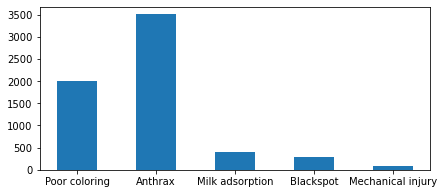

In [13]:
print("著色不佳樣本數：{}".format(len(df[df['cat'] == 0])))
print("炭疽病樣本數：{}".format(len(df[df['cat'] == 1])))
print("乳汁吸附樣本數：{}".format(len(df[df['cat'] == 2])))
print("黑斑病樣本數：{}".format(len(df[df['cat'] == 3])))
print("機械傷害樣本數：{}".format(len(df[df['cat'] == 4])))

fig, axs = plt.subplots(1, figsize = (7,3))
plt.bar(x = ['Poor coloring','Anthrax','Milk adsorption','Blackspot','Mechanical injury'],
        height = [len(df[df['cat'] == 0]),
                  len(df[df['cat'] == 1]),
                  len(df[df['cat'] == 2]),
                  len(df[df['cat'] == 3]),
                  len(df[df['cat'] == 4])],
        width = 0.5)

# 如何處理資料不平衡的問題?
https://www.zhihu.com/question/264240892
1. Bayes及一些針對小數據量設計的模型，例如SVM
2. 加入更多「先驗知識(例如參數可能符合某些分布等等)」，減少對數據量的需求
3. deep learning
4. 正規化：包括L1、L2、dropout、multi-task learning、early stopping
5. transfering learning
6. upsampling：是把小種類複製多份，上採樣後的數據集中會反復出現一些樣本，訓練出來的模型會有一定的過擬合
https://www.dezyre.com/recipes/deal-with-imbalance-classes-with-upsampling-in-python

### Upsampling

著色不佳樣本數：3504
炭疽病樣本數：3504
乳汁吸附樣本數：3504
黑斑病樣本數：3504
機械傷害樣本數：3504


<BarContainer object of 5 artists>

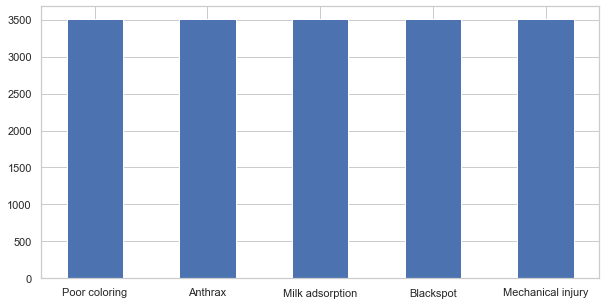

In [299]:
#最大樣本數為Anthrax，以他為基準做upsample
maxnum = len(df[df['cat'] == 1])

#對Anthrax以外的樣本做upsampling, index作為索引
#with replacement
class0_id = np.random.choice(df[df['cat'] == 0].index, size = maxnum, replace = True)
class2_id = np.random.choice(df[df['cat'] == 2].index, size = maxnum, replace = True)
class3_id = np.random.choice(df[df['cat'] == 3].index, size = maxnum, replace = True)
class4_id = np.random.choice(df[df['cat'] == 4].index, size = maxnum, replace = True)

class0 = df.iloc[class0_id]
class1 = df[df['cat'] == 1]
class2 = df.iloc[class2_id]
class3 = df.iloc[class3_id]
class4 = df.iloc[class4_id]

df = pd.concat([class0,class1,class2,class3,class4],axis=0) #往下合併

########################################Result#######################################################
print("著色不佳樣本數：{}".format(len(df1[df1['cat'] == 0])))
print("炭疽病樣本數：{}".format(len(df1[df1['cat'] == 1])))
print("乳汁吸附樣本數：{}".format(len(df1[df1['cat'] == 2])))
print("黑斑病樣本數：{}".format(len(df1[df1['cat'] == 3])))
print("機械傷害樣本數：{}".format(len(df1[df1['cat'] == 4])))

fig, axs = plt.subplots(1, figsize = (10,5))
plt.bar(x = ['Poor coloring','Anthrax','Milk adsorption','Blackspot','Mechanical injury'],
        height = [len(df[df['cat'] == 0]),
                  len(df[df['cat'] == 1]),
                  len(df[df['cat'] == 2]),
                  len(df[df['cat'] == 3]),
                  len(df[df['cat'] == 4])],
        width = 0.5)

# 各不良品間RGB值分布圖及敘述統計量

### 原圖的RGB比較

          cat        ori_R        ori_G        ori_B
count  1997.0  1997.000000  1997.000000  1997.000000
mean      0.0   102.592998   108.034347    96.387557
std       0.0    23.793458    14.843812    15.893108
min       0.0    51.474634    64.198716    52.263073
25%       0.0    85.694064    98.477756    85.890305
50%       0.0    95.991375   105.855885    93.317055
75%       0.0   117.483067   115.421724   102.502511
max       0.0   177.478479   157.830709   153.259345
          cat        ori_R        ori_G        ori_B
count  3504.0  3504.000000  3504.000000  3504.000000
mean      1.0   129.299691   101.145063    91.616781
std       0.0    28.725791    14.701088    15.448252
min       1.0    57.458383    58.215401    52.476286
25%       1.0   106.591035    91.600733    81.860319
50%       1.0   134.379993   100.632539    91.062465
75%       1.0   151.123822   110.275812   100.630937
max       1.0   188.204776   157.830709   149.347292
         cat       ori_R       ori_G       ori

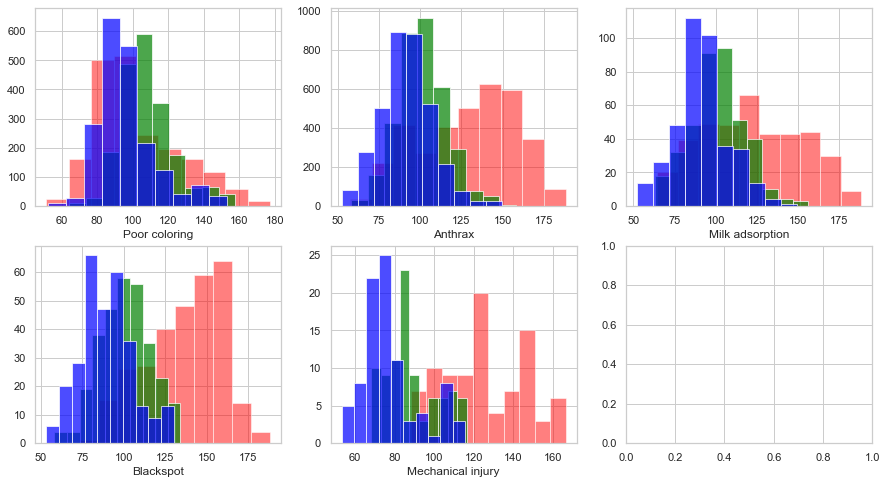

In [69]:
RGB = df.loc[:,['cat','ori_R','ori_G','ori_B']]
print(RGB[RGB['cat'] == 0].astype(float).describe())
print(RGB[RGB['cat'] == 1].astype(float).describe())
print(RGB[RGB['cat'] == 2].astype(float).describe())
print(RGB[RGB['cat'] == 3].astype(float).describe())
print(RGB[RGB['cat'] == 4].astype(float).describe())

fig, axs = plt.subplots(2,3, figsize = (15,8))

axs[0, 0].hist(df[df['cat'] == 0]['ori_R'], label = 'ori_R', alpha = 0.5, color = 'red')
axs[0, 0].hist(df[df['cat'] == 0]['ori_G'], label = 'ori_G', alpha = 0.7, color = 'green')
axs[0, 0].hist(df[df['cat'] == 0]['ori_B'], label = 'ori_B', alpha = 0.7, color = 'blue')
axs[0, 0].set(xlabel='Poor coloring')

axs[0, 1].hist(df[df['cat'] == 1]['ori_R'], label = 'ori_R', alpha = 0.5, color = 'red')
axs[0, 1].hist(df[df['cat'] == 1]['ori_G'], label = 'ori_G', alpha = 0.7, color = 'green')
axs[0, 1].hist(df[df['cat'] == 1]['ori_B'], label = 'ori_B', alpha = 0.7, color = 'blue')
axs[0, 1].set(xlabel='Anthrax')

axs[0, 2].hist(df[df['cat'] == 2]['ori_R'], label = 'ori_R', alpha = 0.5, color = 'red')
axs[0, 2].hist(df[df['cat'] == 2]['ori_G'], label = 'ori_G', alpha = 0.7, color = 'green')
axs[0, 2].hist(df[df['cat'] == 2]['ori_B'], label = 'ori_B', alpha = 0.7, color = 'blue')
axs[0, 2].set(xlabel='Milk adsorption')

axs[1, 0].hist(df[df['cat'] == 3]['ori_R'], label = 'ori_R', alpha = 0.5, color = 'red')
axs[1, 0].hist(df[df['cat'] == 3]['ori_G'], label = 'ori_G', alpha = 0.7, color = 'green')
axs[1, 0].hist(df[df['cat'] == 3]['ori_B'], label = 'ori_B', alpha = 0.7, color = 'blue')
axs[1, 0].set(xlabel='Blackspot')

axs[1, 1].hist(df[df['cat'] == 4]['ori_R'], label = 'ori_R', alpha = 0.5, color = 'red')
axs[1, 1].hist(df[df['cat'] == 4]['ori_G'], label = 'ori_G', alpha = 0.7, color = 'green')
axs[1, 1].hist(df[df['cat'] == 4]['ori_B'], label = 'ori_B', alpha = 0.7, color = 'blue')
axs[1, 1].set(xlabel='Mechanical injury')
plt.show()

### 不良缺陷處(crop) 的RGB比較

-----著色不佳----
          cat       crop_R       crop_G       crop_B
count  1997.0  1997.000000  1997.000000  1997.000000
mean      0.0   184.322617   141.192654   184.322617
std       0.0    41.445191    37.695558    41.445191
min       0.0    52.262899    25.464484    52.262899
25%       0.0   156.467944   115.507724   156.467944
50%       0.0   183.736462   138.872271   183.736462
75%       0.0   215.919277   163.857751   215.919277
max       0.0   254.250168   251.021197   254.250168
-----炭疽病----
          cat       crop_R       crop_G       crop_B
count  3504.0  3504.000000  3504.000000  3504.000000
mean      1.0   181.686977   106.543303   181.686977
std       0.0    41.741173    40.618449    41.741173
min       1.0    37.218072     9.803488    37.218072
25%       1.0   153.670028    78.290482   153.670028
50%       1.0   183.968722   103.883108   183.968722
75%       1.0   212.932741   133.020563   212.932741
max       1.0   253.938940   250.269886   253.938940
-----乳汁吸附----
     

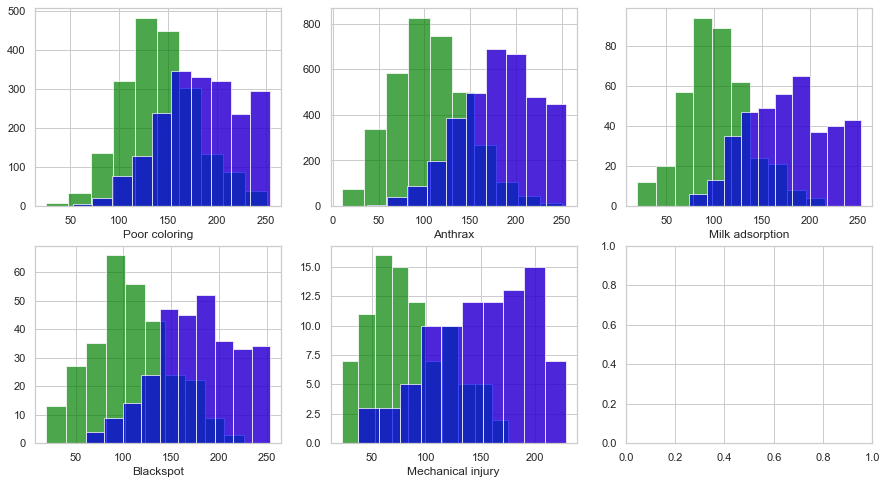

In [85]:
RGB = df.loc[:,['cat','crop_R','crop_G','crop_B']]
print("-----著色不佳----")
print(RGB[RGB['cat'] == 0].astype(float).describe())
print("-----炭疽病----")
print(RGB[RGB['cat'] == 1].astype(float).describe())
print("-----乳汁吸附----")
print(RGB[RGB['cat'] == 2].astype(float).describe())
print("-----黑斑病----")
print(RGB[RGB['cat'] == 3].astype(float).describe())
print("-----機械傷害----")
print(RGB[RGB['cat'] == 4].astype(float).describe())

fig, axs = plt.subplots(2,3, figsize = (15,8))

axs[0, 0].hist(df[df['cat'] == 0]['crop_R'], label = 'crop_R', alpha = 0.5, color = 'red')
axs[0, 0].hist(df[df['cat'] == 0]['crop_G'], label = 'crop_G', alpha = 0.7, color = 'green')
axs[0, 0].hist(df[df['cat'] == 0]['crop_B'], label = 'crop_B', alpha = 0.7, color = 'blue')
axs[0, 0].set(xlabel='Poor coloring')

axs[0, 1].hist(df[df['cat'] == 1]['crop_R'], label = 'crop_R', alpha = 0.5, color = 'red')
axs[0, 1].hist(df[df['cat'] == 1]['crop_G'], label = 'crop_G', alpha = 0.7, color = 'green')
axs[0, 1].hist(df[df['cat'] == 1]['crop_B'], label = 'crop_B', alpha = 0.7, color = 'blue')
axs[0, 1].set(xlabel='Anthrax')

axs[0, 2].hist(df[df['cat'] == 2]['crop_R'], label = 'crop_R', alpha = 0.5, color = 'red')
axs[0, 2].hist(df[df['cat'] == 2]['crop_G'], label = 'crop_G', alpha = 0.7, color = 'green')
axs[0, 2].hist(df[df['cat'] == 2]['crop_B'], label = 'crop_B', alpha = 0.7, color = 'blue')
axs[0, 2].set(xlabel='Milk adsorption')

axs[1, 0].hist(df[df['cat'] == 3]['crop_R'], label = 'crop_R', alpha = 0.5, color = 'red')
axs[1, 0].hist(df[df['cat'] == 3]['crop_G'], label = 'crop_G', alpha = 0.7, color = 'green')
axs[1, 0].hist(df[df['cat'] == 3]['crop_B'], label = 'crop_B', alpha = 0.7, color = 'blue')
axs[1, 0].set(xlabel='Blackspot')

axs[1, 1].hist(df[df['cat'] == 4]['crop_R'], label = 'crop_R', alpha = 0.5, color = 'red')
axs[1, 1].hist(df[df['cat'] == 4]['crop_G'], label = 'crop_G', alpha = 0.7, color = 'green')
axs[1, 1].hist(df[df['cat'] == 4]['crop_B'], label = 'crop_B', alpha = 0.7, color = 'blue')
axs[1, 1].set(xlabel='Mechanical injury')

plt.show()

# 原圖的全部特徵比較 - 鬍鬚圖

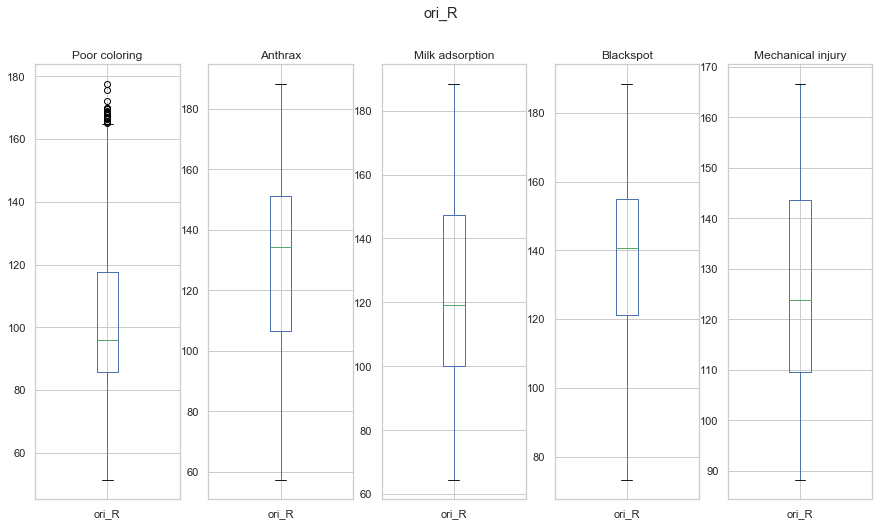

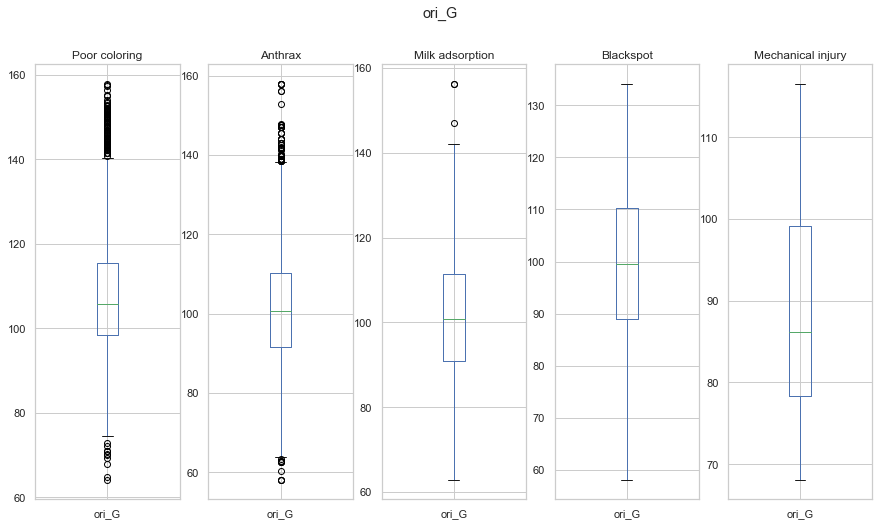

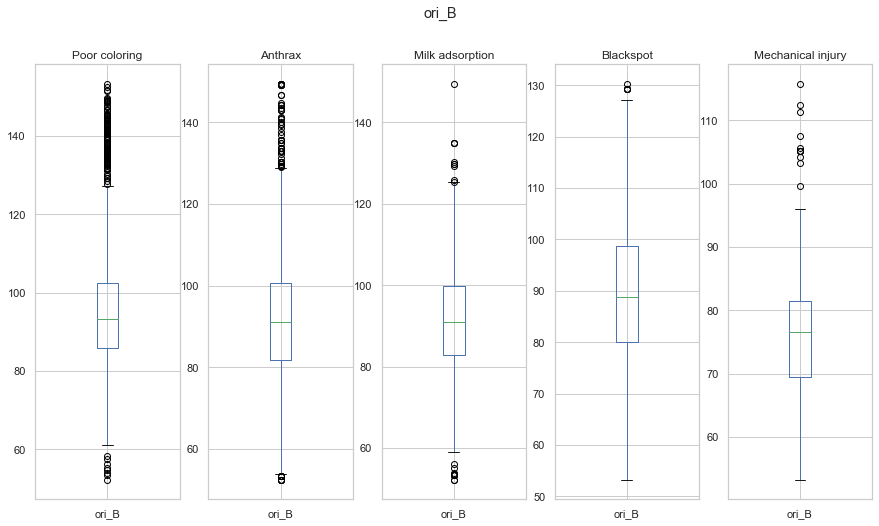

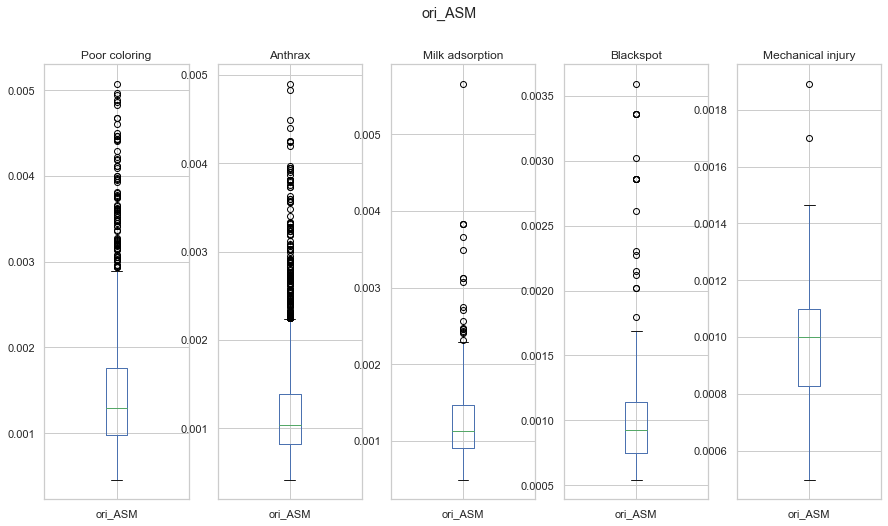

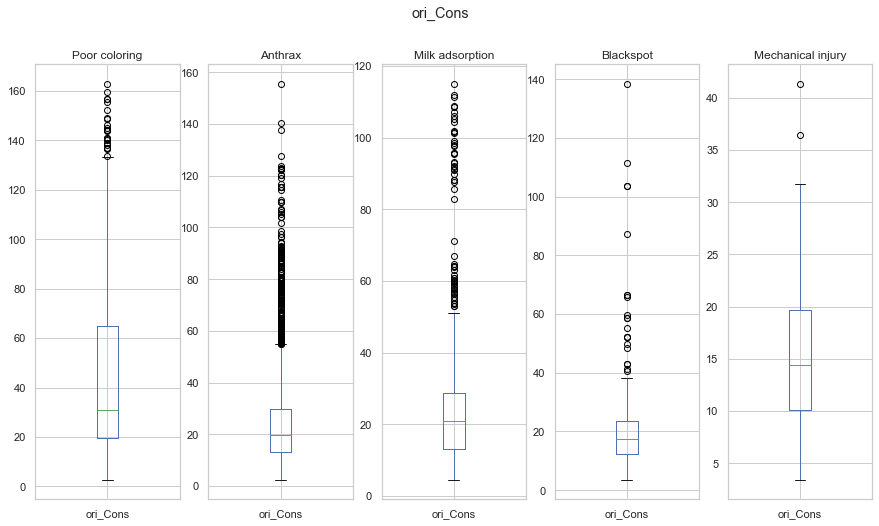

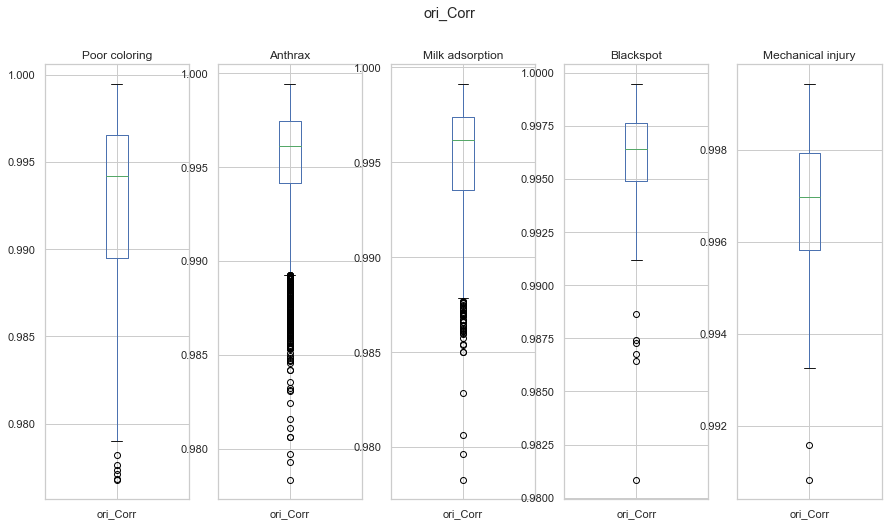

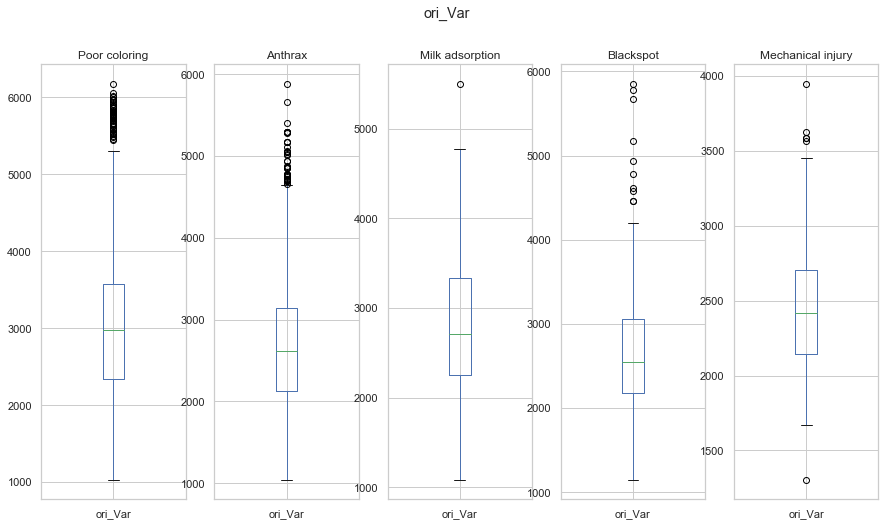

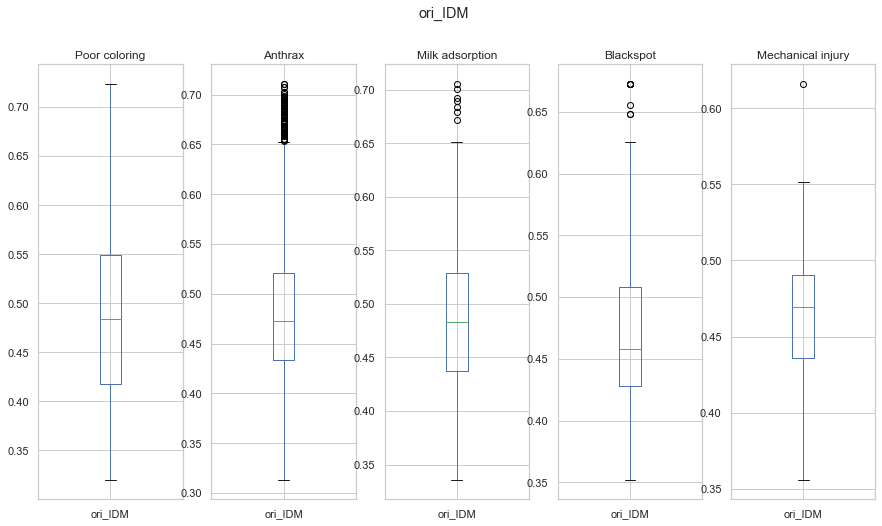

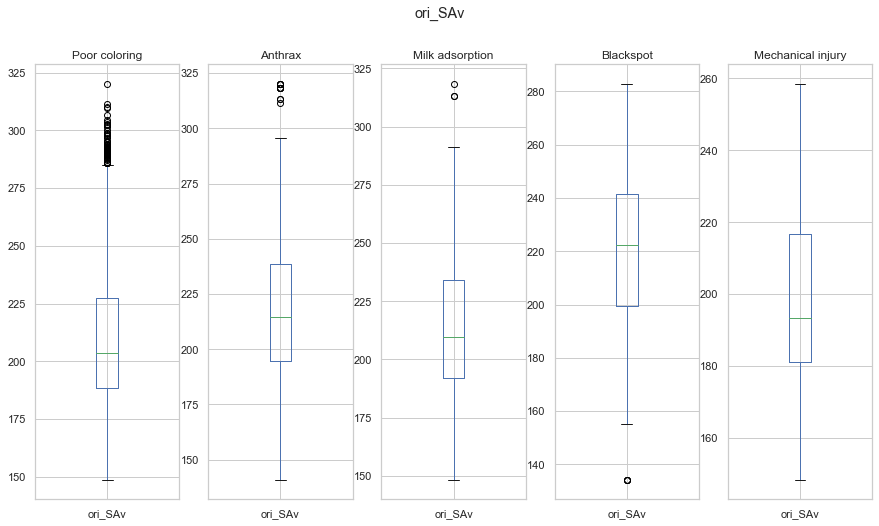

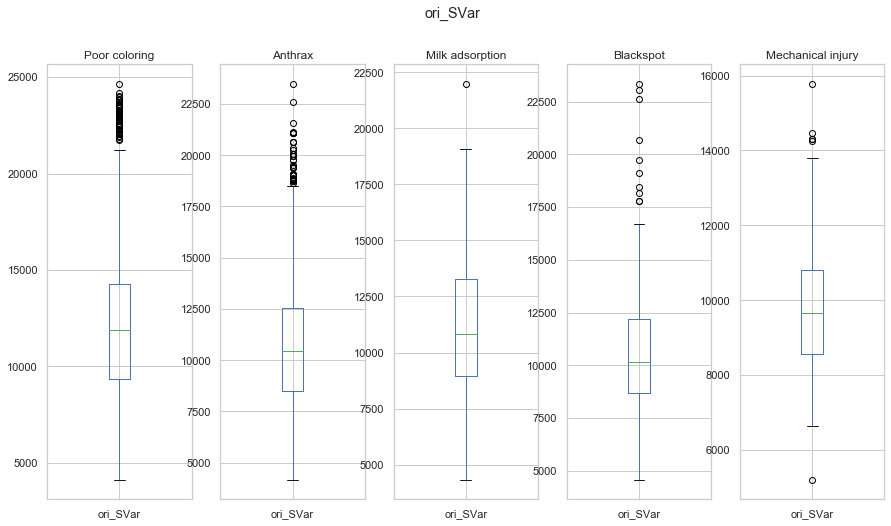

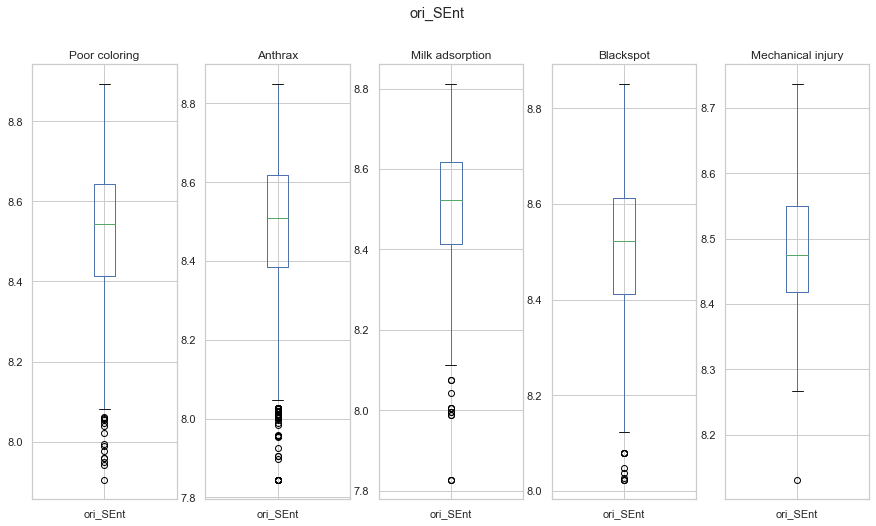

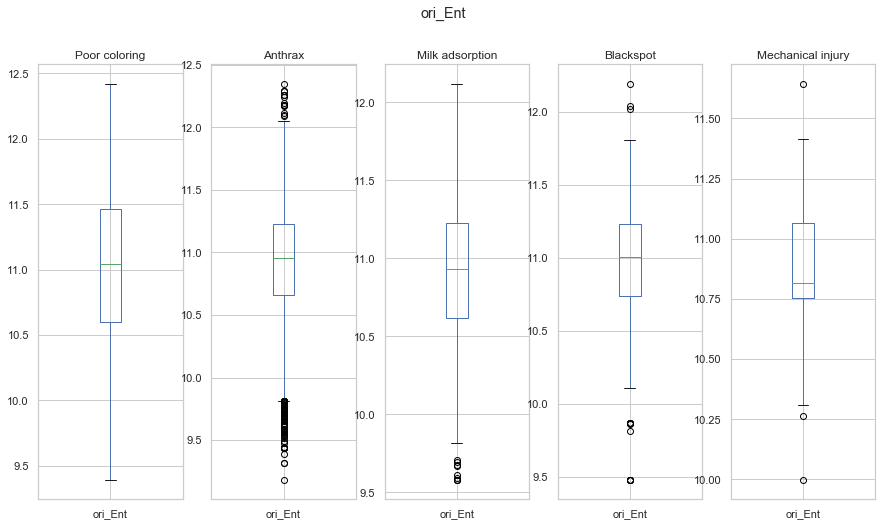

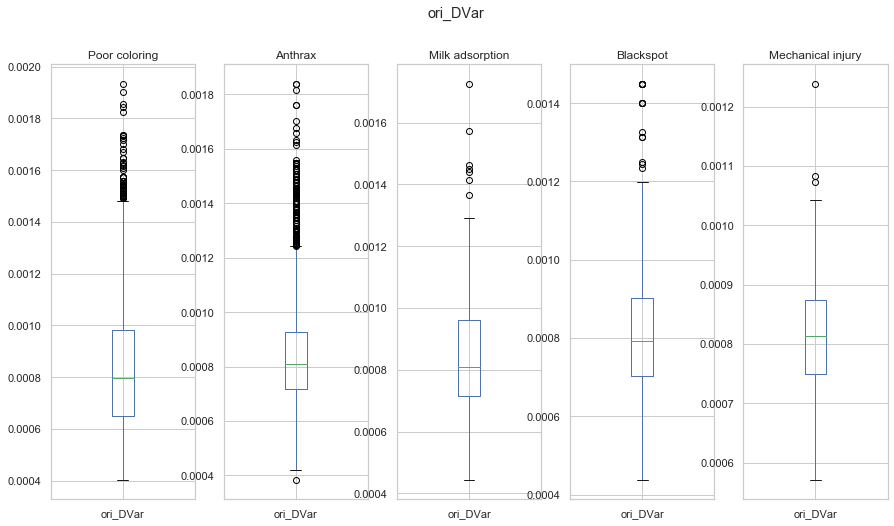

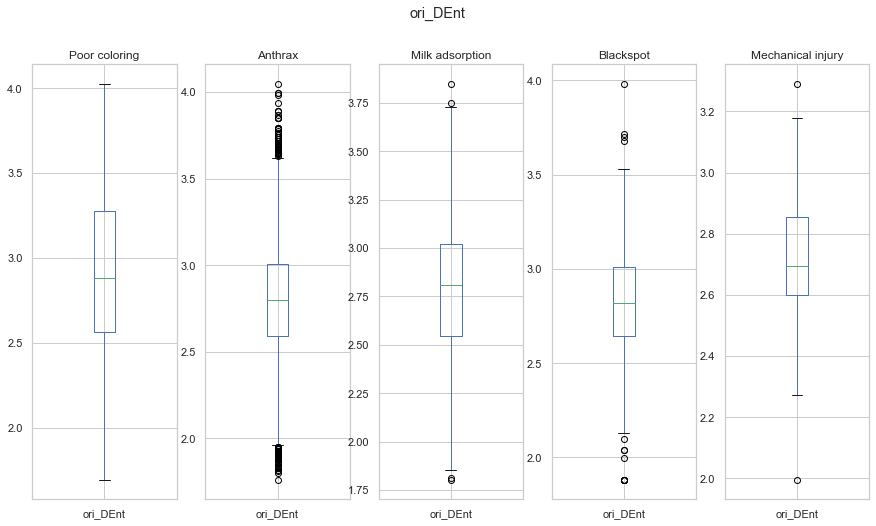

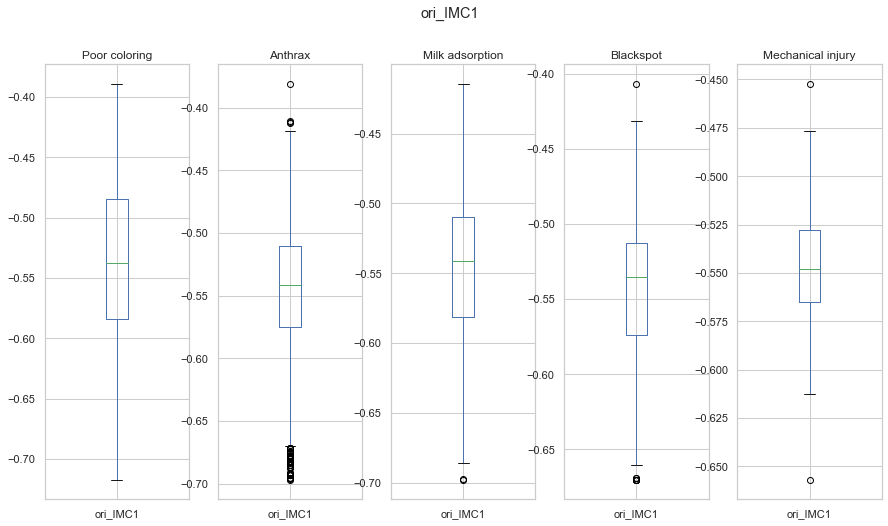

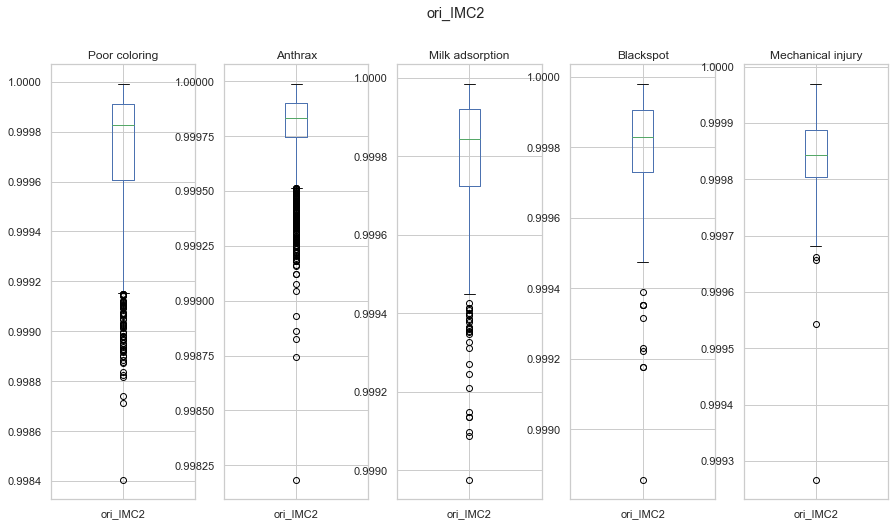

In [123]:
ori_features = ['ori_R', 'ori_G', 'ori_B', 'ori_ASM', 'ori_Cons', 'ori_Corr', 'ori_Var', 'ori_IDM', 'ori_SAv', 'ori_SVar', 'ori_SEnt', 'ori_Ent', 'ori_DVar', 'ori_DEnt', 'ori_IMC1', 'ori_IMC2']

for feature in ori_features:
    fig, axs = plt.subplots(1,5, figsize = (15,8))
    df[df['cat'] == 0][feature].plot(kind = 'box', ax = axs[0], title ='Poor coloring')
    df[df['cat'] == 1][feature].plot(kind = 'box', ax = axs[1], title ='Anthrax')
    df[df['cat'] == 2][feature].plot(kind = 'box', ax = axs[2], title ='Milk adsorption')
    df[df['cat'] == 3][feature].plot(kind = 'box', ax = axs[3], title ='Blackspot')
    df[df['cat'] == 4][feature].plot(kind = 'box', ax = axs[4], title ='Mechanical injury')
    plt.suptitle(feature)
    plt.savefig(feature+"_box")
    plt.show()

# 原圖的全部特徵比較 - 密度圖

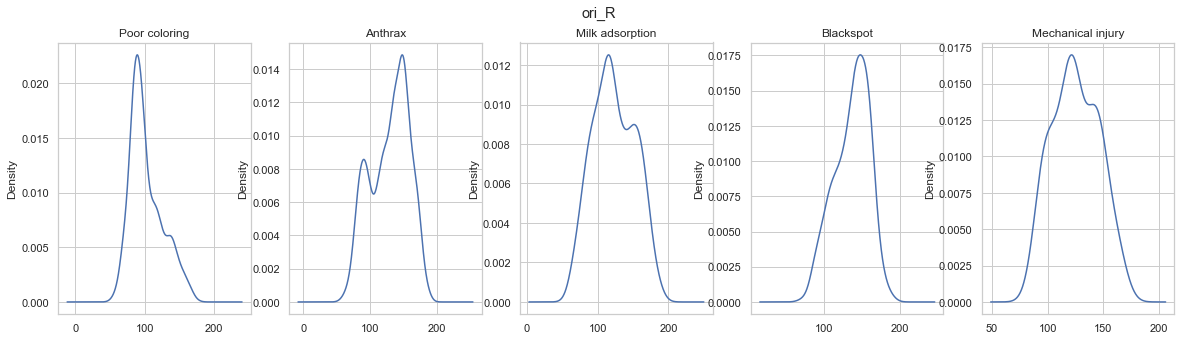

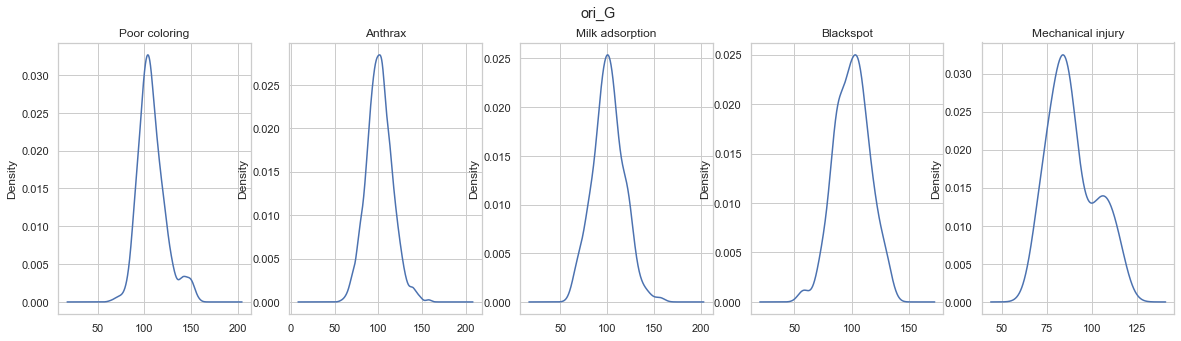

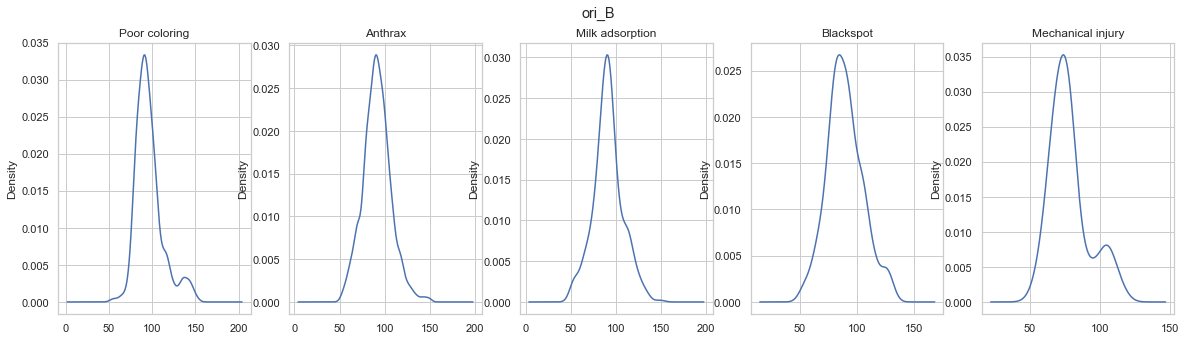

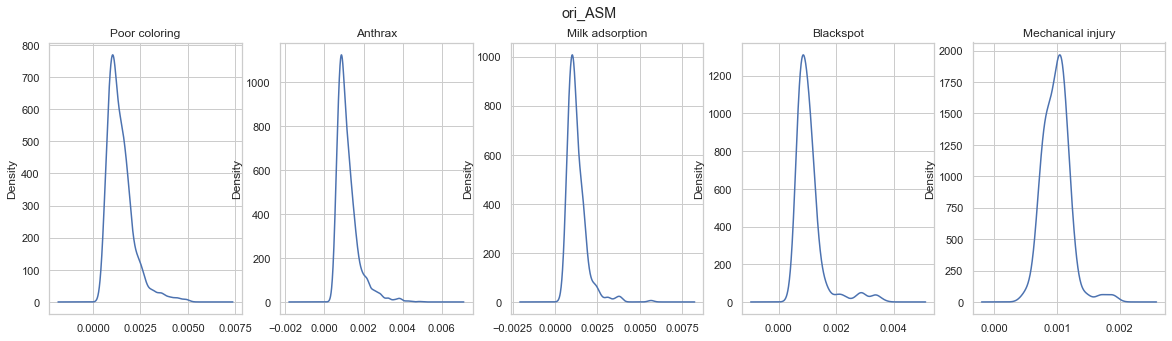

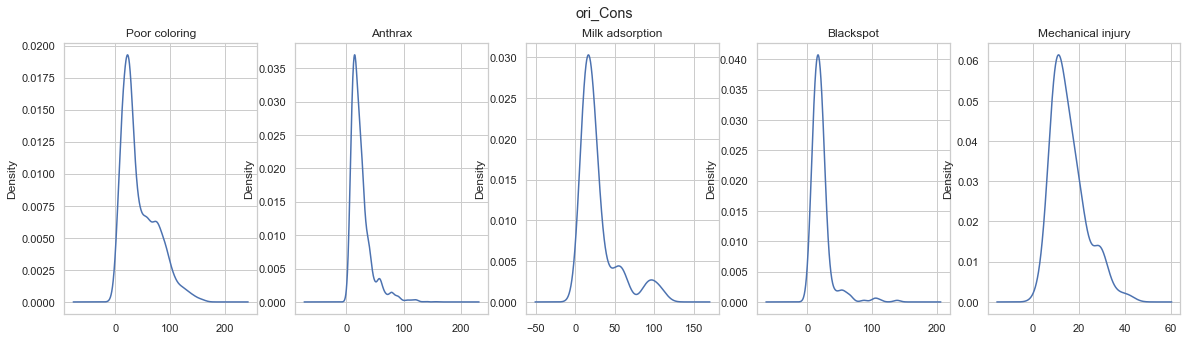

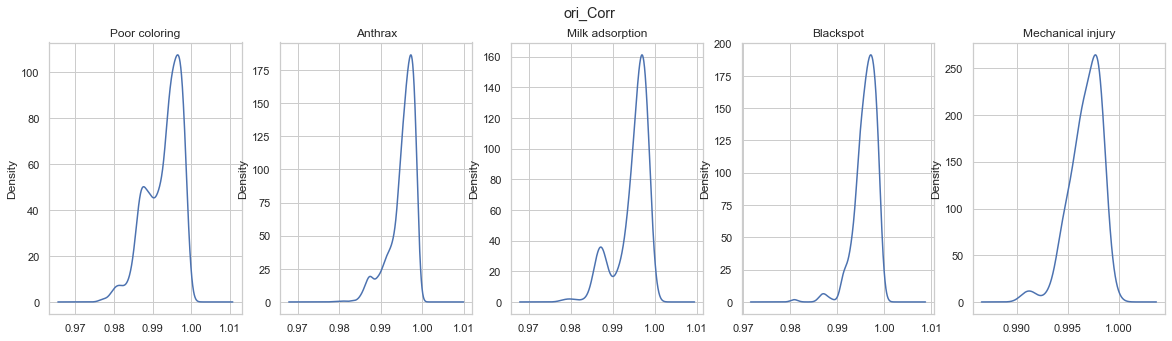

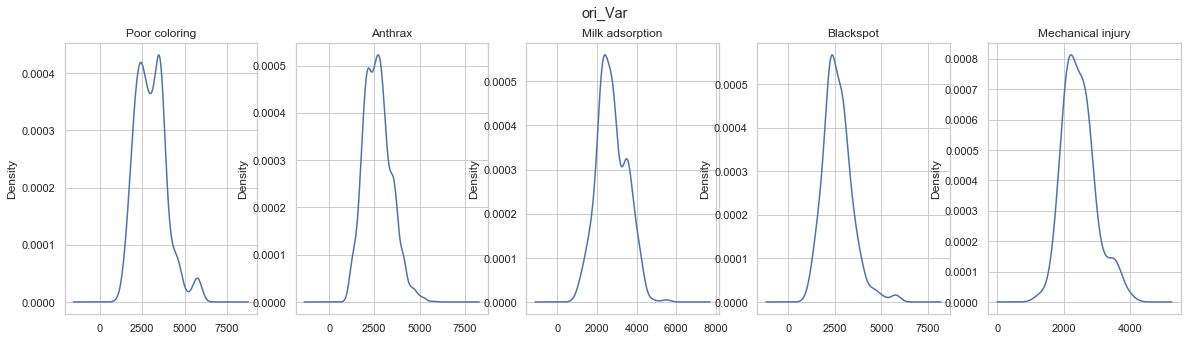

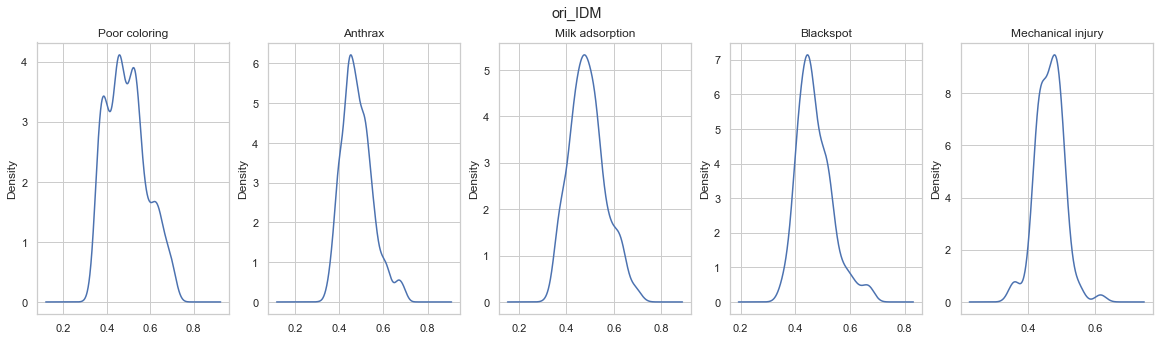

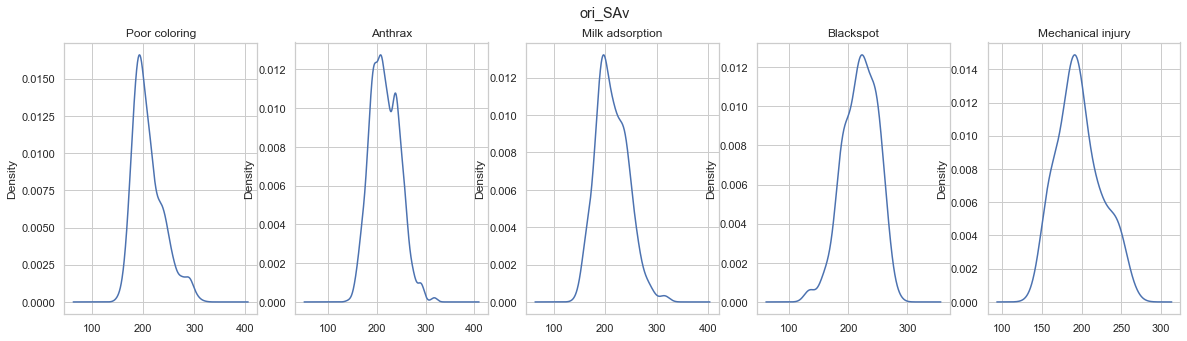

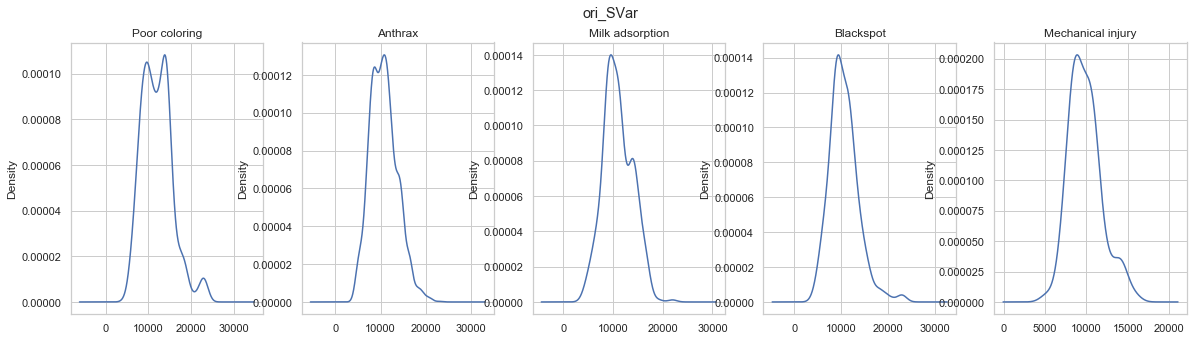

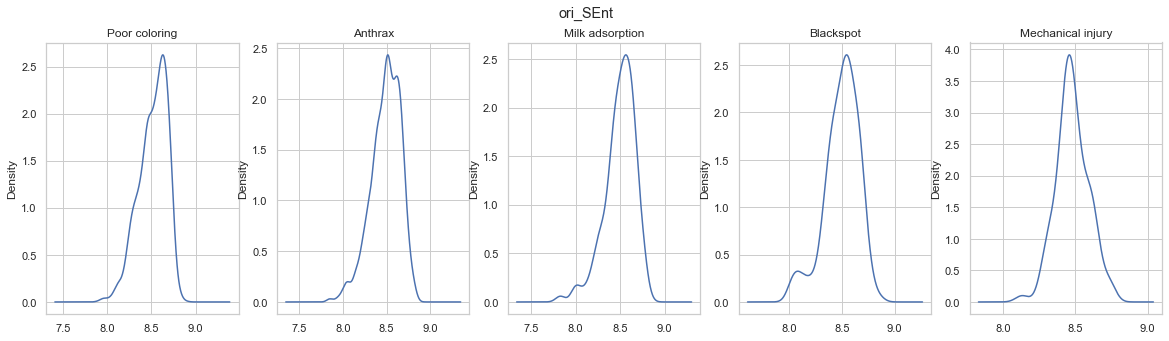

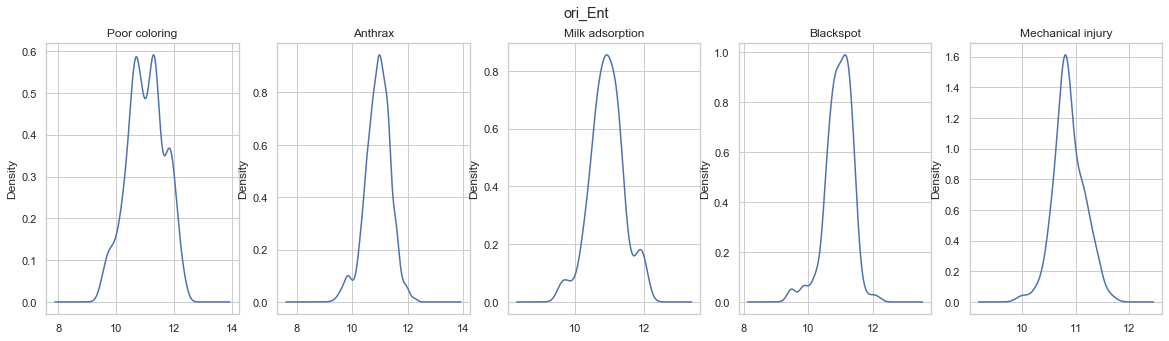

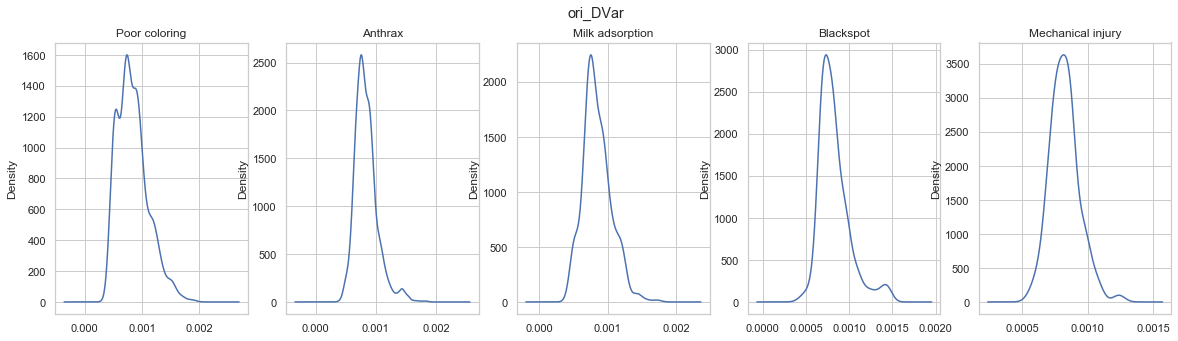

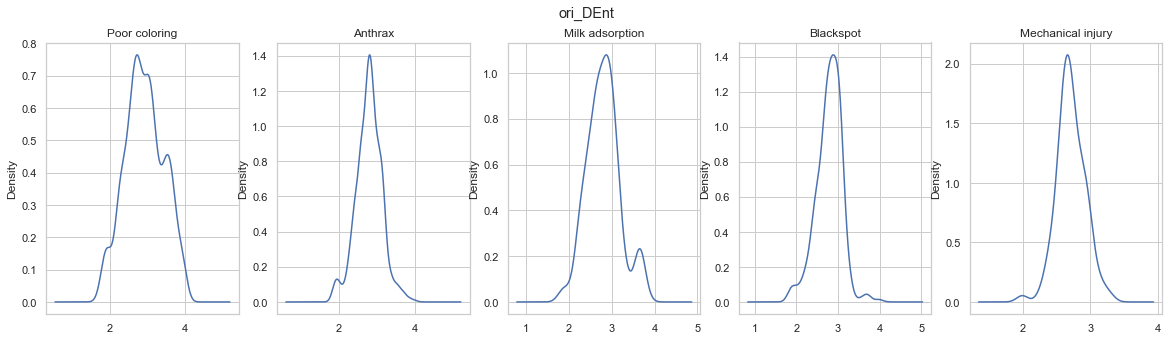

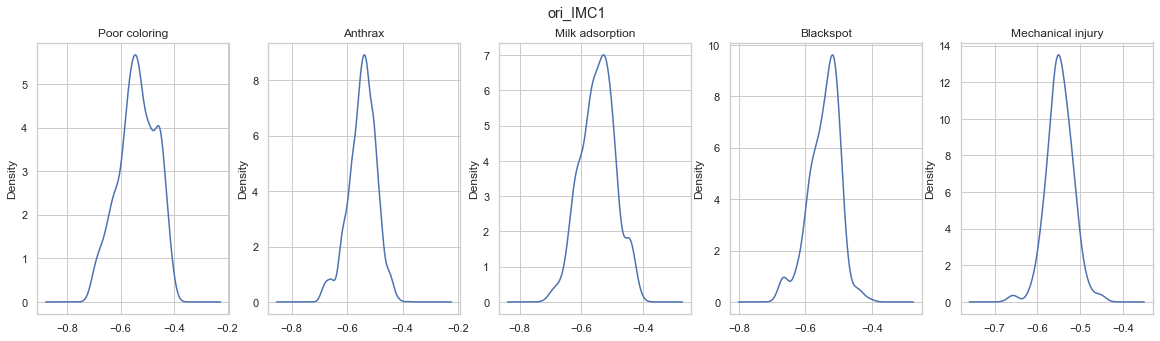

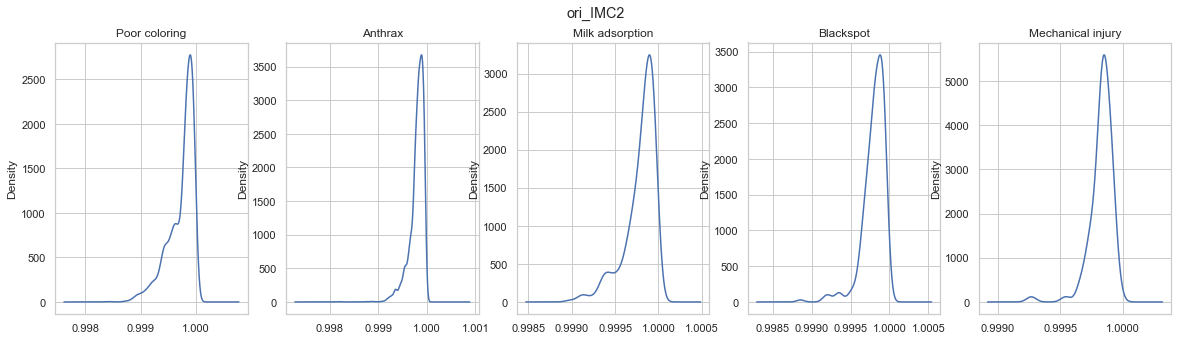

In [122]:
for feature in ori_features:
    fig, axs = plt.subplots(1,5, figsize = (20,5))
    df[df['cat'] == 0][feature].plot(kind = 'density', ax = axs[0], title ='Poor coloring')
    df[df['cat'] == 1][feature].plot(kind = 'density', ax = axs[1], title ='Anthrax')
    df[df['cat'] == 2][feature].plot(kind = 'density', ax = axs[2], title ='Milk adsorption')
    df[df['cat'] == 3][feature].plot(kind = 'density', ax = axs[3], title ='Blackspot')
    df[df['cat'] == 4][feature].plot(kind = 'density', ax = axs[4], title ='Mechanical injury')
    plt.suptitle(feature)
    plt.savefig(feature+"png")
    plt.show()

### 乳汁吸附、黑斑病、機械傷害

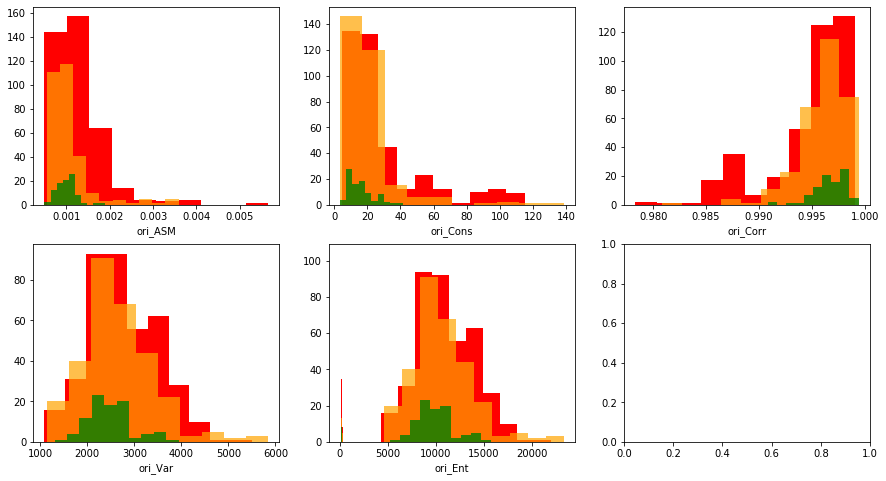

In [232]:
fig, axs = plt.subplots(2,3, figsize = (15,8))

axs[0, 0].hist(df[df['cat'] == 2]['ori_ASM'], label = 'Milk adsorption', alpha = 1, color = 'red')
axs[0, 0].hist(df[df['cat'] == 3]['ori_ASM'], label = 'Blackspot', alpha = 0.7, color = 'orange')
axs[0, 0].hist(df[df['cat'] == 4]['ori_ASM'], label = 'Mechanical injury', alpha = 0.8, color = 'green')
axs[0, 0].set(xlabel='ori_ASM')

axs[0, 1].hist(df[df['cat'] == 2]['ori_Cons'], label = 'Milk adsorption', alpha = 1, color = 'red')
axs[0, 1].hist(df[df['cat'] == 3]['ori_Cons'], label = 'Blackspot', alpha = 0.7, color = 'orange')
axs[0, 1].hist(df[df['cat'] == 4]['ori_Cons'], label = 'Mechanical injury', alpha = 0.8, color = 'green')
axs[0, 1].set(xlabel='ori_Cons')

axs[0, 2].hist(df[df['cat'] == 2]['ori_Corr'], label = 'Milk adsorption', alpha = 1, color = 'red')
axs[0, 2].hist(df[df['cat'] == 3]['ori_Corr'], label = 'Blackspot', alpha = 0.7, color = 'orange')
axs[0, 2].hist(df[df['cat'] == 4]['ori_Corr'], label = 'Mechanical injury', alpha = 0.8, color = 'green')
axs[0, 2].set(xlabel='ori_Corr')

axs[1, 0].hist(df[df['cat'] == 2]['ori_Var'], label = 'Milk adsorption', alpha = 1, color = 'red')
axs[1, 0].hist(df[df['cat'] == 3]['ori_Var'], label = 'Blackspot', alpha = 0.7, color = 'orange')
axs[1, 0].hist(df[df['cat'] == 4]['ori_Var'], label = 'Mechanical injury', alpha = 0.8, color = 'green')
axs[1, 0].set(xlabel='ori_Var')

axs[1, 1].hist(df[df['cat'] == 2]['ori_IDM'], label = 'Milk adsorption', alpha = 1, color = 'red')
axs[1, 1].hist(df[df['cat'] == 3]['ori_IDM'], label = 'Blackspot', alpha = 0.7, color = 'orange')
axs[1, 1].hist(df[df['cat'] == 4]['ori_IDM'], label = 'Mechanical injury', alpha = 0.8, color = 'green')
axs[1, 1].set(xlabel='ori_IDM')

axs[1, 1].hist(df[df['cat'] == 2]['ori_SAv'], label = 'Milk adsorption', alpha = 1, color = 'red')
axs[1, 1].hist(df[df['cat'] == 3]['ori_SAv'], label = 'Blackspot', alpha = 0.7, color = 'orange')
axs[1, 1].hist(df[df['cat'] == 4]['ori_SAv'], label = 'Mechanical injury', alpha = 0.8, color = 'green')
axs[1, 1].set(xlabel='ori_SAv')

axs[1, 1].hist(df[df['cat'] == 2]['ori_SVar'], label = 'Milk adsorption', alpha = 1, color = 'red')
axs[1, 1].hist(df[df['cat'] == 3]['ori_SVar'], label = 'Blackspot', alpha = 0.7, color = 'orange')
axs[1, 1].hist(df[df['cat'] == 4]['ori_SVar'], label = 'Mechanical injury', alpha = 0.8, color = 'green')
axs[1, 1].set(xlabel='ori_SVar')

axs[1, 1].hist(df[df['cat'] == 2]['ori_SEnt'], label = 'Milk adsorption', alpha = 1, color = 'red')
axs[1, 1].hist(df[df['cat'] == 3]['ori_SEnt'], label = 'Blackspot', alpha = 0.7, color = 'orange')
axs[1, 1].hist(df[df['cat'] == 4]['ori_SEnt'], label = 'Mechanical injury', alpha = 0.8, color = 'green')
axs[1, 1].set(xlabel='ori_SEnt')

axs[1, 1].hist(df[df['cat'] == 2]['ori_Ent'], label = 'Milk adsorption', alpha = 1, color = 'red')
axs[1, 1].hist(df[df['cat'] == 3]['ori_Ent'], label = 'Blackspot', alpha = 0.7, color = 'orange')
axs[1, 1].hist(df[df['cat'] == 4]['ori_Ent'], label = 'Mechanical injury', alpha = 0.8, color = 'green')
axs[1, 1].set(xlabel='ori_Ent')
plt.show()

# 不良部位的Hara特徵

### 著色不佳、炭疽病

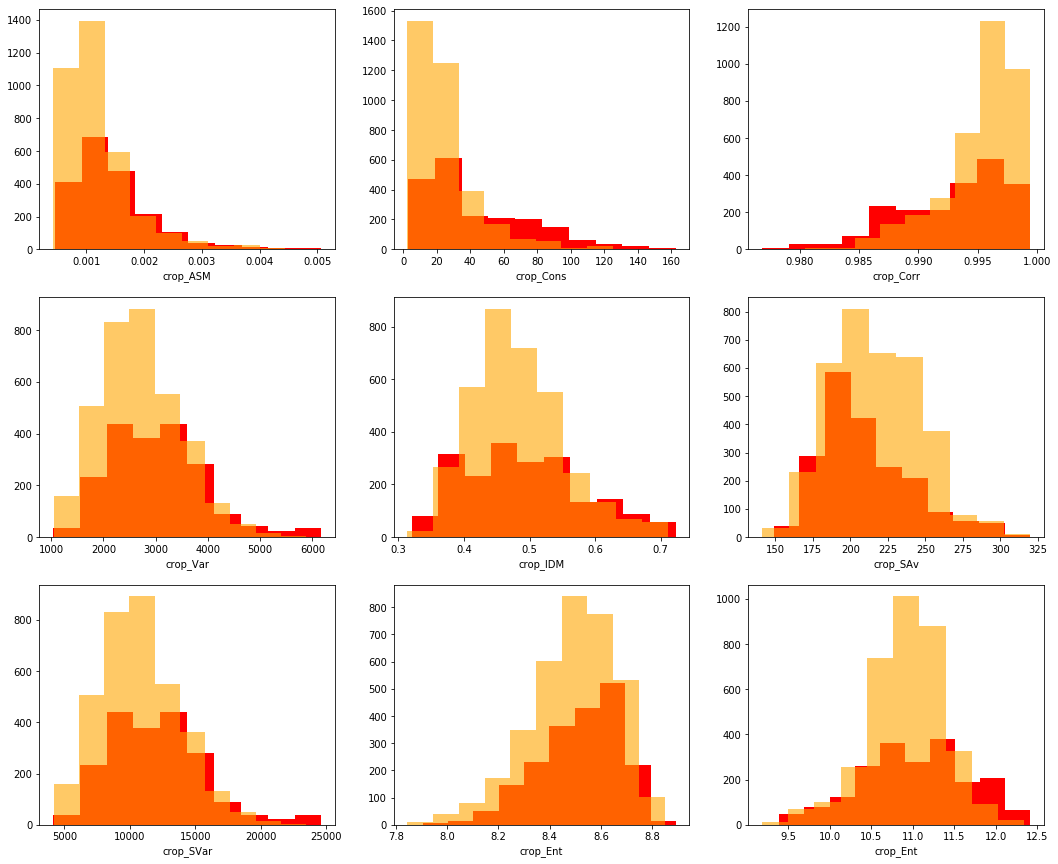

In [7]:
fig, axs = plt.subplots(3,3, figsize = (18,15))

axs[0, 0].hist(df[df['cat'] == 0]['crop_ASM'], label = 'Poor coloring', alpha = 1, color = 'red')
axs[0, 0].hist(df[df['cat'] == 1]['crop_ASM'], label = 'Anthrax', alpha = 0.6, color = 'orange')
axs[0, 0].set(xlabel='crop_ASM')

axs[0, 1].hist(df[df['cat'] == 0]['crop_Cons'], label = 'Poor coloring', alpha = 1, color = 'red')
axs[0, 1].hist(df[df['cat'] == 1]['crop_Cons'], label = 'Anthrax', alpha = 0.6, color = 'orange')
axs[0, 1].set(xlabel='crop_Cons')

axs[0, 2].hist(df[df['cat'] == 0]['crop_Corr'], label = 'Poor coloring', alpha = 1, color = 'red')
axs[0, 2].hist(df[df['cat'] == 1]['crop_Corr'], label = 'Anthrax', alpha = 0.6, color = 'orange')
axs[0, 2].set(xlabel='crop_Corr')

axs[1, 0].hist(df[df['cat'] == 0]['crop_Var'], label = 'Poor coloring', alpha = 1, color = 'red')
axs[1, 0].hist(df[df['cat'] == 1]['crop_Var'], label = 'Anthrax', alpha = 0.6, color = 'orange')
axs[1, 0].set(xlabel='crop_Var')

axs[1, 1].hist(df[df['cat'] == 0]['crop_IDM'], label = 'Poor coloring', alpha = 1, color = 'red')
axs[1, 1].hist(df[df['cat'] == 1]['crop_IDM'], label = 'Anthrax', alpha = 0.6, color = 'orange')
axs[1, 1].set(xlabel='crop_IDM')

axs[1, 2].hist(df[df['cat'] == 0]['crop_SAv'], label = 'Poor coloring', alpha = 1, color = 'red')
axs[1, 2].hist(df[df['cat'] == 1]['crop_SAv'], label = 'Anthrax', alpha = 0.6, color = 'orange')
axs[1, 2].set(xlabel='crop_SAv')

axs[2, 0].hist(df[df['cat'] == 0]['crop_SVar'], label = 'Poor coloring', alpha = 1, color = 'red')
axs[2, 0].hist(df[df['cat'] == 1]['crop_SVar'], label = 'Anthrax', alpha = 0.6, color = 'orange')
axs[2, 0].set(xlabel='crop_SVar')

axs[2, 1].hist(df[df['cat'] == 0]['crop_SEnt'], label = 'Poor coloring', alpha = 1, color = 'red')
axs[2, 1].hist(df[df['cat'] == 1]['crop_SEnt'], label = 'Anthrax', alpha = 0.6, color = 'orange')
axs[2, 1].set(xlabel='crop_Ent')

axs[2, 2].hist(df[df['cat'] == 0]['crop_Ent'], label = 'Poor coloring', alpha = 1, color = 'red')
axs[2, 2].hist(df[df['cat'] == 1]['crop_Ent'], label = 'Anthrax', alpha = 0.6, color = 'orange')
axs[2, 2].set(xlabel='crop_Ent')

plt.show()

### 乳汁吸附、黑斑病、機械傷害

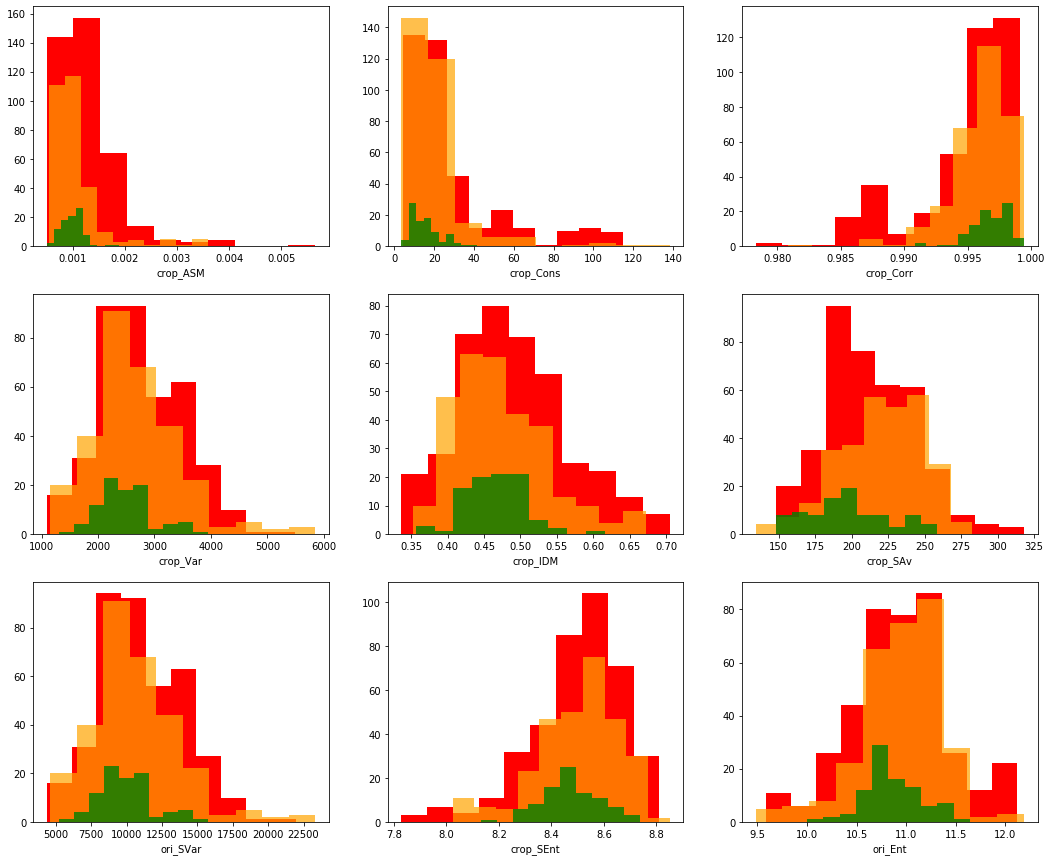

In [237]:
fig, axs = plt.subplots(3,3, figsize = (18,15))

axs[0, 0].hist(df[df['cat'] == 2]['crop_ASM'], label = 'Milk adsorption', alpha = 1, color = 'red')
axs[0, 0].hist(df[df['cat'] == 3]['crop_ASM'], label = 'Blackspot', alpha = 0.7, color = 'orange')
axs[0, 0].hist(df[df['cat'] == 4]['crop_ASM'], label = 'Mechanical injury', alpha = 0.8, color = 'green')
axs[0, 0].set(xlabel='crop_ASM')

axs[0, 1].hist(df[df['cat'] == 2]['crop_Cons'], label = 'Milk adsorption', alpha = 1, color = 'red')
axs[0, 1].hist(df[df['cat'] == 3]['crop_Cons'], label = 'Blackspot', alpha = 0.7, color = 'orange')
axs[0, 1].hist(df[df['cat'] == 4]['crop_Cons'], label = 'Mechanical injury', alpha = 0.8, color = 'green')
axs[0, 1].set(xlabel='crop_Cons')

axs[0, 2].hist(df[df['cat'] == 2]['crop_Corr'], label = 'Milk adsorption', alpha = 1, color = 'red')
axs[0, 2].hist(df[df['cat'] == 3]['crop_Corr'], label = 'Blackspot', alpha = 0.7, color = 'orange')
axs[0, 2].hist(df[df['cat'] == 4]['crop_Corr'], label = 'Mechanical injury', alpha = 0.8, color = 'green')
axs[0, 2].set(xlabel='crop_Corr')

axs[1, 0].hist(df[df['cat'] == 2]['crop_Var'], label = 'Milk adsorption', alpha = 1, color = 'red')
axs[1, 0].hist(df[df['cat'] == 3]['crop_Var'], label = 'Blackspot', alpha = 0.7, color = 'orange')
axs[1, 0].hist(df[df['cat'] == 4]['crop_Var'], label = 'Mechanical injury', alpha = 0.8, color = 'green')
axs[1, 0].set(xlabel='crop_Var')

axs[1, 1].hist(df[df['cat'] == 2]['crop_IDM'], label = 'Milk adsorption', alpha = 1, color = 'red')
axs[1, 1].hist(df[df['cat'] == 3]['crop_IDM'], label = 'Blackspot', alpha = 0.7, color = 'orange')
axs[1, 1].hist(df[df['cat'] == 4]['crop_IDM'], label = 'Mechanical injury', alpha = 0.8, color = 'green')
axs[1, 1].set(xlabel='crop_IDM')

axs[1, 2].hist(df[df['cat'] == 2]['crop_SAv'], label = 'Milk adsorption', alpha = 1, color = 'red')
axs[1, 2].hist(df[df['cat'] == 3]['crop_SAv'], label = 'Blackspot', alpha = 0.7, color = 'orange')
axs[1, 2].hist(df[df['cat'] == 4]['crop_SAv'], label = 'Mechanical injury', alpha = 0.8, color = 'green')
axs[1, 2].set(xlabel='crop_SAv')

axs[2, 0].hist(df[df['cat'] == 2]['crop_SVar'], label = 'Milk adsorption', alpha = 1, color = 'red')
axs[2, 0].hist(df[df['cat'] == 3]['crop_SVar'], label = 'Blackspot', alpha = 0.7, color = 'orange')
axs[2, 0].hist(df[df['cat'] == 4]['crop_SVar'], label = 'Mechanical injury', alpha = 0.8, color = 'green')
axs[2, 0].set(xlabel='ori_SVar')

axs[2, 1].hist(df[df['cat'] == 2]['crop_SEnt'], label = 'Milk adsorption', alpha = 1, color = 'red')
axs[2, 1].hist(df[df['cat'] == 3]['crop_SEnt'], label = 'Blackspot', alpha = 0.7, color = 'orange')
axs[2, 1].hist(df[df['cat'] == 4]['crop_SEnt'], label = 'Mechanical injury', alpha = 0.8, color = 'green')
axs[2, 1].set(xlabel='crop_SEnt')

axs[2, 2].hist(df[df['cat'] == 2]['ori_Ent'], label = 'Milk adsorption', alpha = 1, color = 'red')
axs[2, 2].hist(df[df['cat'] == 3]['ori_Ent'], label = 'Blackspot', alpha = 0.7, color = 'orange')
axs[2, 2].hist(df[df['cat'] == 4]['ori_Ent'], label = 'Mechanical injury', alpha = 0.8, color = 'green')
axs[2, 2].set(xlabel='ori_Ent')
plt.show()

# 不良處的全部特徵比較 - 鬍鬚圖

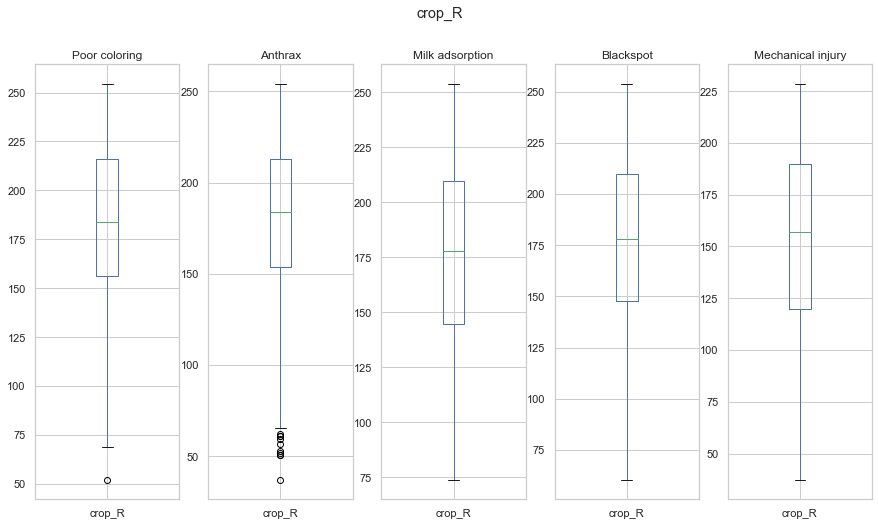

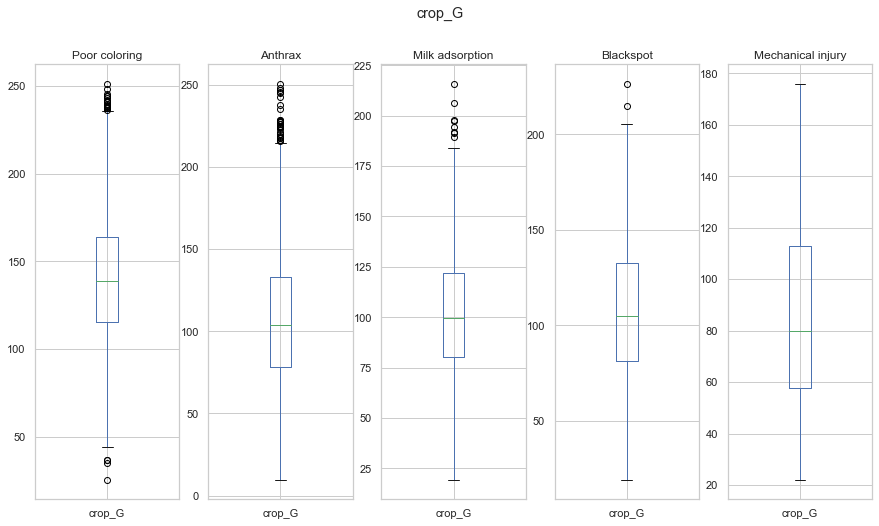

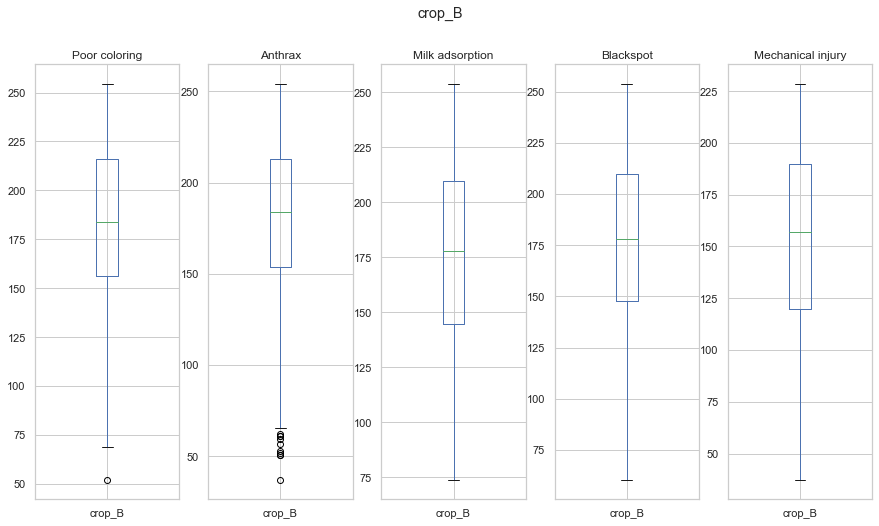

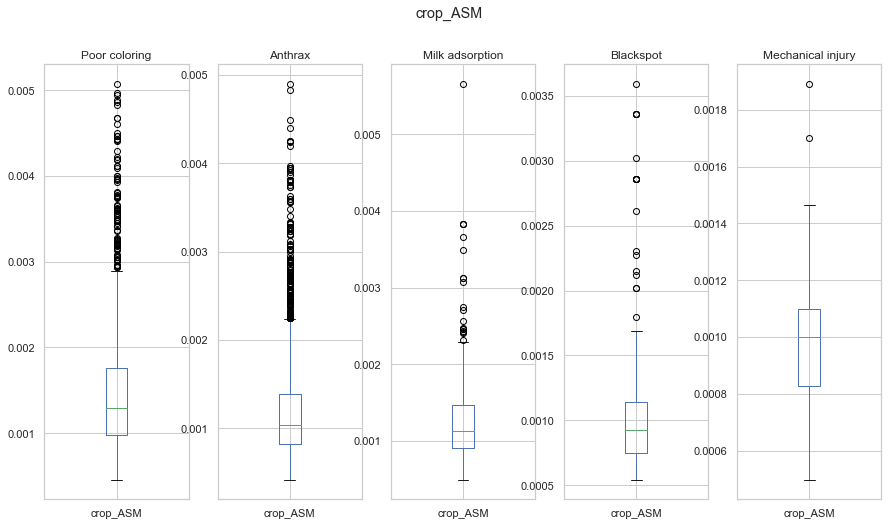

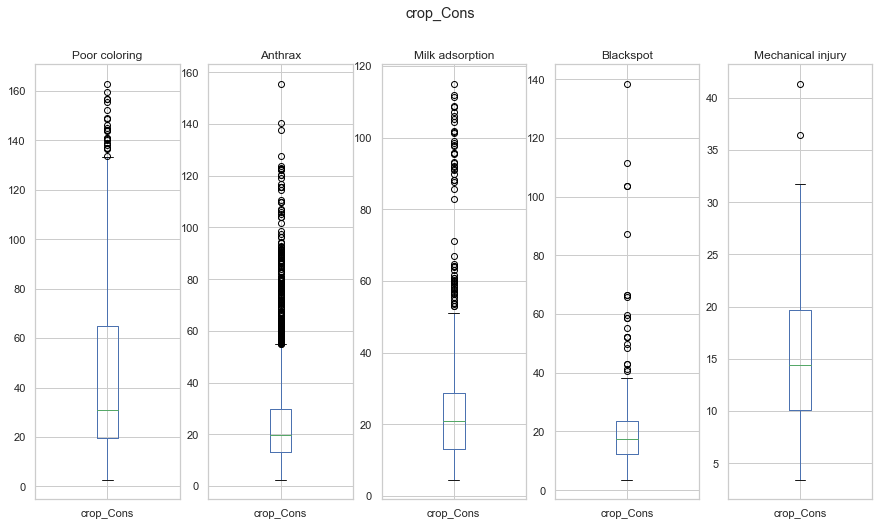

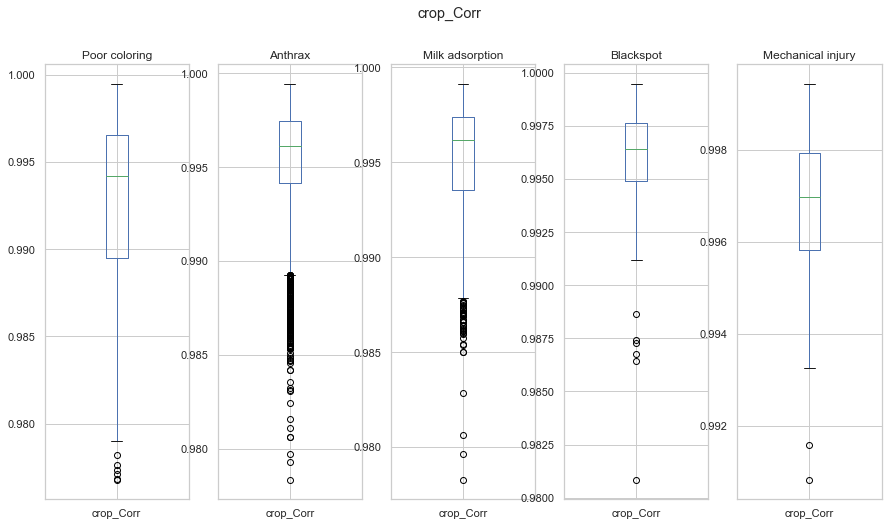

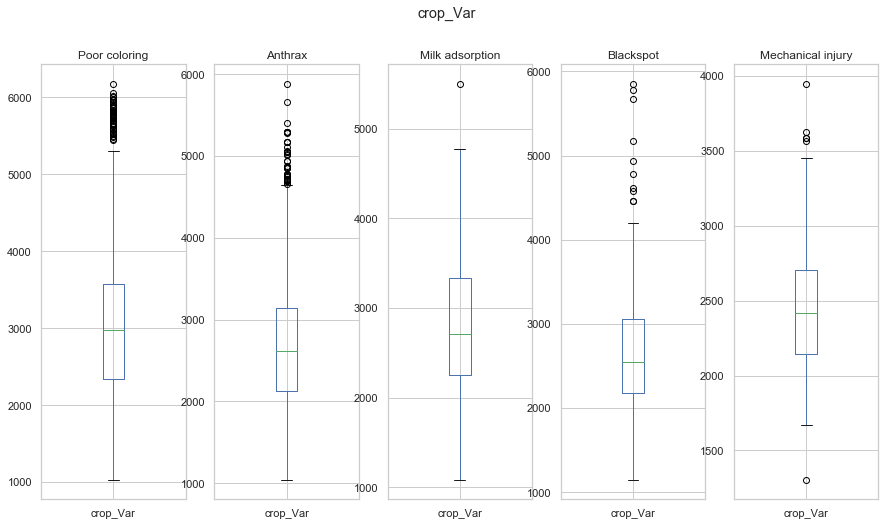

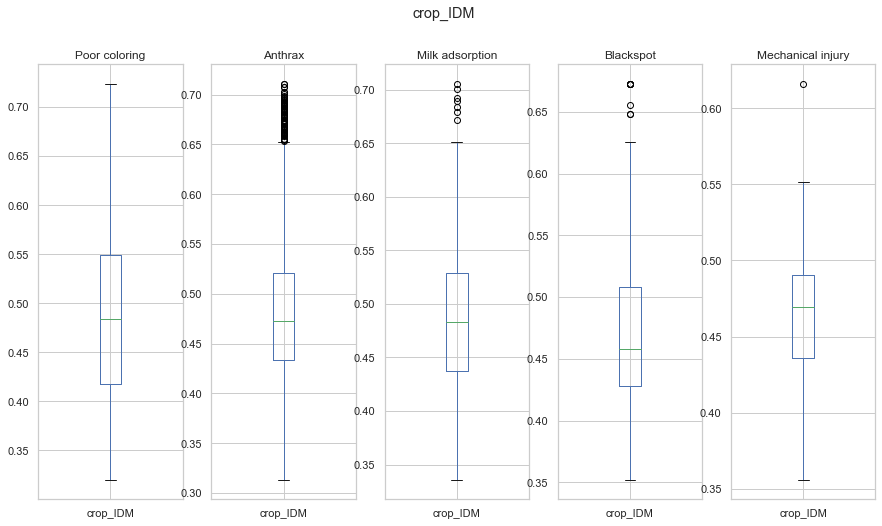

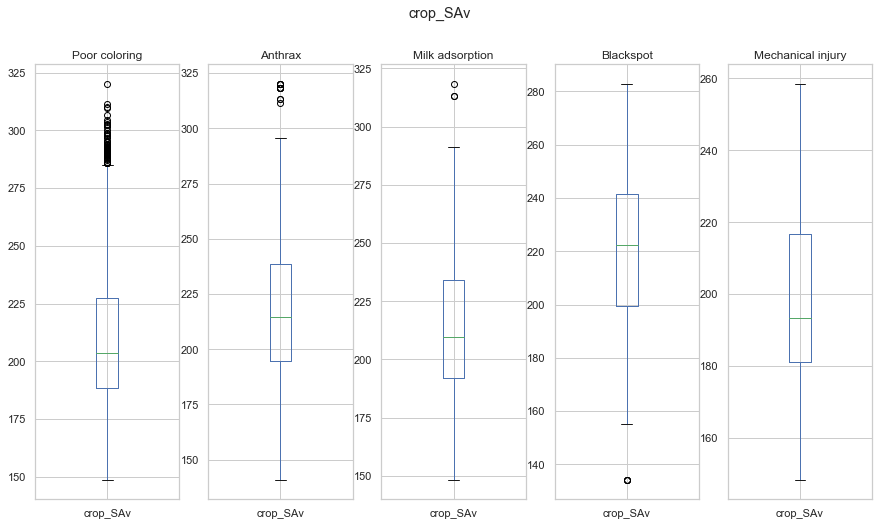

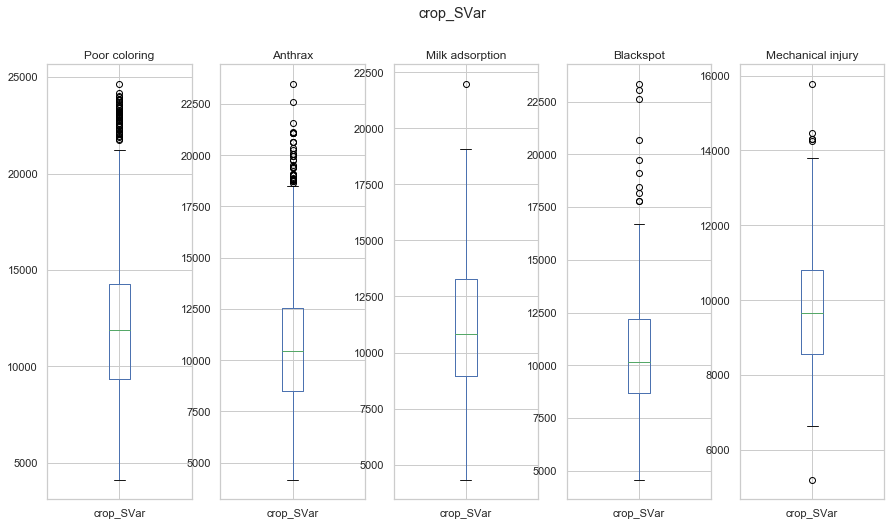

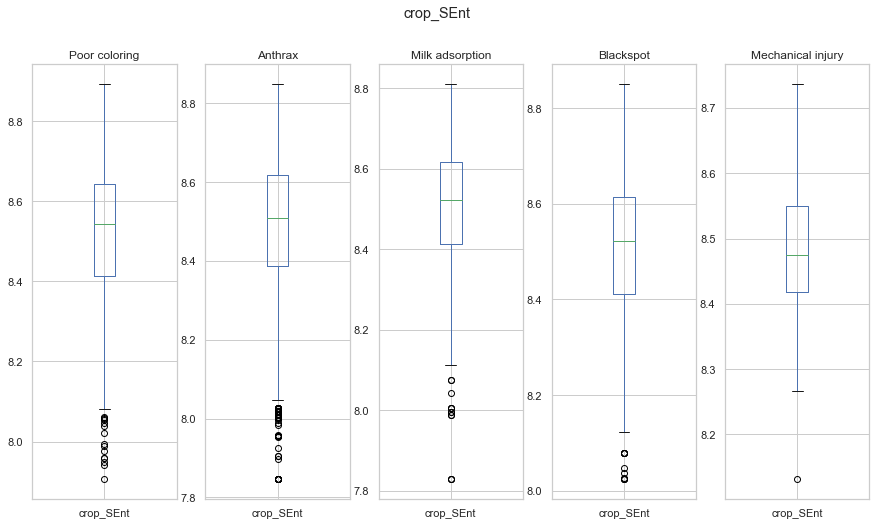

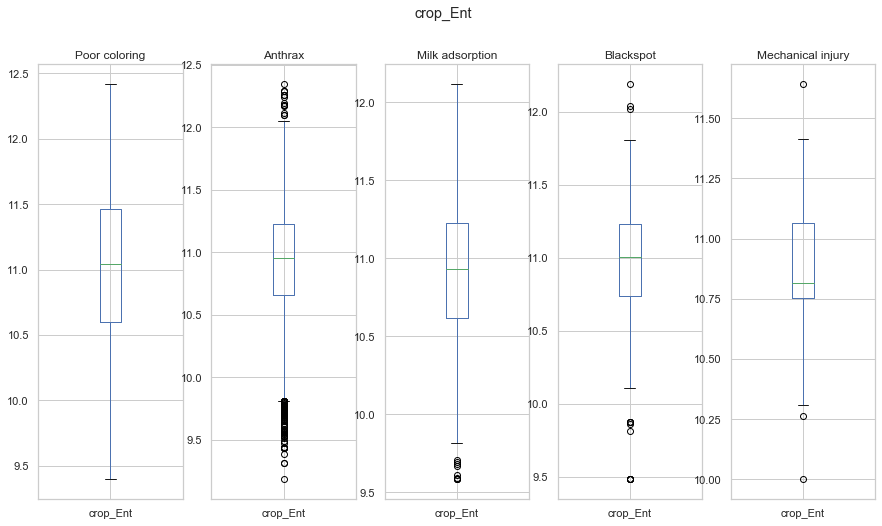

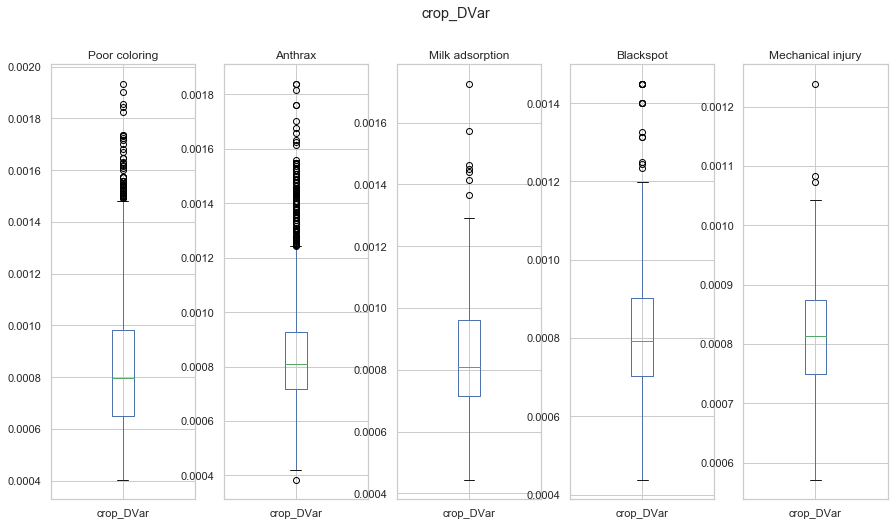

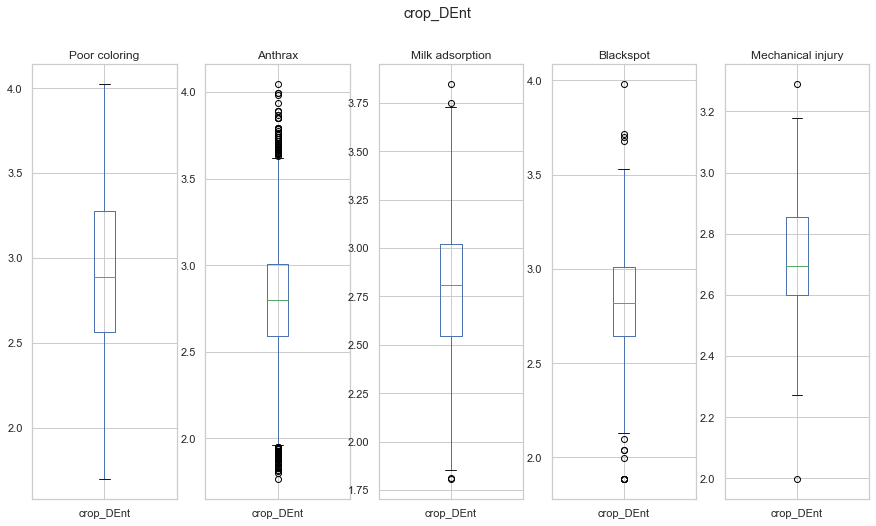

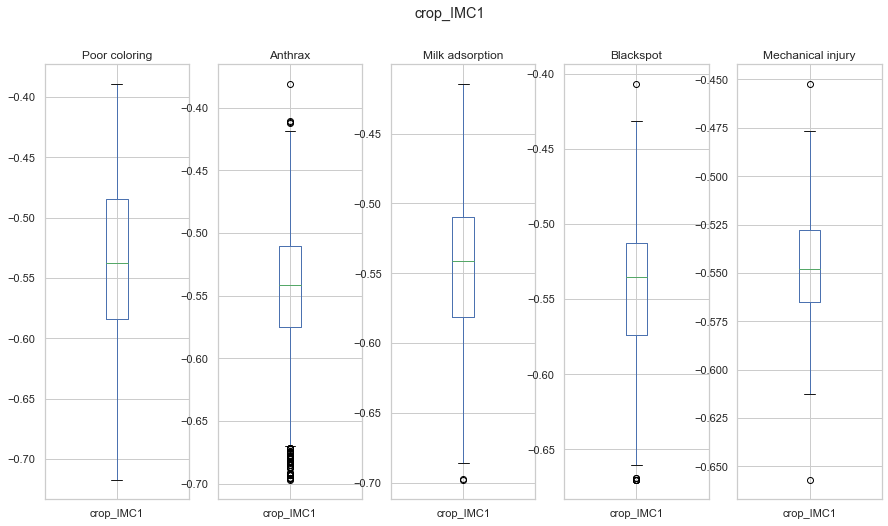

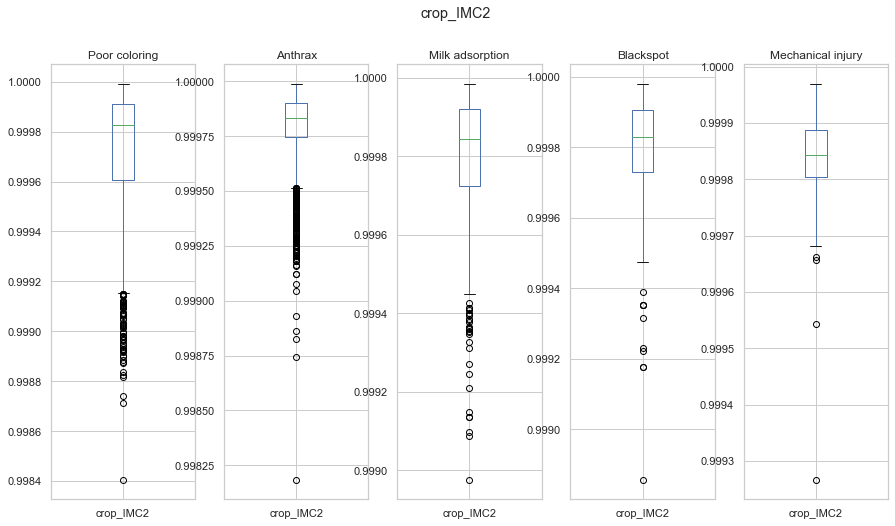

In [114]:
crop_features = ['crop_R', 'crop_G', 'crop_B', 'crop_ASM', 'crop_Cons', 'crop_Corr', 'crop_Var', 'crop_IDM', 'crop_SAv', 'crop_SVar', 'crop_SEnt', 'crop_Ent', 'crop_DVar', 'crop_DEnt', 'crop_IMC1', 'crop_IMC2']

for feature in crop_features:
    fig, axs = plt.subplots(1,5, figsize = (15,8))
    df[df['cat'] == 0][feature].plot(kind = 'box', ax = axs[0], title ='Poor coloring')
    df[df['cat'] == 1][feature].plot(kind = 'box', ax = axs[1], title ='Anthrax')
    df[df['cat'] == 2][feature].plot(kind = 'box', ax = axs[2], title ='Milk adsorption')
    df[df['cat'] == 3][feature].plot(kind = 'box', ax = axs[3], title ='Blackspot')
    df[df['cat'] == 4][feature].plot(kind = 'box', ax = axs[4], title ='Mechanical injury')
    plt.suptitle(feature)
    #plt.savefig(feature+"png")
    plt.show()

# 不良處的全部特徵比較 - 密度圖

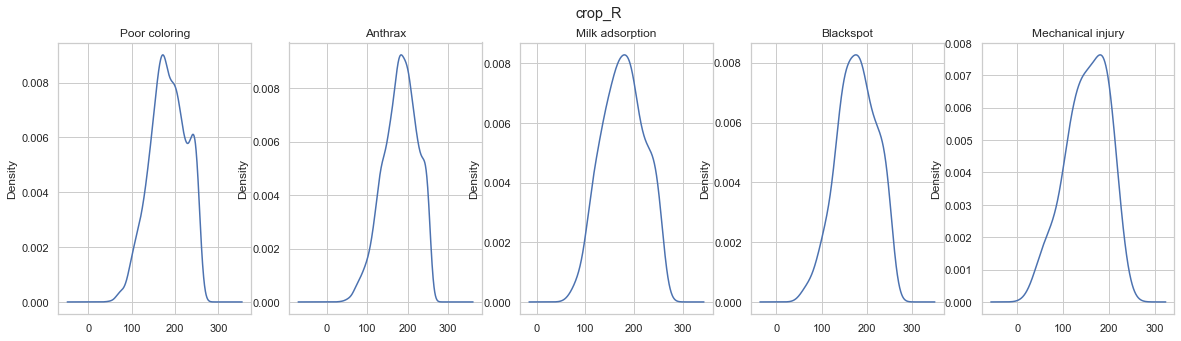

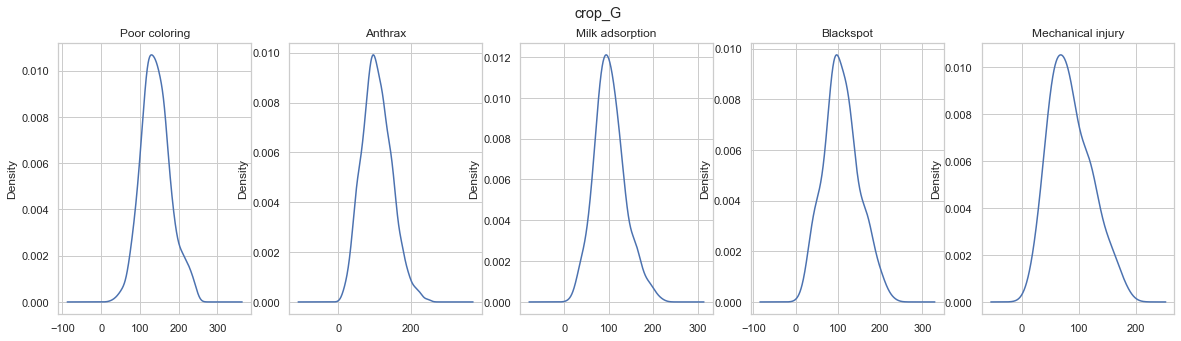

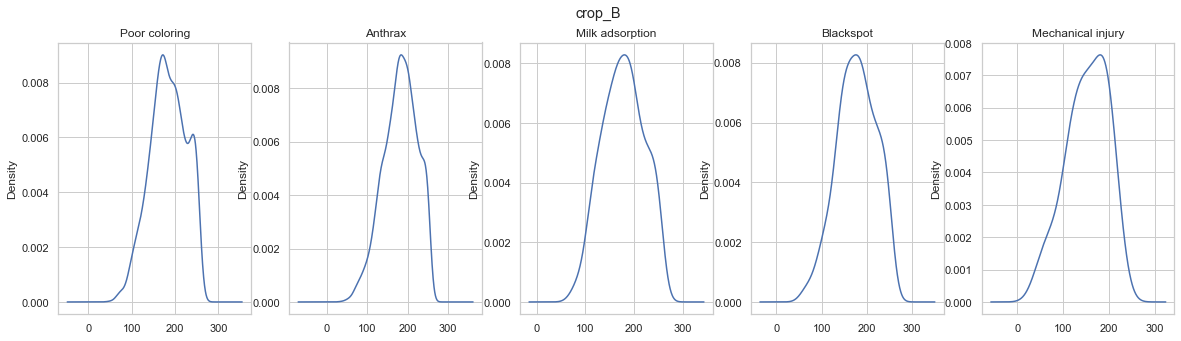

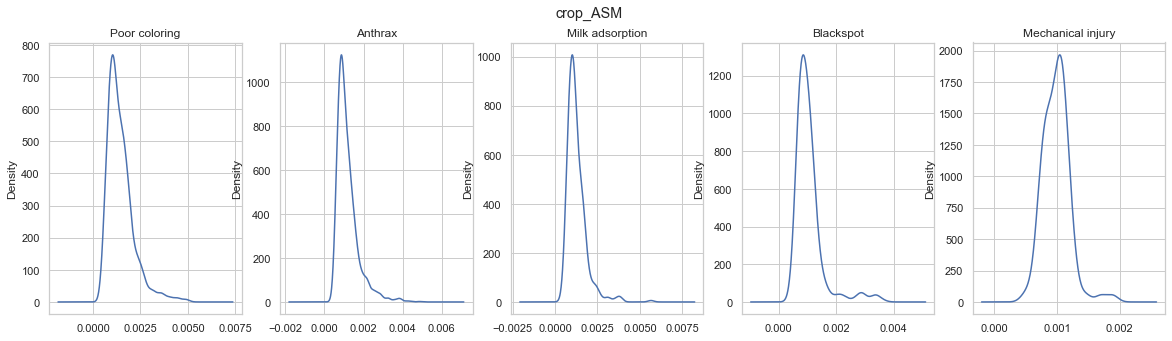

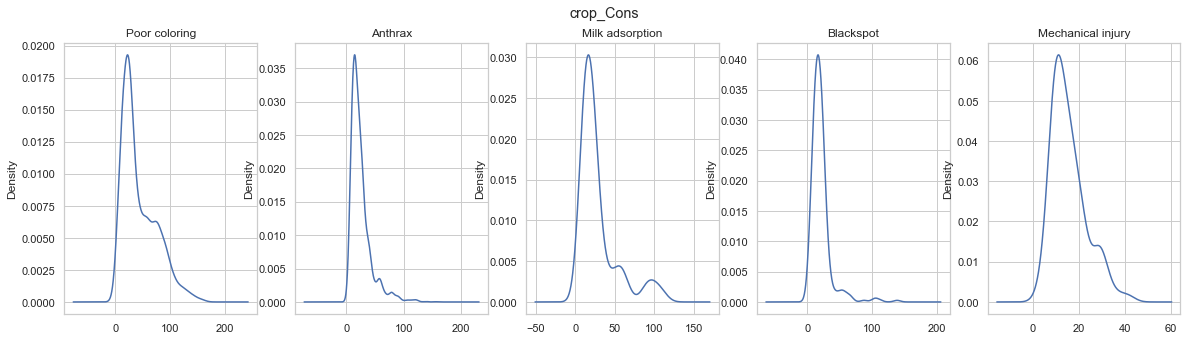

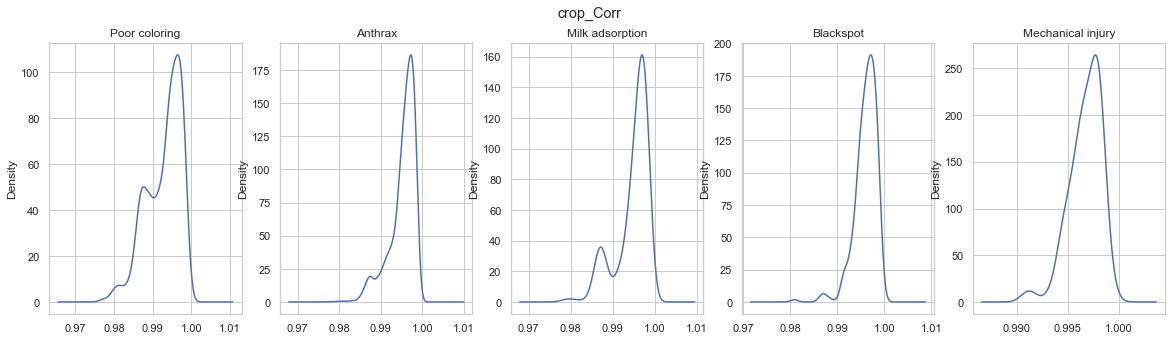

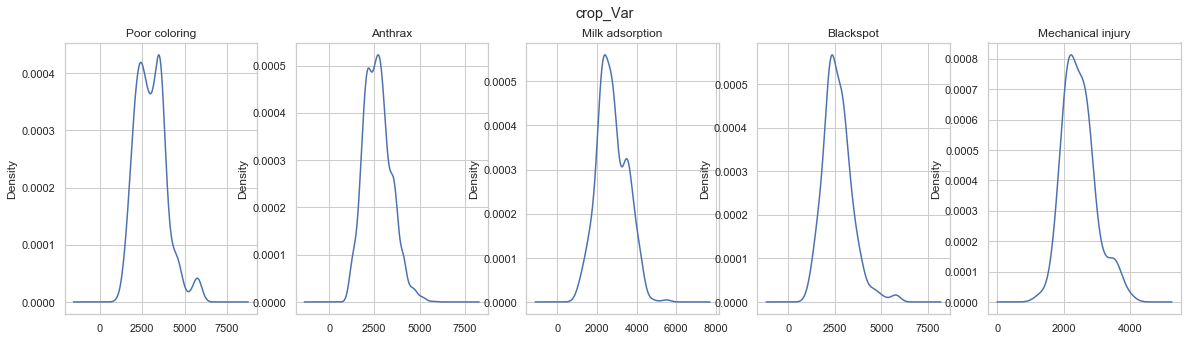

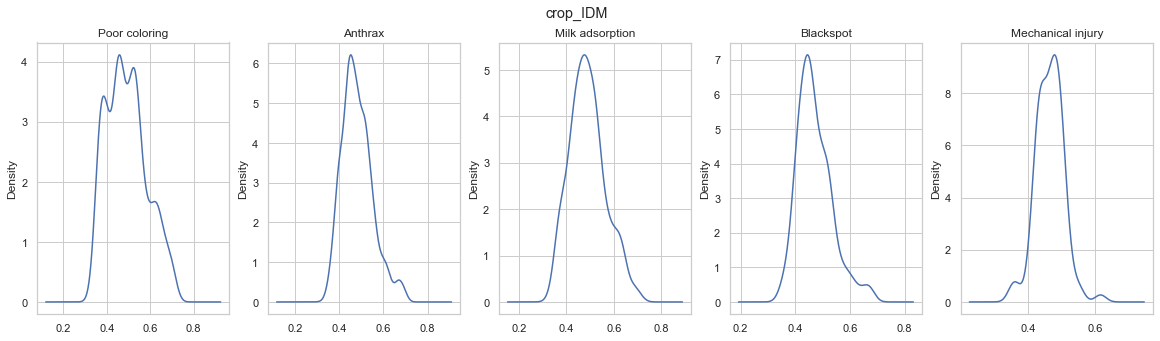

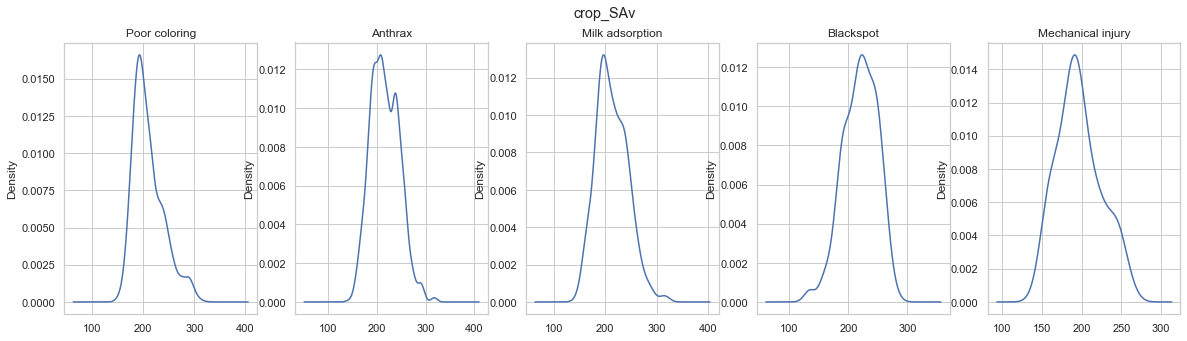

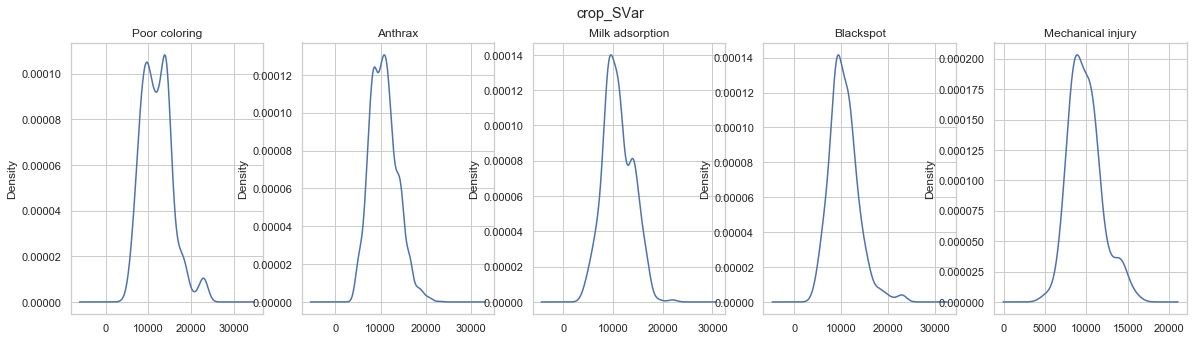

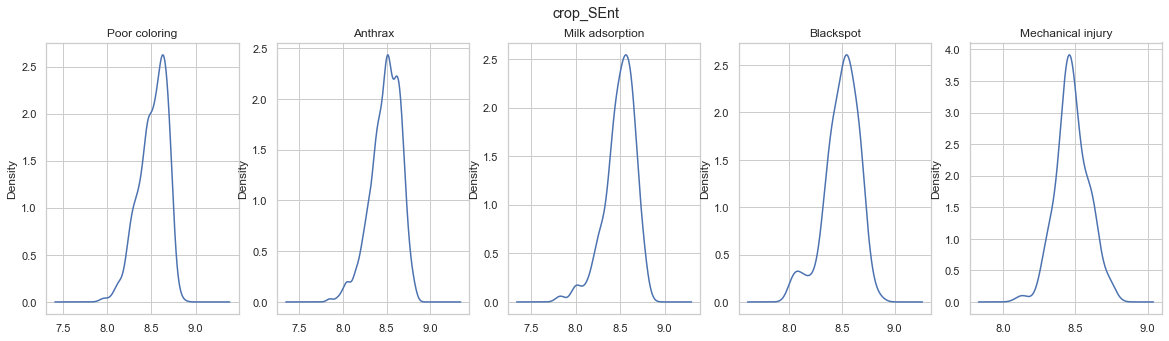

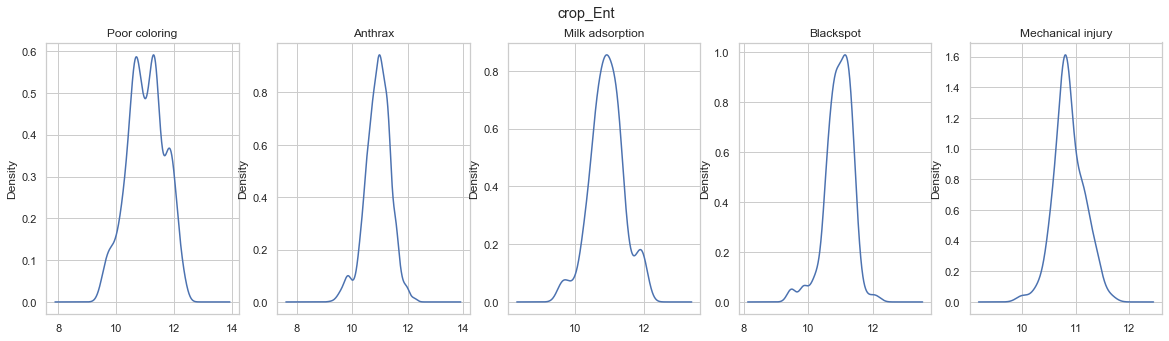

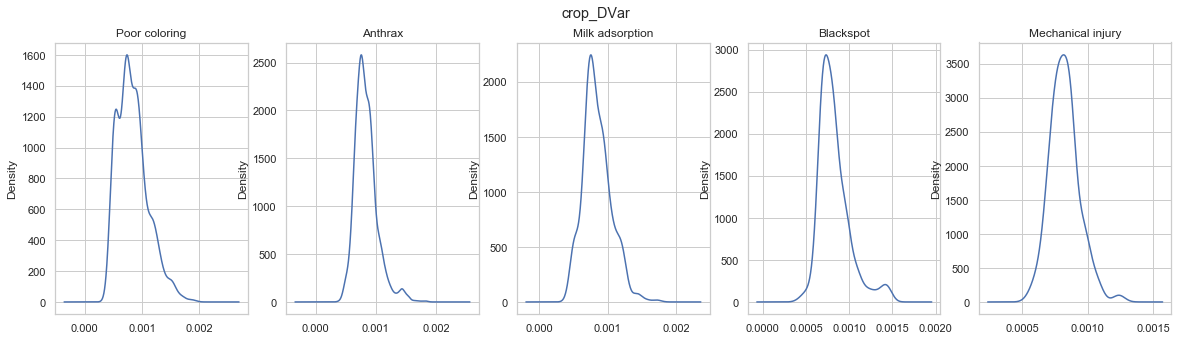

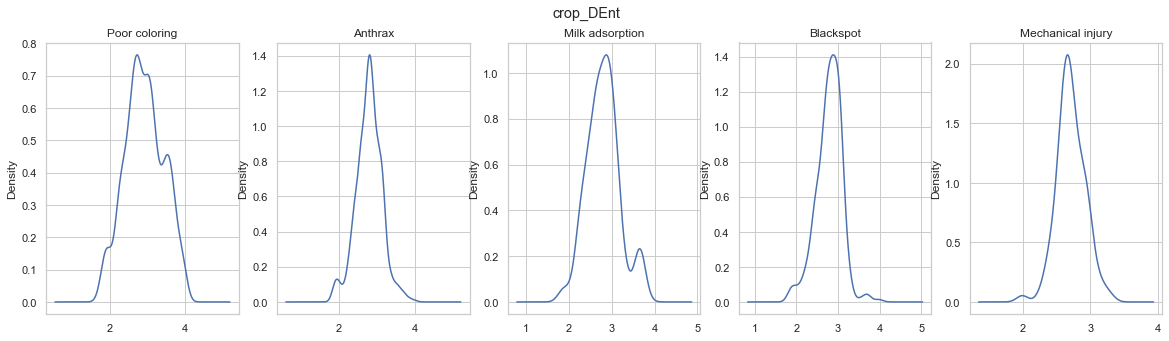

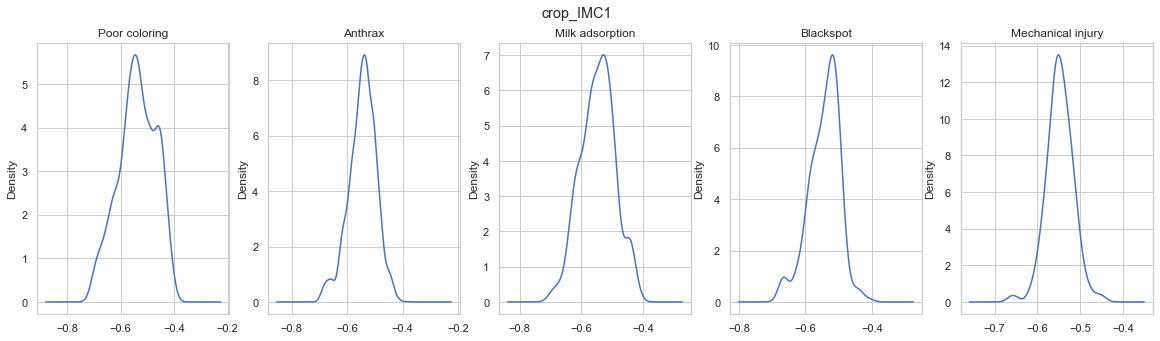

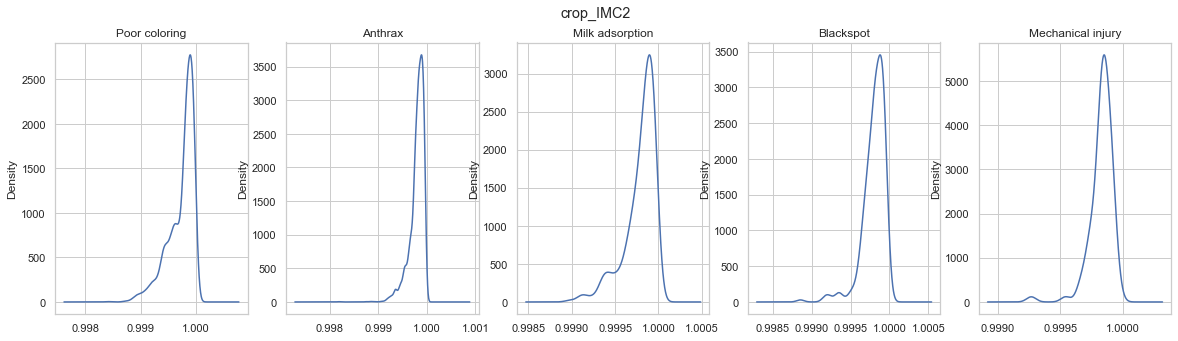

In [125]:
crop_features = ['crop_R', 'crop_G', 'crop_B', 'crop_ASM', 'crop_Cons', 'crop_Corr', 'crop_Var', 'crop_IDM', 'crop_SAv', 'crop_SVar', 'crop_SEnt', 'crop_Ent', 'crop_DVar', 'crop_DEnt', 'crop_IMC1', 'crop_IMC2']

for feature in crop_features:
    fig, axs = plt.subplots(1,5, figsize = (20,5))
    df[df['cat'] == 0][feature].plot(kind = 'density', ax = axs[0], title ='Poor coloring')
    df[df['cat'] == 1][feature].plot(kind = 'density', ax = axs[1], title ='Anthrax')
    df[df['cat'] == 2][feature].plot(kind = 'density', ax = axs[2], title ='Milk adsorption')
    df[df['cat'] == 3][feature].plot(kind = 'density', ax = axs[3], title ='Blackspot')
    df[df['cat'] == 4][feature].plot(kind = 'density', ax = axs[4], title ='Mechanical injury')
    plt.suptitle(feature)
    #plt.savefig(feature+"png")
    plt.show()

# 將資料分為Train(60%)和Test(40%)
1.特徵值共有「32個」：'ori_R','ori_G', 'ori_B', 'crop_R', 'crop_G', 'crop_B','ori_ASM', 'ori_Cons',
       'ori_Corr', 'ori_Var', 'ori_IDM', 'ori_SAv', 'ori_SVar', 'ori_SEnt',
       'ori_Ent', 'ori_DVar', 'ori_DEnt', 'ori_IMC1', 'ori_IMC2', 'crop_ASM',
       'crop_Cons', 'crop_Corr', 'crop_Var', 'crop_IDM', 'crop_SAv',
       'crop_SVar', 'crop_SEnt', 'crop_Ent', 'crop_DVar', 'crop_DEnt',
       'crop_IMC1', 'crop_IMC2'

In [15]:
#random_state為隨機數的種子，為了產生同一組隨機數
X = df[['ori_G', 'ori_B', 'crop_R','ori_ASM', 'ori_Cons',
        'ori_Corr', 'ori_Var', 'ori_IDM', 'ori_SAv', 'ori_SVar', 'ori_SEnt',
        'ori_Ent', 'ori_DVar', 'ori_DEnt', 'ori_IMC1', 'ori_IMC2','crop_R', 
        'crop_G', 'crop_B', 'crop_ASM', 'crop_Cons', 'crop_Corr', 'crop_Var',
        'crop_IDM', 'crop_SAv', 'crop_SVar', 'crop_SEnt', 'crop_Ent', 'crop_DVar',
        'crop_DEnt', 'crop_IMC1', 'crop_IMC2']]

#Lasso挑選的變數
#X = df[['ori_G', 'crop_R', 'ori_Cons', 'ori_SAv', 'ori_SVar','crop_R', 'crop_G', 'crop_B', 'crop_Cons', 'crop_SAv', 'crop_SVar']]

Y = df[['cat']]

train_X,test_X, train_Y, test_Y = train_test_split(X, Y, test_size = 0.4, random_state = 0)

# Linear Regression
1. Upsampling後的Train/Test accurancy從22.5%/22.2%上升至40%/40%

In [230]:
ln = LinearRegression().fit(train_X, train_Y)

print('Intercept: \n', ln.intercept_)
print('Coefficients: \n', ln.coef_)

print("Train Accurancy of Linear:{}".format(ln.score(train_X, train_Y)))
print("Test Accurancy of Linear:{}".format(ln.score(test_X, test_Y)))

#Cross Validation
#scores = cross_val_score(ln, train_X,  train_Y, cv=10, scoring='accuracy') #cv = 10代表分成10組
#print(scores)
#print(scores.mean())

Intercept: 
 [-23.02608987]
Coefficients: 
 [[-1.33716978e-02 -1.66634540e-03 -2.34652187e+06 -1.20952717e+05
   5.90945197e+07  1.81373219e+06 -2.19102663e+08 -3.97851323e+04
   2.01678054e+06  5.47890634e+07  2.83768780e+03 -1.51151867e+04
  -3.20898146e+02  4.26800856e+02 -1.37301601e+02  4.63923966e+00
   1.17326093e+06 -4.71919142e-03  1.17326093e+06  1.20953335e+05
   5.04831668e+07 -1.81372745e+06 -2.19208083e+08  3.97798074e+04
  -2.01678054e+06  5.47886232e+07 -2.83991723e+03  1.51168141e+04
  -3.71626377e+02 -4.27349742e+02  1.20526366e+02  1.19596220e+01]]
Train Accurancy of Linear:0.225680585546828
Test Accurancy of Linear:0.22207247660212548


# Logistic Regression
1. 如何在多類別分類中，用二元分類器進行分類https://medium.com/@chih.sheng.huang821/%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92-%E5%A6%82%E4%BD%95%E5%9C%A8%E5%A4%9A%E9%A1%9E%E5%88%A5%E5%88%86%E9%A1%9E%E5%95%8F%E9%A1%8C%E4%B8%8A%E4%BD%BF%E7%94%A8%E7%94%A8%E4%BA%8C%E5%85%83%E5%88%86%E9%A1%9E%E5%99%A8%E9%80%B2%E8%A1%8C%E5%88%86%E9%A1%9E-multiclass-strategy-for-binary-classifier-b4e5017202ff
2. 如果是用SVM，OAO對於類別樣本數大小差距懸殊的分類問題可以得到較好的結果，OAA在這種問題上比較不好，最大原因是樣本數少的那類在training過程中可能會因為樣本數大的類別比重較重，在訓練過程中被犧牲掉了
3. OAO = One against One = 一對一 = pairwise
4. OAA = One against All = 一對全部 = 一對剩下 = One vs Rest
5. Upsampling後的Train/Test accurancy從69.56%/71.06%下降至46%

In [301]:
logis = LogisticRegression(multi_class = 'ovr').fit(train_X, train_Y)
print("預測結果：",logis.predict(test_X))

print("Train Accurancy of Linear:{}".format(logis.score(train_X, train_Y)))
print("Test Accurancy of Linear:{}".format(logis.score(test_X, test_Y)))

scores = cross_val_score(logis, train_X,  train_Y, cv=10, scoring='accuracy')
print(scores)
print(scores.mean())

y_true = test_Y
y_pred = logis.predict(test_X)

y_true = y_true.to_numpy()
print('*****the following is true data*****')

#print(len(y_true))
print(len(y_true[y_true == 0])) #著色不佳
print(len(y_true[y_true == 1])) #炭疽病
print(len(y_true[y_true == 2])) #乳汁吸附
print(len(y_true[y_true == 3])) #黑斑病
print(len(y_true[y_true == 4])) #機械傷害

print('*****the following is predict data*****')
#print(len(y_pred))
print(len(y_pred[y_pred == 0]))
print(len(y_pred[y_pred == 1]))
print(len(y_pred[y_pred == 2]))
print(len(y_pred[y_pred == 3]))
print(len(y_pred[y_pred == 4]))

C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number

預測結果： [3 4 2 ... 3 3 0]
Train Accurancy of Linear:0.4338850837138508
Test Accurancy of Linear:0.4317922374429224


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

[0.43250951 0.40304183 0.42435775 0.4262607  0.4490961  0.44433873
 0.43196955 0.4452902  0.43672693 0.43196955]
0.4325560845546338
*****the following is true data*****
1383
1381
1429
1450
1365
*****the following is predict data*****
1947
874
805
1496
1886


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


# 資料正規化

In [16]:
sc = MinMaxScaler()

train_X_s = sc.fit_transform(train_X)
train_Y_s = sc.fit_transform(train_Y)

test_X_s = sc.fit_transform(test_X)
test_Y_s = sc.fit_transform(test_Y)

# GAM
1. GAM為「廣義加法模型(Generalized additive models)」，可將各種非線性與線性函數加起來，也可把交互作用放進來
2. GAM可支援Lasso
3. 模型要多複雜，可以用ANOVA來決定
4. 係數不是重點，重點是如何配適出適合的模型
5. Upsampling後的Train/Test accurancy從31.97%/32.1%上升至38.9%/37.4%
https://kknews.cc/zh-tw/code/nrvkka3.html
https://pygam.readthedocs.io/en/latest/notebooks/quick_start.html

In [19]:
gam = LogisticGAM().fit(train_X, train_Y_s)
print(gam.summary())

print("Train Accurancy of Linear:{}".format(gam.accuracy(train_X, train_Y_s)))
print("Test Accurancy of Linear:{}".format(gam.accuracy(test_X, test_Y_s)))


C:\Users\tsaiy\anaconda3\lib\site-packages\pygam\pygam.py:1112: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
C:\Users\tsaiy\anaconda3\lib\site-packages\pygam\pygam.py:1113: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden_adj'] = 1. - (full_ll - self.statistics_['edof'])/null_ll
<ipython-input-19-440bd49e11a7>:2: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                    171.8477
Link Function:                        LogitLink Log Likelihood:                                       -inf
Number of Samples:                         3768 AIC:                                                   inf
                                                AICc:                                                  inf
                                                UBRE:                                                2.333
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2992
Feature Function                  Lam

# Ridge和Lasso
1. Ridge：Upsampling後的Train/Test accurancy從22.25%/22.05%上升至38.0%/37.7%
2. Lasso：Upsampling後的Train/Test accurancy從15.8%/16.5%上升至27%/27%

In [308]:
ridge = Ridge(alpha = 1)
lasso = Lasso(alpha = 1)
ridge.fit(train_X, train_Y)
lasso.fit(train_X, train_Y)

ridge.predict(train_X)
lasso.predict(train_X)

#模型精確度
print("Train Accurancy of Ridge:{}".format(ridge.score(train_X, train_Y)))
print("Test Accurancy of Ridge:{}".format(ridge.score(test_X, test_Y)))

print("Accurancy of Lasso:{}".format(lasso.score(train_X, train_Y)))
print("Accurancy of Lasso:{}".format(lasso.score(test_X, test_Y)))

Train Accurancy of Ridge:0.3839471696973228
Test Accurancy of Ridge:0.3780801535194316


ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

### Lasso挑出的變數(True)

In [225]:
print(lasso.coef_ == 0)
print(lasso.intercept_)

[False False  True  True False  True  True  True False False  True  True
  True  True  True  True  True False  True  True False  True  True  True
 False False  True  True  True  True  True  True]
[4.25489839]


# SVM
1. 分為OVR和OVO(一對多和一對一)，python預設的decision_function_shape為ovr
2. 使用GridSearchCV挑選最適合的參數http://psop-blog.logdown.com/posts/3150995-python-machine-learning-svm(好像原本的就不錯了)
3. kernel的種類：linear, polynomial, Gaussian RBF
https://medium.com/@chih.sheng.huang821/%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92-kernel-%E5%87%BD%E6%95%B8-47c94095171
4. Upsampling後的Train/Test accurancy從100%/55.7%上升至100%/92.4%,經CV檢驗後的Train accurancy在91.9%左右

In [268]:
svm = SVC(kernel = 'rbf',C = 5, gamma='auto')
svm.fit(train_X, train_Y.astype('int'))

print("Train Accurancy of SVM:{}".format(svm.score(train_X, train_Y.astype('int'))))
print("Test Accurancy of SVM:{}".format(svm.score(test_X, test_Y.astype('int'))))

scores = cross_val_score(svm, train_X,  train_Y, cv=10, scoring='accuracy')
print(scores)
print(scores.mean())

C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Accurancy of SVM:1.0
Test Accurancy of SVM:0.9319349315068494


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

[0.9230038  0.9134981  0.92293054 0.93434824 0.92102759 0.91056137
 0.905804   0.92768792 0.905804   0.92673644]
0.9191401996288164


## SVM預測細節

In [247]:
######################################Train#####################################################
y_true = train_Y
y_pred = svm.predict(train_X)

y_true = y_true.to_numpy()
print('*****the following is true data(Train)*****')

#print(len(y_true))
print(len(y_true[y_true == 0])) #著色不佳
print(len(y_true[y_true == 1])) #炭疽病
print(len(y_true[y_true == 2])) #乳汁吸附
print(len(y_true[y_true == 3])) #黑斑病
print(len(y_true[y_true == 4])) #機械傷害

print('*****the following is predict data(Train)*****')
#print(len(y_pred))
print(len(y_pred[y_pred == 0]))
print(len(y_pred[y_pred == 1]))
print(len(y_pred[y_pred == 2]))
print(len(y_pred[y_pred == 3]))
print(len(y_pred[y_pred == 4]))

######################################Test#######################################################
y_true = test_Y
y_pred = svm.predict(test_X)

y_true = y_true.to_numpy()
print('*****the following is true data(Test)*****')

#print(len(y_true))
print(len(y_true[y_true == 0])) #著色不佳
print(len(y_true[y_true == 1])) #炭疽病
print(len(y_true[y_true == 2])) #乳汁吸附
print(len(y_true[y_true == 3])) #黑斑病
print(len(y_true[y_true == 4])) #機械傷害

print('*****the following is predict data(Test)*****')
#print(len(y_pred))
print(len(y_pred[y_pred == 0]))
print(len(y_pred[y_pred == 1]))
print(len(y_pred[y_pred == 2]))
print(len(y_pred[y_pred == 3]))
print(len(y_pred[y_pred == 4]))

*****the following is true data(Train)*****
2121
2123
2075
2054
2139
*****the following is predict data(Train)*****
2121
2123
2075
2054
2139
*****the following is true data(Test)*****
1383
1381
1429
1450
1365
*****the following is predict data(Test)*****
911
1853
1429
1450
1365


# GridSearchCV找最佳參數

In [66]:
#GridSearchCV是建立一個dictionary來組合要測試的參數
param_grid = {'C':[0.1,1,10,100,1000],'gamma':[1,0.1,0.01,0.001,0.0001]}

#GridSearchCV算是一個meta-estimator，參數中帶有estimator，像是SVC，重點是會創造一個新的estimator，但又表現的一模一樣。也就是estimator=SVC時，就是作為分類器
#Verbose可設定為任一整數，它只是代表數字越高，文字解釋越多
grid = GridSearchCV(SVC(),param_grid,verbose=3)

#利用剛剛設定的參數來找到最適合的模型
grid.fit(train_X,train_Y.astype('int'))

#顯示最佳參數組合
grid.best_params_

#顯示最佳estimator參數
grid.best_estimator_

#利用剛剛的最佳參數再重新預測測試組
grid_pred = grid.predict(test_X)

#原本的模型預測結果
#y_pred = svm.predict(test_X)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1 ..................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...................... C=0.1, gamma=1, score=0.557, total=   1.3s
[CV] C=0.1, gamma=1 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...................... C=0.1, gamma=1, score=0.557, total=   1.3s
[CV] C=0.1, gamma=1 ..................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...................... C=0.1, gamma=1, score=0.557, total=   1.3s
[CV] C=0.1, gamma=1 ..................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...................... C=0.1, gamma=1, score=0.558, total=   1.3s
[CV] C=0.1, gamma=1 ..................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...................... C=0.1, gamma=1, score=0.558, total=   1.3s
[CV] C=0.1, gamma=0.1 ................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................... C=0.1, gamma=0.1, score=0.557, total=   1.2s
[CV] C=0.1, gamma=0.1 ................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................... C=0.1, gamma=0.1, score=0.557, total=   1.3s
[CV] C=0.1, gamma=0.1 ................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................... C=0.1, gamma=0.1, score=0.557, total=   1.3s
[CV] C=0.1, gamma=0.1 ................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................... C=0.1, gamma=0.1, score=0.558, total=   1.3s
[CV] C=0.1, gamma=0.1 ................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................... C=0.1, gamma=0.1, score=0.558, total=   1.3s
[CV] C=0.1, gamma=0.01 ...............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................... C=0.1, gamma=0.01, score=0.557, total=   1.3s
[CV] C=0.1, gamma=0.01 ...............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................... C=0.1, gamma=0.01, score=0.557, total=   1.3s
[CV] C=0.1, gamma=0.01 ...............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................... C=0.1, gamma=0.01, score=0.557, total=   1.3s
[CV] C=0.1, gamma=0.01 ...............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................... C=0.1, gamma=0.01, score=0.558, total=   1.3s
[CV] C=0.1, gamma=0.01 ...............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................... C=0.1, gamma=0.01, score=0.558, total=   1.3s
[CV] C=0.1, gamma=0.001 ..............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................. C=0.1, gamma=0.001, score=0.557, total=   1.2s
[CV] C=0.1, gamma=0.001 ..............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................. C=0.1, gamma=0.001, score=0.557, total=   1.2s
[CV] C=0.1, gamma=0.001 ..............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................. C=0.1, gamma=0.001, score=0.557, total=   1.2s
[CV] C=0.1, gamma=0.001 ..............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................. C=0.1, gamma=0.001, score=0.558, total=   1.2s
[CV] C=0.1, gamma=0.001 ..............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................. C=0.1, gamma=0.001, score=0.558, total=   1.2s
[CV] C=0.1, gamma=0.0001 .............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................. C=0.1, gamma=0.0001, score=0.557, total=   0.8s
[CV] C=0.1, gamma=0.0001 .............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................. C=0.1, gamma=0.0001, score=0.557, total=   0.8s
[CV] C=0.1, gamma=0.0001 .............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................. C=0.1, gamma=0.0001, score=0.557, total=   0.8s
[CV] C=0.1, gamma=0.0001 .............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................. C=0.1, gamma=0.0001, score=0.558, total=   0.8s
[CV] C=0.1, gamma=0.0001 .............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................. C=0.1, gamma=0.0001, score=0.558, total=   0.8s
[CV] C=1, gamma=1 ....................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........................ C=1, gamma=1, score=0.557, total=   1.3s
[CV] C=1, gamma=1 ....................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........................ C=1, gamma=1, score=0.557, total=   1.3s
[CV] C=1, gamma=1 ....................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........................ C=1, gamma=1, score=0.557, total=   1.3s
[CV] C=1, gamma=1 ....................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........................ C=1, gamma=1, score=0.558, total=   1.3s
[CV] C=1, gamma=1 ....................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........................ C=1, gamma=1, score=0.558, total=   1.3s
[CV] C=1, gamma=0.1 ..................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...................... C=1, gamma=0.1, score=0.557, total=   1.4s
[CV] C=1, gamma=0.1 ..................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...................... C=1, gamma=0.1, score=0.557, total=   1.4s
[CV] C=1, gamma=0.1 ..................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...................... C=1, gamma=0.1, score=0.557, total=   1.4s
[CV] C=1, gamma=0.1 ..................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...................... C=1, gamma=0.1, score=0.558, total=   1.4s
[CV] C=1, gamma=0.1 ..................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...................... C=1, gamma=0.1, score=0.558, total=   1.4s
[CV] C=1, gamma=0.01 .................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................... C=1, gamma=0.01, score=0.556, total=   1.4s
[CV] C=1, gamma=0.01 .................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................... C=1, gamma=0.01, score=0.560, total=   1.4s
[CV] C=1, gamma=0.01 .................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................... C=1, gamma=0.01, score=0.557, total=   1.4s
[CV] C=1, gamma=0.01 .................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................... C=1, gamma=0.01, score=0.560, total=   1.4s
[CV] C=1, gamma=0.01 .................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................... C=1, gamma=0.01, score=0.556, total=   1.4s
[CV] C=1, gamma=0.001 ................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................... C=1, gamma=0.001, score=0.570, total=   1.3s
[CV] C=1, gamma=0.001 ................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................... C=1, gamma=0.001, score=0.577, total=   1.3s
[CV] C=1, gamma=0.001 ................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................... C=1, gamma=0.001, score=0.568, total=   1.3s
[CV] C=1, gamma=0.001 ................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................... C=1, gamma=0.001, score=0.567, total=   1.3s
[CV] C=1, gamma=0.001 ................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................... C=1, gamma=0.001, score=0.571, total=   1.3s
[CV] C=1, gamma=0.0001 ...............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................... C=1, gamma=0.0001, score=0.618, total=   0.8s
[CV] C=1, gamma=0.0001 ...............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................... C=1, gamma=0.0001, score=0.643, total=   0.8s
[CV] C=1, gamma=0.0001 ...............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................... C=1, gamma=0.0001, score=0.638, total=   0.8s
[CV] C=1, gamma=0.0001 ...............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................... C=1, gamma=0.0001, score=0.647, total=   0.8s
[CV] C=1, gamma=0.0001 ...............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................... C=1, gamma=0.0001, score=0.625, total=   0.9s
[CV] C=10, gamma=1 ...................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....................... C=10, gamma=1, score=0.557, total=   1.4s
[CV] C=10, gamma=1 ...................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....................... C=10, gamma=1, score=0.557, total=   1.4s
[CV] C=10, gamma=1 ...................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....................... C=10, gamma=1, score=0.557, total=   1.4s
[CV] C=10, gamma=1 ...................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....................... C=10, gamma=1, score=0.558, total=   1.4s
[CV] C=10, gamma=1 ...................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....................... C=10, gamma=1, score=0.558, total=   1.4s
[CV] C=10, gamma=0.1 .................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................... C=10, gamma=0.1, score=0.557, total=   1.4s
[CV] C=10, gamma=0.1 .................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................... C=10, gamma=0.1, score=0.558, total=   1.4s
[CV] C=10, gamma=0.1 .................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................... C=10, gamma=0.1, score=0.558, total=   1.4s
[CV] C=10, gamma=0.1 .................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................... C=10, gamma=0.1, score=0.558, total=   1.4s
[CV] C=10, gamma=0.1 .................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................... C=10, gamma=0.1, score=0.560, total=   1.4s
[CV] C=10, gamma=0.01 ................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................... C=10, gamma=0.01, score=0.553, total=   1.4s
[CV] C=10, gamma=0.01 ................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................... C=10, gamma=0.01, score=0.566, total=   1.4s
[CV] C=10, gamma=0.01 ................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................... C=10, gamma=0.01, score=0.557, total=   1.4s
[CV] C=10, gamma=0.01 ................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................... C=10, gamma=0.01, score=0.562, total=   1.4s
[CV] C=10, gamma=0.01 ................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................... C=10, gamma=0.01, score=0.556, total=   1.4s
[CV] C=10, gamma=0.001 ...............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................... C=10, gamma=0.001, score=0.577, total=   1.3s
[CV] C=10, gamma=0.001 ...............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................... C=10, gamma=0.001, score=0.582, total=   1.3s
[CV] C=10, gamma=0.001 ...............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................... C=10, gamma=0.001, score=0.566, total=   1.3s
[CV] C=10, gamma=0.001 ...............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................... C=10, gamma=0.001, score=0.564, total=   1.3s
[CV] C=10, gamma=0.001 ...............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................... C=10, gamma=0.001, score=0.576, total=   1.3s
[CV] C=10, gamma=0.0001 ..............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................. C=10, gamma=0.0001, score=0.589, total=   0.8s
[CV] C=10, gamma=0.0001 ..............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................. C=10, gamma=0.0001, score=0.605, total=   0.9s
[CV] C=10, gamma=0.0001 ..............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................. C=10, gamma=0.0001, score=0.598, total=   0.9s
[CV] C=10, gamma=0.0001 ..............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................. C=10, gamma=0.0001, score=0.596, total=   0.9s
[CV] C=10, gamma=0.0001 ..............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................. C=10, gamma=0.0001, score=0.614, total=   0.8s
[CV] C=100, gamma=1 ..................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...................... C=100, gamma=1, score=0.557, total=   1.4s
[CV] C=100, gamma=1 ..................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...................... C=100, gamma=1, score=0.557, total=   1.4s
[CV] C=100, gamma=1 ..................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...................... C=100, gamma=1, score=0.557, total=   1.4s
[CV] C=100, gamma=1 ..................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...................... C=100, gamma=1, score=0.558, total=   1.4s
[CV] C=100, gamma=1 ..................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...................... C=100, gamma=1, score=0.558, total=   1.4s
[CV] C=100, gamma=0.1 ................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................... C=100, gamma=0.1, score=0.557, total=   1.4s
[CV] C=100, gamma=0.1 ................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................... C=100, gamma=0.1, score=0.558, total=   1.4s
[CV] C=100, gamma=0.1 ................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................... C=100, gamma=0.1, score=0.558, total=   1.4s
[CV] C=100, gamma=0.1 ................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................... C=100, gamma=0.1, score=0.558, total=   1.4s
[CV] C=100, gamma=0.1 ................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................... C=100, gamma=0.1, score=0.560, total=   1.4s
[CV] C=100, gamma=0.01 ...............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................... C=100, gamma=0.01, score=0.553, total=   1.4s
[CV] C=100, gamma=0.01 ...............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................... C=100, gamma=0.01, score=0.566, total=   1.4s
[CV] C=100, gamma=0.01 ...............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................... C=100, gamma=0.01, score=0.557, total=   1.4s
[CV] C=100, gamma=0.01 ...............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................... C=100, gamma=0.01, score=0.562, total=   1.4s
[CV] C=100, gamma=0.01 ...............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................... C=100, gamma=0.01, score=0.556, total=   1.4s
[CV] C=100, gamma=0.001 ..............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................. C=100, gamma=0.001, score=0.577, total=   1.3s
[CV] C=100, gamma=0.001 ..............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................. C=100, gamma=0.001, score=0.582, total=   1.3s
[CV] C=100, gamma=0.001 ..............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................. C=100, gamma=0.001, score=0.566, total=   1.3s
[CV] C=100, gamma=0.001 ..............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................. C=100, gamma=0.001, score=0.564, total=   1.3s
[CV] C=100, gamma=0.001 ..............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................. C=100, gamma=0.001, score=0.576, total=   1.3s
[CV] C=100, gamma=0.0001 .............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................. C=100, gamma=0.0001, score=0.568, total=   0.8s
[CV] C=100, gamma=0.0001 .............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................. C=100, gamma=0.0001, score=0.592, total=   0.9s
[CV] C=100, gamma=0.0001 .............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................. C=100, gamma=0.0001, score=0.578, total=   0.8s
[CV] C=100, gamma=0.0001 .............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................. C=100, gamma=0.0001, score=0.602, total=   0.9s
[CV] C=100, gamma=0.0001 .............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................. C=100, gamma=0.0001, score=0.608, total=   0.8s
[CV] C=1000, gamma=1 .................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................... C=1000, gamma=1, score=0.557, total=   1.5s
[CV] C=1000, gamma=1 .................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................... C=1000, gamma=1, score=0.557, total=   1.4s
[CV] C=1000, gamma=1 .................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................... C=1000, gamma=1, score=0.557, total=   1.4s
[CV] C=1000, gamma=1 .................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................... C=1000, gamma=1, score=0.558, total=   1.4s
[CV] C=1000, gamma=1 .................................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ..................... C=1000, gamma=1, score=0.558, total=   1.4s
[CV] C=1000, gamma=0.1 ...............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................... C=1000, gamma=0.1, score=0.557, total=   1.4s
[CV] C=1000, gamma=0.1 ...............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................... C=1000, gamma=0.1, score=0.558, total=   1.4s
[CV] C=1000, gamma=0.1 ...............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................... C=1000, gamma=0.1, score=0.558, total=   1.4s
[CV] C=1000, gamma=0.1 ...............................................
[CV] ................... C=1000, gamma=0.1, score=0.558, total=   1.4s
[CV] C=1000, gamma=0.1 ...............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................... C=1000, gamma=0.1, score=0.560, total=   1.4s
[CV] C=1000, gamma=0.01 ..............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................. C=1000, gamma=0.01, score=0.553, total=   1.4s
[CV] C=1000, gamma=0.01 ..............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................. C=1000, gamma=0.01, score=0.566, total=   1.4s
[CV] C=1000, gamma=0.01 ..............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................. C=1000, gamma=0.01, score=0.557, total=   1.4s
[CV] C=1000, gamma=0.01 ..............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................. C=1000, gamma=0.01, score=0.562, total=   1.4s
[CV] C=1000, gamma=0.01 ..............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................. C=1000, gamma=0.01, score=0.556, total=   1.4s
[CV] C=1000, gamma=0.001 .............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................. C=1000, gamma=0.001, score=0.577, total=   1.3s
[CV] C=1000, gamma=0.001 .............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................. C=1000, gamma=0.001, score=0.582, total=   1.3s
[CV] C=1000, gamma=0.001 .............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................. C=1000, gamma=0.001, score=0.566, total=   1.3s
[CV] C=1000, gamma=0.001 .............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................. C=1000, gamma=0.001, score=0.564, total=   1.3s
[CV] C=1000, gamma=0.001 .............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................. C=1000, gamma=0.001, score=0.576, total=   1.3s
[CV] C=1000, gamma=0.0001 ............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ C=1000, gamma=0.0001, score=0.572, total=   0.8s
[CV] C=1000, gamma=0.0001 ............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ C=1000, gamma=0.0001, score=0.589, total=   0.9s
[CV] C=1000, gamma=0.0001 ............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ C=1000, gamma=0.0001, score=0.582, total=   0.8s
[CV] C=1000, gamma=0.0001 ............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ C=1000, gamma=0.0001, score=0.603, total=   0.9s
[CV] C=1000, gamma=0.0001 ............................................


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ C=1000, gamma=0.0001, score=0.595, total=   0.9s


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  2.6min finished
C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


NameError: name 'classification_report' is not defined

# Decision Tree
1. 深度設5~10會有較好的結果
2. 設gini或entropy結果來看沒什麼差
3. Train無法看到後面三個不良類別
4. Upsampling後的Train/Test accurancy從70%/68%下降至55.4%/54.6%，經CV檢驗後的Train accurancy在55.5%左右
5. 但經Upsampling後，若將樹的深度提高至20(max_depth)，Train/Test accurancy可以達99.27%/90.48%，經CV檢驗後的Train accurancy在89.86%左右

In [267]:
#criterion為特徵的選擇標準，樹要怎麼割。設gini或entropy結果來看沒什麼差
#max_feature為樹的深度，若不設定則不會限制深度，通常會取在10~100之間
dt = DecisionTreeClassifier(criterion = 'entropy', max_depth = 20).fit(train_X, train_Y)

print("Train Accurancy of Tree:{}".format(dt.score(train_X, train_Y)))
print("Test Accurancy of Tree:{}".format(dt.score(test_X, test_Y)))

scores = cross_val_score(dt, train_X,  train_Y, cv=10, scoring='accuracy')
print(scores)
print(scores.mean())

Train Accurancy of Tree:0.9927701674277016
Test Accurancy of Tree:0.9048230593607306
[0.90114068 0.8973384  0.90485252 0.91056137 0.91531874 0.8943863
 0.8829686  0.8829686  0.8981922  0.8981922 ]
0.8985919620278352


In [249]:
######################################Train#####################################################
y_true = train_Y
y_pred = dt.predict(train_X)

y_true = y_true.to_numpy()
print('*****the following is true data(Train)*****')

#print(len(y_true))
print(len(y_true[y_true == 0])) #著色不佳
print(len(y_true[y_true == 1])) #炭疽病
print(len(y_true[y_true == 2])) #乳汁吸附
print(len(y_true[y_true == 3])) #黑斑病
print(len(y_true[y_true == 4])) #機械傷害

print('*****the following is predict data(Train)*****')
#print(len(y_pred))
print(len(y_pred[y_pred == 0]))
print(len(y_pred[y_pred == 1]))
print(len(y_pred[y_pred == 2]))
print(len(y_pred[y_pred == 3]))
print(len(y_pred[y_pred == 4]))

######################################Test#######################################################
y_true = test_Y
y_pred = dt.predict(test_X)

y_true = y_true.to_numpy()
print('*****the following is true data(Test)*****')

#print(len(y_true))
print(len(y_true[y_true == 0])) #著色不佳
print(len(y_true[y_true == 1])) #炭疽病
print(len(y_true[y_true == 2])) #乳汁吸附
print(len(y_true[y_true == 3])) #黑斑病
print(len(y_true[y_true == 4])) #機械傷害

print('*****the following is predict data(Test)*****')
#print(len(y_pred))
print(len(y_pred[y_pred == 0]))
print(len(y_pred[y_pred == 1]))
print(len(y_pred[y_pred == 2]))
print(len(y_pred[y_pred == 3]))
print(len(y_pred[y_pred == 4]))

*****the following is true data(Train)*****
2121
2123
2075
2054
2139
*****the following is predict data(Train)*****
1804
590
2172
3603
2343
*****the following is true data(Test)*****
1383
1381
1429
1450
1365
*****the following is predict data(Test)*****
1237
364
1395
2423
1589


# Bagging Tree
https://ithelp.ithome.com.tw/articles/10206242
1. Upsampling後的Train/Test accurancy從99.946%/72.93%上升至99.914%/93.18%，經CV檢驗後的Train accurancy在92%左右

In [253]:
#通過每個估計器擬合80％的訓練點
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1)

bag.fit(train_X, train_Y.astype('int'))
print("Train Accurancy of Bagging Tree:{}".format(bag.score(train_X, train_Y)))
print("Test Accurancy of Bagging Tree:{}".format(bag.score(test_X, test_Y)))

#Cross Validation
scores = cross_val_score(bag, train_X,  train_Y, cv=10, scoring='accuracy')
print(scores)
print(scores.mean())

C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Accurancy of Random Forest:0.9991438356164384
Test Accurancy of Random Forest:0.9317922374429224


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

[0.91773657 0.92391821 0.91960038 0.91103711 0.92340628]
0.9191397093454914


# Bagging Tree預測結果
1.由下面的觀察可以發現，Bagging Tree不太能區分乳汁吸附、黑斑病、機械傷害

2.主要原因由下面的柱狀圖可發現，乳汁吸附、黑斑病、機械傷害這三種特徵的資料過少
https://ithelp.ithome.com.tw/articles/10187452

In [255]:
######################################Train#####################################################
y_true = train_Y
y_pred = bag.predict(train_X)

y_true = y_true.to_numpy()
print('*****the following is true data(Train)*****')

#print(len(y_true))
print(len(y_true[y_true == 0])) #著色不佳
print(len(y_true[y_true == 1])) #炭疽病
print(len(y_true[y_true == 2])) #乳汁吸附
print(len(y_true[y_true == 3])) #黑斑病
print(len(y_true[y_true == 4])) #機械傷害

print('*****the following is predict data(Train)*****')
#print(len(y_pred))
print(len(y_pred[y_pred == 0]))
print(len(y_pred[y_pred == 1]))
print(len(y_pred[y_pred == 2]))
print(len(y_pred[y_pred == 3]))
print(len(y_pred[y_pred == 4]))

######################################Test#######################################################
y_true = test_Y
y_pred = bag.predict(test_X)

y_true = y_true.to_numpy()
print('*****the following is true data(Test)*****')

#print(len(y_true))
print(len(y_true[y_true == 0])) #著色不佳
print(len(y_true[y_true == 1])) #炭疽病
print(len(y_true[y_true == 2])) #乳汁吸附
print(len(y_true[y_true == 3])) #黑斑病
print(len(y_true[y_true == 4])) #機械傷害

print('*****the following is predict data(Test)*****')
#print(len(y_pred))
print(len(y_pred[y_pred == 0]))
print(len(y_pred[y_pred == 1]))
print(len(y_pred[y_pred == 2]))
print(len(y_pred[y_pred == 3]))
print(len(y_pred[y_pred == 4]))

*****the following is true data(Train)*****
2121
2123
2075
2054
2139
*****the following is predict data(Train)*****
2123
2118
2075
2057
2139
*****the following is true data(Test)*****
1383
1381
1429
1450
1365
*****the following is predict data(Test)*****
1492
1075
1538
1519
1384


# Random Forest

In [324]:
rf = RandomForestClassifier(n_estimators = 100,
                            criterion = "entropy",
                            min_samples_split = 2,
                            oob_score = False,
                            max_samples=0.8,
                            random_state = None)

rf.fit(train_X, train_Y)
print("Train Accurancy of Random Forest:{}".format(rf.score(train_X, train_Y)))
print("Test Accurancy of Random Forest:{}".format(rf.score(test_X, test_Y)))

#Cross Validation
scores = cross_val_score(rf, train_X,  train_Y, cv=10, scoring='accuracy')
print(scores)
print(scores.mean())

C:\Users\tsaiy\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Train Accurancy of Random Forest:0.9996194824961948
Test Accurancy of Random Forest:0.9307933789954338


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y wa

[0.92680608 0.92965779 0.93244529 0.92863939 0.92578497 0.92959087
 0.93529971 0.92102759 0.93910561 0.93149382]
0.9299851128564864


# Gradient Tree Boosting
1. Upsampling後的Train/Test accurancy從99.946%/72.93%上升至99.914%/93.18%，經CV檢驗後的Train accurancy下降到69%左右

In [254]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.8,max_depth=1, random_state=0).fit(train_X, train_Y)

print("Train Accurancy of Gradient Tree Boosting:{}".format(bag.score(train_X, train_Y)))
print("Test Accurancy of Gradient Tree Boosting:{}".format(bag.score(test_X, test_Y)))

#Cross Validation
scores = cross_val_score(gbc, train_X,  train_Y, cv=10, scoring='accuracy') #cv = 10代表分成10組

print(scores)
print(scores.mean())

C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Accurancy of Gradient Tree Boosting:0.9991438356164384
Test Accurancy of Gradient Tree Boosting:0.9317922374429224


C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\tsaiy\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[0.69486692 0.68536122 0.68030447 0.70218839 0.67078972 0.66317793
 0.71931494 0.68506185 0.71170314 0.679353  ]
0.6892121571706107


In [256]:
######################################Train#####################################################
y_true = train_Y
y_pred = gbc.predict(train_X)

y_true = y_true.to_numpy()
print('*****the following is true data(Train)*****')

#print(len(y_true))
print(len(y_true[y_true == 0])) #著色不佳
print(len(y_true[y_true == 1])) #炭疽病
print(len(y_true[y_true == 2])) #乳汁吸附
print(len(y_true[y_true == 3])) #黑斑病
print(len(y_true[y_true == 4])) #機械傷害

print('*****the following is predict data(Train)*****')
#print(len(y_pred))
print(len(y_pred[y_pred == 0]))
print(len(y_pred[y_pred == 1]))
print(len(y_pred[y_pred == 2]))
print(len(y_pred[y_pred == 3]))
print(len(y_pred[y_pred == 4]))

######################################Test#######################################################
y_true = test_Y
y_pred = gbc.predict(test_X)

y_true = y_true.to_numpy()
print('*****the following is true data(Test)*****')

#print(len(y_true))
print(len(y_true[y_true == 0])) #著色不佳
print(len(y_true[y_true == 1])) #炭疽病
print(len(y_true[y_true == 2])) #乳汁吸附
print(len(y_true[y_true == 3])) #黑斑病
print(len(y_true[y_true == 4])) #機械傷害

print('*****the following is predict data(Test)*****')
#print(len(y_pred))
print(len(y_pred[y_pred == 0]))
print(len(y_pred[y_pred == 1]))
print(len(y_pred[y_pred == 2]))
print(len(y_pred[y_pred == 3]))
print(len(y_pred[y_pred == 4]))

*****the following is true data(Train)*****
2121
2123
2075
2054
2139
*****the following is predict data(Train)*****
2298
1551
1800
2304
2559
*****the following is true data(Test)*****
1383
1381
1429
1450
1365
*****the following is predict data(Test)*****
1512
1017
1205
1556
1718


# Test Area

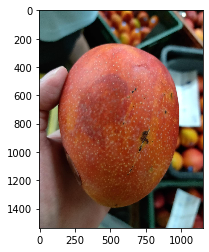

In [16]:
test_picture = cv2.cvtColor(df.loc[0,'ORIGINAL'], cv2.COLOR_BGR2RGB)
plt.imshow(test_picture)

# 增強對比 & erode

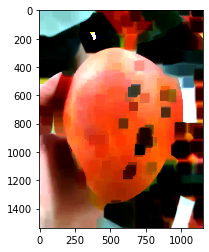

In [17]:
img = cv2.imread("C:/Users/tsaiy/MyPython/AIMango/C2_TrainDev/Dev/26519.jpg")
test_picture = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
I = test_picture
a = 2     #表示放大的倍數，通常在0~3之間，大於1為增加對比
b = -10   #用來調節亮度，大於0為調高亮度
O = I * float(a) + b
O[O > 255] = 255
O = np.round(O)
O = O.astype(np.uint8)
test_picture = O

plt.figure(1) #建一個畫布

#plt.subplot(231) #將畫布分成1*3個部分，將第一張子圖放在第一個位置
#plt.imshow(test_picture)


#擴散
#test = cv2.dilate(test_picture, None, iterations =36)
#plt.subplot(232) #將畫布分成1*3個部分，將第一張子圖放在第二個位置
#plt.imshow(test)

#侵蝕
test_erode = cv2.erode(test_picture, None, iterations =30)
#plt.subplot(233) #將畫布分成1*3個部分，將第一張子圖放在第三個位置
plt.imshow(test_erode)

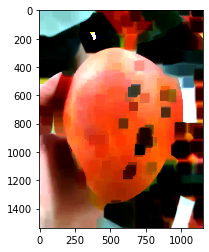

In [20]:
test_erode_d = cv2.dilate(test_erode, None, iterations =0)
plt.imshow(test_erode_d)

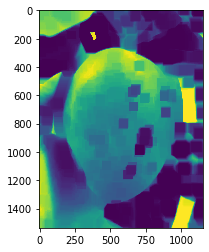

In [21]:
test_erode_d_g = cv2.cvtColor(test_erode_d, cv2.COLOR_RGB2GRAY) 
plt.imshow(test_erode_d_g)

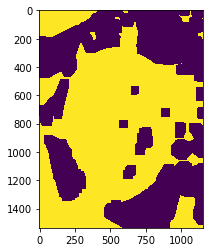

In [22]:
test_erode_d_g_b = cv2.threshold(test_erode_d_g,60,255,cv2.THRESH_BINARY)[1]
plt.imshow(test_erode_d_g_b)

# grabcut

In [ ]:
image_rgb = test_erode 
rectangle = (0, 0, image_rgb.shape[0], image_rgb.shape[1])

# Create initial mask
mask = np.zeros(image_rgb.shape[:2], np.uint8)

# Create temporary arrays used by grabCut
bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)

# Run grabCut
cv2.grabCut(image_rgb, # Our image
            mask, # The Mask
            rectangle, # Our rectangle
            bgdModel, # Temporary array for background
            fgdModel, # Temporary array for background
            5, # Number of iterations
            cv2.GC_INIT_WITH_RECT) # Initiative using our rectangle

# Create mask where sure and likely backgrounds set to 0, otherwise 1
mask_2 = np.where((mask==2) | (mask==0), 0, 1).astype('uint8')

# Multiply image with new mask to subtract background
image_rgb_nobg = image_rgb * mask_2[:, :, np.newaxis]

plt.imshow(image_rgb_nobg), plt.axis("off")

In [ ]:
blurred = cv2.GaussianBlur(test_erode_d_g_b, (5, 5), 0)
img = cv2.Canny(blurred, 50, 200)

#threshold1和2是用來區分strong edge和weak edge，範圍都是0~255。通常選擇thres2/thres1 = 0.33~0.50
#threshold1 = 50
#threshold2 = 100
#edges = cv2.Canny(img, threshold1, threshold2) #輸入的
plt.imshow(img,cmap = 'gray')

# Canny Edge

https://medium.com/@pomelyu5199/canny-edge-detector-%E5%AF%A6%E4%BD%9C-opencv-f7d1a0a57d19

In [ ]:
#圖要是「灰階」
gray = df.loc[0,'Gray']

#進行降噪處理
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
img = cv2.Canny(blurred, 40, 110)

#threshold1和2是用來區分strong edge和weak edge，範圍都是0~255。通常選擇thres2/thres1 = 0.33~0.50
threshold1 = 50
threshold2 = 100
edges = cv2.Canny(img, threshold1, threshold2) #輸入的

plt.subplot(231),plt.imshow(gray,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.subplot(232),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

edges_2 = cv2.dilate(edges, None, iterations =100)
plt.subplot(233),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image after erode'), plt.xticks([]), plt.yticks([])

plt.subplot(234),plt.imshow(gray - 100*edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

# Contour

https://chtseng.wordpress.com/2016/12/05/opencv-contour%E8%BC%AA%E5%BB%93/

In [54]:
#26519.jpg
import imutils

def is_contour_bad(c):
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    # the contour is 'bad' if it is not a rectangle
    
    return not len(approx) == 4

img = cv2.imread("C:/Users/tsaiy/MyPython/AIMango/test.jpg")

original = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #轉RGB
gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY) #轉灰階
edged = cv2.Canny(gray, 50, 100) #canny

cnts, hierarchy = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

cnts = imutils.grab_contours(contours)
mask = np.ones(img.shape[:2], dtype="uint8") * 255

#con = cv2.drawContours(original, contours, -1, (0, 255, 0), 2)


#loop over the contours
for c in cnts:
    # if the contour is bad, draw it on the mask
    if is_contour_bad(c):
        cv2.drawContours(mask, [c], -1, 0, -1)
    
# remove the contours from the image and show the resulting images
img = cv2.bitwise_and(img, img, mask=mask)
cv2.imshow("Mask", mask)
cv2.imshow("After", img)
cv2.waitKey(0)

-1

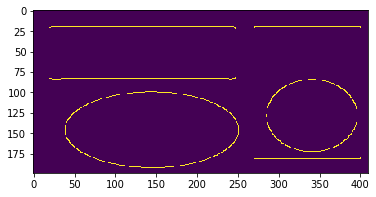

In [55]:
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(blurred, 20, 120)

plt.imshow(edged)



# http://www.learningaboutelectronics.com/Articles/How-to-crop-an-object-in-an-image-in-Python-OpenCV.php

In [56]:
for (i,c) in enumerate(cnts):
    x,y,w,h= cv2.boundingRect(c)
    
    cropped_contour= original[y:y+h, x:x+w]
    image_name= "output_shape_number_" + str(i+1) + ".jpg"
    cv2.imwrite(image_name, cropped_contour)
    readimage= cv2.imread(image_name)
    cv2.imshow('Image', readimage)
    cv2.waitKey(0)
    
cv2.destroyAllWindows()

# 兩兩變數間的關係

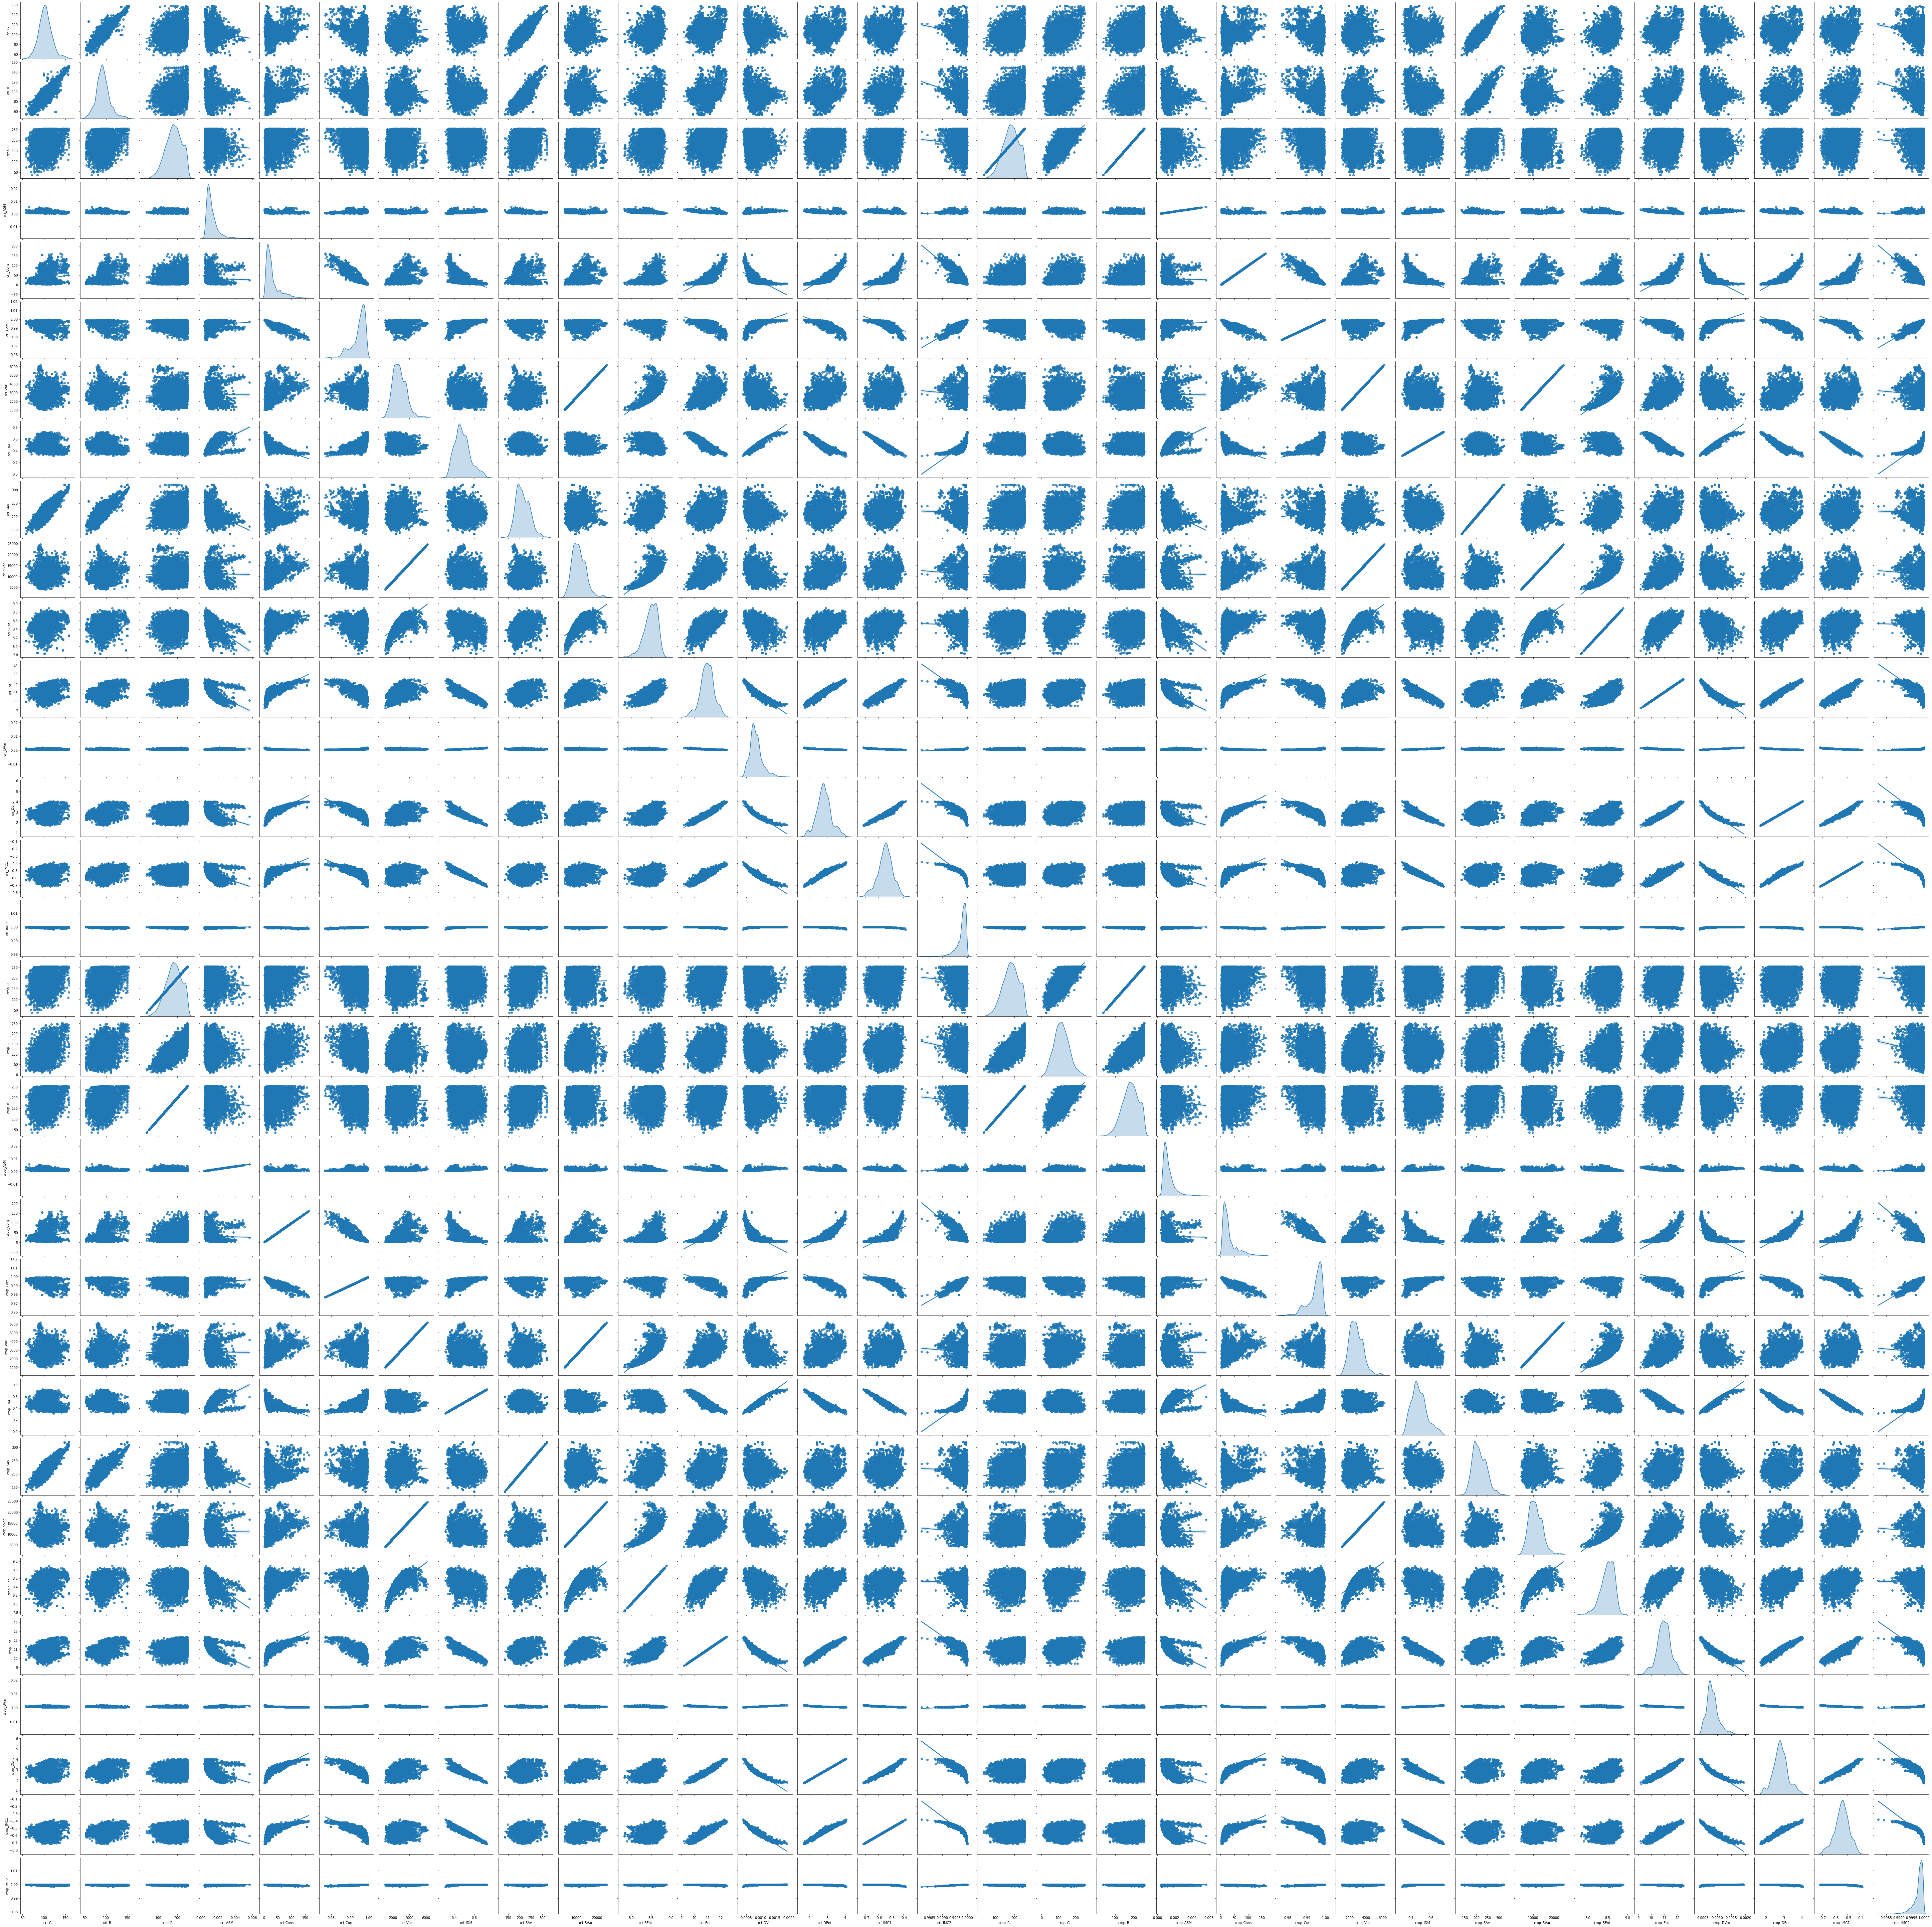

In [15]:
import seaborn as sns

sns.pairplot(df,vars = ['ori_G', 'ori_B', 'crop_R','ori_ASM', 'ori_Cons',
        'ori_Corr', 'ori_Var', 'ori_IDM', 'ori_SAv', 'ori_SVar', 'ori_SEnt',
        'ori_Ent', 'ori_DVar', 'ori_DEnt', 'ori_IMC1', 'ori_IMC2','crop_R', 
        'crop_G', 'crop_B', 'crop_ASM', 'crop_Cons', 'crop_Corr', 'crop_Var',
        'crop_IDM', 'crop_SAv', 'crop_SVar', 'crop_SEnt', 'crop_Ent', 'crop_DVar',
        'crop_DEnt', 'crop_IMC1', 'crop_IMC2'], 
             kind = 'reg',
             diag_kind="kde", )
